# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install lingpy

In [3]:
%%capture
import re
import os
import json
import random
import pickle
import numpy as np
import pandas as pd
from itertools import pairwise
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from lingpy.sequence.sound_classes import sampa2uni

import nltk
from nltk.corpus import udhr
from nltk.tokenize import SyllableTokenizer
from nltk.probability import FreqDist, MLEProbDist, ConditionalFreqDist, ConditionalProbDist
nltk.download('udhr')
nltk.download('punkt_tab')

# Cased Orthography Preprocessing

This first experiment keeps case unchanged in the orthography. The only changes we make to the orthography is removing non-alphabetic characters (with the exception of the dash - for all languages and the apostraphe ' for French specifically). This mostly removes numerals and punctuation.

## Process Data

In [4]:
#@title Segment Surprisal Function

def segment_surprisal(lexicon, syllables, language, sample_size=None, random_seed=None):
  '''
  Takes a lexicon and breaks it down into segments (phonemes or graphemes).
  Returns an N x 6 DataFrame, where N is the total number of segments, and
  the columns are:

    word_id: The index of the word the segment belongs to (starting at 1)
    position: The position of the segment within the word (starting at 1)
    segment: The segment itself (phoneme or grapheme)
    surprisal: The surprisal of that segment conditioned on all the preceding segments in the word.
    language: The language code of the lexicon.
    syllable: Binary marker for syllable breaks, 1 for the start of a new syllable, 0 otherwise.

  Params:
    lexicon (list): List of vocab terms.
    syllables (list): List of syllable breaks.
    language (str): Language code for lexicon.
    sample_size (int): Number of samples to take from lexicon.
                       If None, will take entire lexicon.
    random_seed (int): Random seed to make sampling reproducible.
                       If None, sampling will be non-reproducible.
                       If sample_size is None, this parameter is ignored.
  '''
  np.random.seed(seed=random_seed)

  # If sample_size is not None, draw that many samples from lexicon for vocab_list.
  if sample_size:
    if sample_size > len(lexicon):
      raise ValueError(f'Sample size of {sample_size} is larger than lexicon size of {len(lexicon)}')
    rand_idx = np.random.choice(len(lexicon), size=sample_size, replace=False)
    vocab_list = [lexicon[i] for i in rand_idx]
    syll_list = [syllables[i] for i in rand_idx]

  # Otherwise, use full lexicon.
  else:
    vocab_list = lexicon
    syll_list = syllables

  # Add ending character ">" to each word.
  vocab_list = [word+'>' for word in vocab_list]

  # Flatten syll_list so it is no longer separated by words
  syll_list = [syll for word in syll_list for syll in word]

  max_pos = max([len(word) for word in vocab_list])
  idx = list(range(len(vocab_list)))

  # Initialize empty lists for column values.
  word_id = []
  position = []
  segment = []
  surprisal = []

  for p in range(0, max_pos):
    # Create conditional probability distribution P(segment|context) up to position p.
    pos_list = [(word[0:p], word[p]) for word in vocab_list if len(word)>p]
    cond_freq_dist = ConditionalFreqDist(pos_list)
    cond_prob_dist = ConditionalProbDist(cond_freq_dist, MLEProbDist)

    # Add on to lists of word_ids, positions, segments, and surprisals up to position p.
    word_id += [i+1 for i in idx if len(vocab_list[i])>p]
    position += [p+1] * len(pos_list)
    segment += [ngram[1] for ngram in pos_list]
    surprisal += [-cond_prob_dist[ngram[0]].logprob(ngram[1]) for ngram in pos_list]

  # Add "lang" list, should match the length of other four lists.
  lang = [language] * len(word_id)

  # Create DataFrame with word_id, position, segment, surprisal, and lang columns.
  df = pd.DataFrame(list(zip(word_id, position, segment, surprisal, lang)),
                    columns=['word_id', 'position', 'segment', 'surprisal', 'lang'])

  # Remove rows with ending marker ">" from DataFrame
  df = df[df['segment'] != '>']


  # Make sure all surprisal values are >= 0, then change -0.0 to 0.0.
  if df['surprisal'].lt(0).any():
    raise ValueError('Surprisal cannot be < 0')
  df['surprisal'] = df['surprisal'].apply(abs)


  # Sort DataFrame first by word_id, then by position.
  df = df.sort_values(by=['word_id', 'position'], ignore_index=True)

  # Add syll_list to DataFrame
  df['syllable'] = syll_list

  return df

In [5]:
#@title Process and Calculate Surprisal

# Read in English, German, and French UDHR
english_script = udhr.raw('English-Latin1')
german_script = udhr.raw('German_Deutsch-Latin1')
french_script = udhr.raw('French_Francais-Latin1')

# Write UDHR to text file
with open('UDHR_English_script_cased.txt','w') as f:
  f.write(english_script)
with open('UDHR_German_script_cased.txt','w') as f:
  f.write(german_script)
with open('UDHR_French_script_cased.txt','w') as f:
  f.write(french_script)

# Remove non-alphabetic characters (save dash for all languages and apostrophe for French)
english_symbols = set(char for char in english_script if not char.isalpha() and not char.isspace()) - set(["-"])
german_symbols = set(char for char in german_script if not char.isalpha() and not char.isspace()) - set(["-"])
french_symbols = set(char for char in french_script if not char.isalpha() and not char.isspace()) - set(["-","'"])

english_map = str.maketrans('','',''.join(english_symbols))
german_map = str.maketrans('','',''.join(german_symbols))
french_map = str.maketrans('','',''.join(french_symbols))

english_clean = english_script.translate(english_map)
german_clean = german_script.translate(german_map)
french_clean = french_script.translate(french_map)

# Split text by whitespace
english_words = english_clean.split()
german_words = german_clean.split()
french_words = french_clean.split()

# Extract unique words
english_lexicon = sorted(set(english_words), key=lambda x: x.lower())
german_lexicon = sorted(set(german_words), key=lambda x: x.lower())
french_lexicon = sorted(set(french_words), key=lambda x: x.lower())

# Write lexicons to file
with open('UDHR_English_lexicon_cased.txt','w') as f:
  f.write('\n'.join(english_lexicon))
with open('UDHR_German_lexicon_cased.txt','w') as f:
  f.write('\n'.join(german_lexicon))
with open('UDHR_French_lexicon_cased.txt','w') as f:
  f.write('\n'.join(french_lexicon))

# Create null syllable lists for segment_surprisal function
english_sylls = [[0]*len(word) for word in english_lexicon]
german_sylls = [[0]*len(word) for word in german_lexicon]
french_sylls = [[0]*len(word) for word in french_lexicon]

english_surprisal = segment_surprisal(english_lexicon, english_sylls, 'English')
german_surprisal = segment_surprisal(german_lexicon, german_sylls, 'German')
french_surprisal = segment_surprisal(french_lexicon, french_sylls, 'French')

# Print number of words and unique words
print(f'English UDHR: {len(english_words)}  Unique cased words: {len(english_lexicon)}')
print(f'German UDHR: {len(german_words)}  Unique cased words: {len(german_lexicon)}')
print(f'French UDHR: {len(french_words)}  Unique cased words: {len(french_lexicon)}')

English UDHR: 1589  Unique cased words: 498
German UDHR: 1329  Unique cased words: 544
French UDHR: 1591  Unique cased words: 555


In [6]:
df = english_surprisal
idx = 0
word_id = idx + 1
word_df = df[df['word_id']==word_id]

surp = word_df['surprisal'].to_numpy()
syll = word_df['syllable'].to_numpy()

surp.flags.writeable, syll.flags.writeable

(True, True)

## Run Model

In [7]:
#@title Model Definition
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CommonModel(nn.Module):
  '''
  This defines the fit, evaluate, and predict functions that are shared between all models.
  It is not instantiated directly but inherited by all other model classes.

  Methods:
    fit: Train model on train dataloader and evaluate on validation dataloader.
         Prints training losses and validation losses. No return.

    evaluate: Calculates losses on evaluation dataloader, prints and returns average loss across whole dataset.

    predict: Returns predictions and true labels from test dataloader.
             Predictions are list of word length with probabilities of each position being syllable break.
             True labels are binary list of word length, with 1 for syllable break and 0 otherwise.
  '''
  def __init__(self):
    super().__init__()

  def fit(self, train_dl, val_dl, epochs, loss_fn, lstm=False):
    if loss_fn == 'bce':
      self.loss_fn = nn.BCEWithLogitsLoss()
    elif loss_fn == 'focal':
      self.loss_fn = sigmoid_focal_loss
    else:
      raise ValueError("loss_fn must either be 'bce' or 'focal'.")
    optimizer = torch.optim.AdamW(self.parameters())
    for epoch in range(epochs):
      running_loss = 0.0
      syllables = 0
      for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        prediction = self.forward(surprisal)
        loss = self.loss_fn(prediction, syll)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0 and i != 0:
          print(f'{loss}, [{epoch + 1}, {i + 1:5d}] loss: {running_loss/(i+1)}')
      print()

      val_loss = self.evaluate(val_dl, lstm=lstm)
      print('Validation Loss')
      print(val_loss)
      print()

    return running_loss / (i+1)

  def evaluate(self, val_dl, lstm=False):
    losses = []
    syllables = 0
    with torch.no_grad():
      for data in val_dl:
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        prediction = self.forward(surprisal)
        loss = self.loss_fn(prediction, syll)
        losses.append(loss)

    return torch.Tensor(losses).mean()

  def predict(self, test_dl, separate_words=False, lstm=False):
    with torch.no_grad():
      self.eval()
      predictions = []
      syllables = []
      activation = nn.Sigmoid()

      for data in test_dl:
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        pred = activation(self.forward(surprisal)).detach().cpu()

        if separate_words:
          if lstm:
            for i in range(syll.shape[0]):
              syllables.append(syll[i,:,0])
              predictions.append(pred[i,:,0])
          else:
            for i in range(syll.shape[0]):
              syllables.append(syll[i,0])
              predictions.append(pred[i,0])
        else:
          syll = syll.cpu().flatten().tolist()
          pred = activation(self.forward(surprisal)).flatten().tolist()
          syllables += syll
          predictions += pred

    return predictions, syllables

  def fit_wandb(self, train_dl, val_dl, epochs, loss_fn, run_name=None, project_name='Decipherment Project', lstm=False):
    if loss_fn == 'bce':
      self.loss_fn = nn.BCEWithLogitsLoss()
    elif loss_fn == 'focal':
      self.loss_fn = sigmoid_focal_loss
    else:
      raise ValueError("loss_fn must either be 'bce' or 'focal'.")

    if run_name:
      name = run_name
    elif lstm is False:
      name = f'{self.architecture}_{self.n_gram}gram_{self.d_hidden}hidden_{self.n_layers}layers_{loss_fn}_loss'
    elif self.bidirectional is True:
      name = f'{self.architecture}_{self.d_hidden}hidden_{self.n_layers}layers_bidirectional_{loss_fn}_loss'
    else:
      name = f'{self.architecture}_{self.d_hidden}hidden_{self.n_layers}layers_unidirectional_{loss_fn}_loss'

    if lstm is False:
      config = {'architecture' : self.architecture,
                'n_gram' : self.n_gram,
                'd_hidden' : self.d_hidden,
                'n_layers' : self.n_layers,
                'loss_fn' : loss_fn,
                'size' : self.size}
    else:
      config = {'architecture' : self.architecture,
                'd_hidden' : self.d_hidden,
                'n_layers' : self.n_layers,
                'loss_fn' : loss_fn,
                'size' : self.size,
                'bidirectional' : self.bidirectional}

    wandb.init(project=project_name,
               name=name,
               config=config)

    for epoch in range(epochs):
      train_loss = self.fit(train_dl, val_dl, epochs=1, loss_fn=loss_fn, lstm=lstm)
      val_loss = self.evaluate(val_dl, lstm=lstm)
      wandb.log({'train_loss': train_loss, 'val_loss': val_loss})


class NgramFNN(CommonModel):
  '''
  Feedforward Neural Network (FNN) that takes an ngram of size n_gram and feeds the surprisals through
  n hidden layers (n_layers) each of dimension d (d_hidden).

  *NOTE* This is implemented using Conv1d layers, however because we lock the kernel_size of all hidden
  layers and the output layer to 1, this is equivalent to a Feedforward Network operating over ngrams.

  Params:
    n_gram:   Size of ngram window to look over
    d_hidden: Dimensionality of hidden layers (equivalent to n_filters in NgramCNN)
    n_layers: Number of hidden layers (not including input and output layers)

  Returns:
    x: List of length of original word showing log-odds for each position to be a syllable break.
       This is converted to probabilities using sigmoid activation in "predict" method.

  Methods:
    See parent class "CommonModel"
  '''
  def __init__(self, n_gram, d_hidden, n_layers):
    super().__init__()

    self.n_gram = n_gram
    self.d_hidden = d_hidden
    self.n_layers = n_layers
    self.architecture = 'fnn'

    self.input_ = nn.Conv1d(in_channels=1, out_channels=d_hidden, kernel_size=n_gram, padding='same')
    self.output = nn.Conv1d(in_channels=d_hidden, out_channels=1, kernel_size=1)
    self.hidden = nn.ModuleList()
    for n in range(n_layers):
      self.hidden.append(nn.Conv1d(in_channels=d_hidden, out_channels=d_hidden, kernel_size=1))
      self.hidden.append(nn.GELU())
    self.activation = nn.GELU()

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x = self.input_(x)
    x = self.activation(x)
    for hidden in self.hidden:
      x = hidden(x)
    x = self.output(x)

    return x


class NgramCNN(CommonModel):
  '''
  Identical to the NgramFNN, except that it applies the same window size (n_gram) to the hidden layers
  as it does to the input layer, resulting in a kind of "recursive" ngram structure that incorporates
  information from more and more neighboring ngrams the deeper the model goes. This is the same as our
  original CNN model.

  Params:
    n_gram:    Size of ngram window to look over
    n_filters: Number of filters to pass over each layer
    n_layers:  Number of hidden layers (not including input and output layers)

  Returns:
    x: List of length of original word showing log-odds for each position to be a syllable break.
       This is converted to probabilities using sigmoid activation in "predict" method.

  Methods:
    See parent class "CommonModel"
  '''
  def __init__(self, n_gram, n_filters, n_layers):
    super().__init__()

    self.n_gram = n_gram
    self.d_hidden = n_filters
    self.n_layers = n_layers
    self.architecture = 'cnn'

    self.input_ = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=n_gram, padding='same')
    self.output = nn.Conv1d(in_channels=n_filters, out_channels=1, kernel_size=1)
    self.hidden = nn.ModuleList()
    for n in range(n_layers):
      self.hidden.append(nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=n_gram, padding='same'))
      self.hidden.append(nn.GELU())
    self.activation = nn.GELU()

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x = self.input_(x)
    x = self.activation(x)
    for hidden in self.hidden:
      x = hidden(x)
    x = self.output(x)

    return x


class NgramLSTM(CommonModel):
  def __init__(self,
               hidden_size=5,
               n_layers=1,
               bidirectional=True):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,
                        hidden_size=hidden_size,
                        num_layers=n_layers,
                        bias=True,
                        batch_first=True,
                        dropout=0.0,
                        bidirectional=bidirectional,
                        proj_size=0,
                        device=None,
                        dtype=None)

    self.d_hidden = hidden_size
    self.n_layers = n_layers
    self.architecture = 'lstm'
    self.bidirectional=bidirectional

    if bidirectional:
      self.linear = nn.Linear(in_features= 2 * hidden_size, out_features=1)
    else:
      self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x, hidden_out = self.lstm(x)
    x = self.linear(x)

    return x

In [8]:
#@title Dataset Definition

class WordDataset(Dataset):
  def __init__(self, dataframe):
    super().__init__()
    self.dataframe = dataframe

  def __len__(self):
    return self.dataframe['word_id'].max()

  def __getitem__(self, idx):
    word_id = idx + 1
    word_df = self.dataframe[self.dataframe['word_id']==word_id]

    surprisal = word_df['surprisal'].to_numpy()
    syll = word_df['syllable'].to_numpy()
    lang = word_df['lang'].iloc[0]
    word = ''.join(word_df['segment'].tolist())

    return surprisal, syll, lang, word

In [10]:
#@title Load Language Models
model_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Models/Original/LOO'

english_cnn = NgramCNN(n_gram=7, n_filters=15, n_layers=10).to(device)
english_cnn.load_state_dict(torch.load(os.path.join(model_folder, 'LOO_English_CNN_Original.pt'),
                                       map_location=device, weights_only=True))

german_cnn = NgramCNN(n_gram=7, n_filters=15, n_layers=10).to(device)
german_cnn.load_state_dict(torch.load(os.path.join(model_folder, 'LOO_German_CNN_Original.pt'),
                                      map_location=device, weights_only=True))

french_cnn = NgramCNN(n_gram=7, n_filters=15, n_layers=10).to(device)
french_cnn.load_state_dict(torch.load(os.path.join(model_folder, 'LOO_French_CNN_Original.pt'),
                                      map_location=device, weights_only=True))

<All keys matched successfully>

In [11]:
#@title Load DataLoaders
english_ds = [word for word in WordDataset(english_surprisal)]
english_dl = DataLoader(english_ds, batch_size=1, shuffle=False)
german_ds = [word for word in WordDataset(german_surprisal)]
german_dl = DataLoader(german_ds, batch_size=1, shuffle=False)
french_ds = [word for word in WordDataset(french_surprisal)]
french_dl = DataLoader(french_ds, batch_size=1, shuffle=False)

In [12]:
#@title Make Predictions
preds_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Predictions/UDHR/Cased'

datasets = {'English':english_ds, 'German':german_ds, 'French':french_ds}
predictions = dict()

predictions['English'] = english_cnn.predict(english_dl, separate_words=False)
predictions['German'] = german_cnn.predict(german_dl, separate_words=False)
predictions['French'] = french_cnn.predict(french_dl, separate_words=False)

# Format predictions, ground truths, languages, word indices, positions, and segments
# to feed into Pandas DataFrame
for language, (preds, sylls) in predictions.items():
  surprisals = [entry for row in datasets[language] for entry in row[0]]
  langs = [entry[2] for entry in datasets[language] for i in range(len(entry[1]))]
  word_ids = [id+1 for id in range(len(datasets[language])) for j in range(len(datasets[language][id][1]))]
  positions = [i+1 for entry in datasets[language] for i in range(len(entry[1]))]
  segments = [segment for entry in datasets[language] for segment in entry[3]]

  cnn_output = pd.DataFrame({'Predictions':preds, 'Surprisals':surprisals, 'Languages':langs, 'Word Indices':word_ids,
                            'Positions':positions, 'Segments':segments}).set_index('Word Indices')

  cnn_output.to_csv(os.path.join(preds_folder, f'UDHR_LOO_{language}_CNN_Original_Cased.csv'), index=False)
  predictions[language] = cnn_output

predictions['English'][:10]

,Predictions,Surprisals,Languages,Positions,Segments
Word Indices,,,,,
1,0.998759,3.567685,English,1,a
2,1.000000,3.567685,English,1,a
2,0.042838,2.070389,English,2,c
2,0.150922,1.000000,English,3,c
2,0.743402,1.321928,English,4,e
2,0.188656,0.000000,English,5,s
2,0.017834,0.000000,English,6,s
3,1.000000,3.567685,English,1,a
3,0.011546,2.070389,English,2,c


## Evaluate Results

In [13]:
#@title Threshold Predictions, Add Syllable Breaks
def syllabify(entry):
  if entry['Predictions'] < threshold or entry['Positions'] == 1:
    return entry['Segments']
  else:
    return '_' + entry['Segments']

def get_word(word_id, dataframe):
  return ''.join(dataframe.loc[[word_id], 'Segments'].tolist())

def get_syllables(word_id, dataframe):
  return ''.join(dataframe.loc[[word_id], 'Pred Segments'].tolist())

# Load thresholds from validation runs on other languages
results_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'
with open(os.path.join(results_original, 'LOO_Thresholds_NoHead')) as f:
  loo_thresholds_nohead = json.loads(f.read())

# Add Pred Syllables, Pred Segments, and Threshold to predictions dataframe
for lang, preds in predictions.items():
  threshold = loo_thresholds_nohead['CNN'][lang]
  preds['Pred Segments'] = preds.apply(syllabify, axis=1)
  preds['Pred Syllables'] = (preds['Predictions'] >= threshold).astype('int')
  preds['Threshold'] = threshold
  predictions[lang] = preds[['Predictions','Pred Syllables','Surprisals','Languages',
                             'Threshold','Positions','Segments','Pred Segments']]

predictions['English']

,Predictions,Pred Syllables,Surprisals,Languages,Threshold,Positions,Segments,Pred Segments
Word Indices,,,,,,,,
1,0.998759,1,3.567685,English,0.33,1,a,a
2,1.000000,1,3.567685,English,0.33,1,a,a
2,0.042838,0,2.070389,English,0.33,2,c,c
2,0.150922,0,1.000000,English,0.33,3,c,c
2,0.743402,1,1.321928,English,0.33,4,e,_e
...,...,...,...,...,...,...,...,...
498,0.009741,0,1.459432,English,0.33,2,o,o
498,0.723166,1,0.192645,English,0.33,3,r,_r
498,0.242546,0,1.807355,English,0.33,4,t,t


In [14]:
#@title Extract All Syllables

# Make dictionary for each language mapping each word in the lexicon to its syllabified form
syllable_dict = dict()

syllable_dict['English'] = {get_word(id, predictions['English']):get_syllables(id, predictions['English'])
                            for id in predictions['English'].index.unique()}
syllable_dict['German'] = {get_word(id, predictions['German']):get_syllables(id, predictions['German'])
                           for id in predictions['German'].index.unique()}
syllable_dict['French'] = {get_word(id, predictions['French']):get_syllables(id, predictions['French'])
                           for id in predictions['French'].index.unique()}

# Extract all syllables and count them
english_syllables = Counter([syll for word in syllable_dict['English'].values() for syll in word.split('_')])
german_syllables = Counter([syll for word in syllable_dict['German'].values() for syll in word.split('_')])
french_syllables = Counter([syll for word in syllable_dict['French'].values() for syll in word.split('_')])

english_syllables.most_common()

[('i', 69),
 ('t', 48),
 ('a', 39),
 ('e', 39),
 ('r', 32),
 ('re', 32),
 ('n', 31),
 ('o', 29),
 ('in', 25),
 ('ion', 24),
 ('u', 21),
 ('c', 20),
 ('s', 20),
 ('l', 19),
 ('co', 17),
 ('te', 16),
 ('ing', 15),
 ('on', 15),
 ('ent', 14),
 ('p', 14),
 ('ed', 14),
 ('pro', 14),
 ('m', 13),
 ('al', 13),
 ('at', 13),
 ('be', 13),
 ('ce', 12),
 ('nt', 12),
 ('me', 12),
 ('th', 12),
 ('d', 11),
 ('er', 11),
 ('es', 11),
 ('v', 11),
 ('se', 10),
 ('de', 10),
 ('ti', 10),
 ('le', 9),
 ('h', 9),
 ('b', 9),
 ('en', 9),
 ('ng', 9),
 ('un', 9),
 ('st', 8),
 ('ar', 8),
 ('fo', 8),
 ('pr', 8),
 ('pe', 8),
 ('or', 7),
 ('an', 7),
 ('her', 7),
 ('tr', 7),
 ('li', 7),
 ('he', 7),
 ('di', 7),
 ('ns', 7),
 ('gr', 7),
 ('fr', 7),
 ('ma', 7),
 ('io', 7),
 ('wo', 7),
 ('ess', 6),
 ('ts', 6),
 ('ra', 6),
 ('la', 6),
 ('nd', 6),
 ('ty', 6),
 ('ll', 6),
 ('ry', 6),
 ('con', 6),
 ('nal', 6),
 ('ted', 6),
 ('g', 6),
 ('ri', 6),
 ('ac', 5),
 ('ble', 5),
 ('nce', 5),
 ('ity', 5),
 ('ot', 5),
 ('ch', 5),
 ('ur', 5

In [15]:
#@title Extract Syllables by Position

words = dict()
pred_syllables = dict()

for lang in ['English','German','French']:
  ids = []
  segments = []
  pred_sylls = []
  for id in predictions[lang].index.unique():
    df = predictions[lang].loc[[id]]
    ids.append(id)

    segments.append(''.join(df['Segments'].tolist()))
    pred_sylls.append(''.join(df['Pred Segments'].tolist()).split('_'))

  words[lang] = pd.DataFrame({'Word Indices':ids, 'Word':segments, 'Pred Syllables':pred_sylls}).set_index('Word Indices')

  pred_ids = [[id]*len(pred) for id,pred in zip(ids, pred_sylls)]
  pred_ids = [i for id in pred_ids for i in id]
  pred_positions = [i+1 for pred in pred_sylls for i, syll in enumerate(pred)]
  pred_sylls = [syll for pred in pred_sylls for syll in pred]
  pred_lengths = [len(syll) for syll in pred_sylls]

  pred_syllables[lang] = pd.DataFrame({'Positions':pred_positions, 'Syllables':pred_sylls, 'Lengths':pred_lengths,
                                       'Word Indices':pred_ids}).set_index('Positions')

display(words['English'])
print()
display(pred_syllables['English'])

,Word,Pred Syllables
Word Indices,,
1,a,[a]
2,access,"[acc, ess]"
3,accessible,"[acc, ess, ib, le]"
4,accordance,"[acc, or, d, an, ce]"
5,according,"[acc, ord, ing]"
...,...,...
494,works,"[wo, rks]"
495,world,"[wo, rld]"
496,worship,"[wor, sh, ip]"


,Syllables,Lengths,Word Indices
Positions,,,
1,a,1,1
1,acc,3,2
2,ess,3,2
1,acc,3,3
2,ess,3,3
...,...,...,...
1,wo,2,497
2,rth,3,497
1,wo,2,498


In [16]:
#@title Extract Unique Syllables by Position

unique_preds = dict()

for lang in ['English','German','French']:
  pred_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos],['Syllables','Lengths']].reset_index()
    pred_df['Count'] = pred_df['Syllables']
    pred_df = pred_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Count':'count'})
    #pred_df = pred_df[pred_df['Count']>10].set_index('Positions')
    pred_df = pred_df.set_index('Positions')
    pred_list.append(pred_df)
  unique_preds[lang] = pd.concat(pred_list)

display(unique_preds['English'])

,Syllables,Lengths,Count
Positions,,,
1,A,1,2
1,All,3,1
1,C,1,1
1,D,1,1
1,E,1,3
...,...,...,...
9,v,1,1
10,ce,2,1
10,e,1,1


In [17]:
#@title Extract Common Syllables by Position

common_preds = dict()  # We threshold predicted syllables by count

for lang in ['English','German','French']:
  pred_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos],['Syllables','Lengths']].reset_index()
    pred_df['Count'] = pred_df['Syllables']
    pred_df = pred_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Count':'count'})
    pred_df = pred_df[pred_df['Count']>2].set_index('Positions')
    #pred_df = pred_df.set_index('Positions')
    pred_list.append(pred_df)
  common_preds[lang] = pd.concat(pred_list)

display(common_preds['English'])

,Syllables,Lengths,Count
Positions,,,
1,E,1,3
1,ac,2,4
1,acc,3,4
1,ar,2,4
1,ass,3,3
...,...,...,...
6,n,1,5
6,nt,2,3
6,t,1,3


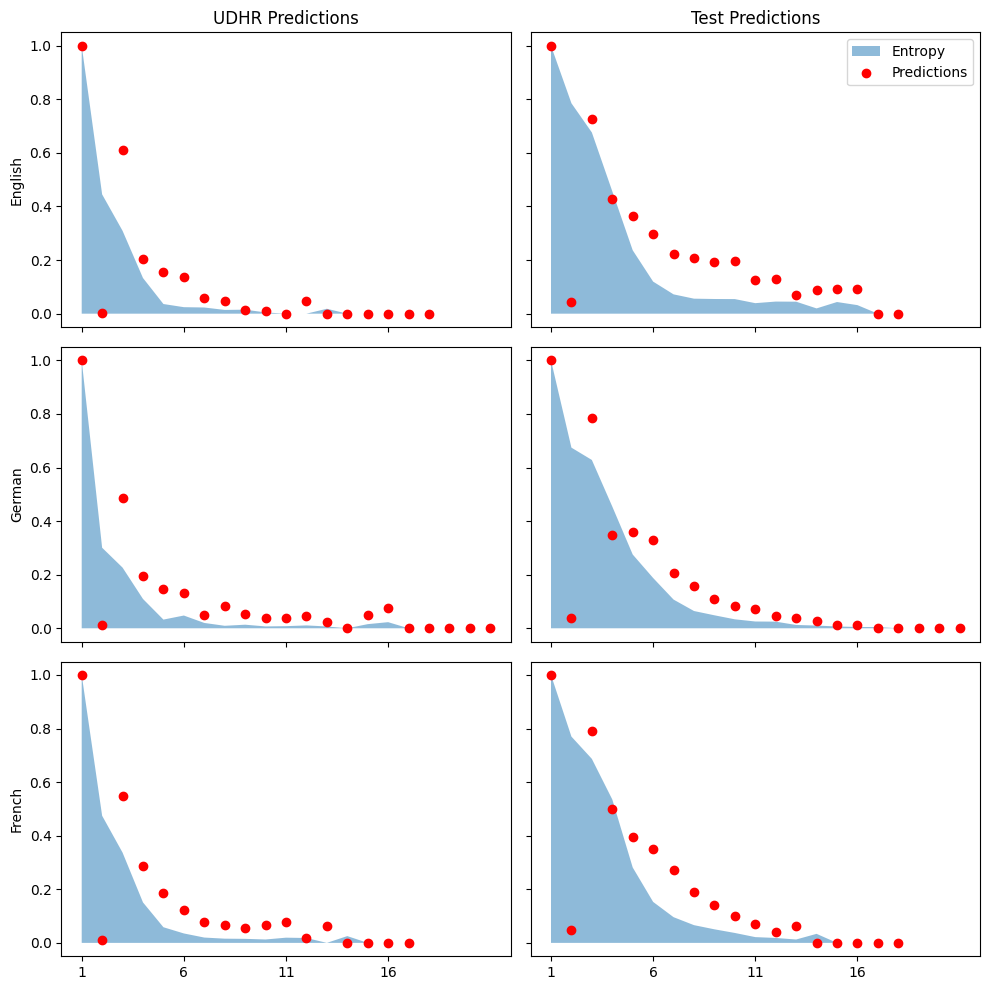

In [ ]:
#@title Plot Syllable Breaks by Position

# Folder Paths
results_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'
preds_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Predictions/Original'

# Load Test Result Thresholds
with open(os.path.join(results_original, 'LOO_Thresholds_NoHead')) as f:
  loo_thresholds_nohead = json.loads(f.read())

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey=True)
for i, (lang,code,df) in enumerate([('English','en',english_surprisal),('German','de',german_surprisal),('French','fr',french_surprisal)]):
  udhr_preds = predictions[lang]
  udhr_positions = udhr_preds['Positions'].unique()
  udhr_entropy = [udhr_preds[udhr_preds['Positions']==pos]['Surprisals'].mean() for pos in udhr_positions]
  udhr_entropy = udhr_entropy / max(udhr_entropy)
  udhr_sylls = [udhr_preds[udhr_preds['Positions']==pos]['Pred Syllables'].mean() for pos in udhr_positions]

  threshold = loo_thresholds_nohead['FNN'][lang]
  test_preds = pd.read_csv(os.path.join(preds_original, 'LOO', f'LOO_{lang}_FNN_Original.csv'))
  test_preds['Surprisals'] = [surprisal for entry in test_ds for surprisal in entry[0]]
  test_preds[['Word Indices','Positions']] +=1
  test_preds = test_preds[test_preds['Languages']==code]
  test_positions = test_preds['Positions'].unique()
  test_entropy = [test_preds[test_preds['Positions']==pos]['Surprisals'].mean() for pos in test_positions]
  test_entropy = test_entropy / max(test_entropy)
  test_sylls = [(test_preds[test_preds['Positions']==pos]['Predictions']>=threshold).mean() for pos in test_positions]
  ax[i,0].fill_between(udhr_positions, udhr_entropy, alpha=0.5)
  ax[i,0].scatter(udhr_positions, udhr_sylls, c='red')
  ax[i,1].fill_between(test_positions, test_entropy, alpha=0.5, label='Entropy')
  ax[i,1].scatter(test_positions, test_sylls, c='red', label='Predictions')
  ax[i,0].set_ylabel(lang)
ax[0,0].set_title('UDHR Predictions')
ax[0,1].set_title('Test Predictions')
ax[0,1].legend()
plt.xticks(range(1,21,5))
plt.tight_layout()
plt.savefig('CNN UDHR Predictions (cased).png')
plt.show()

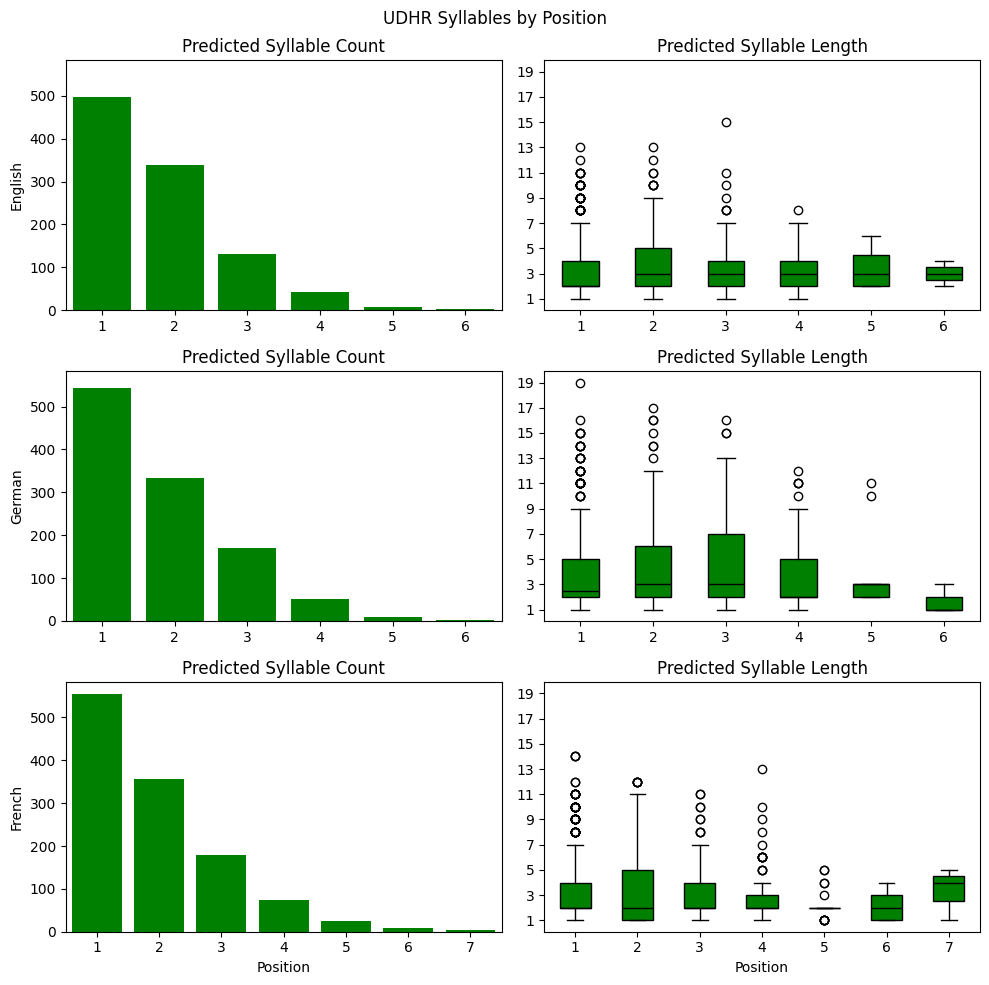

In [ ]:
#@title Plot Syllables by Position

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex='row', sharey='col')
max_len = 0
for i, lang in enumerate(['English','German','French']):
  pred_df = pred_syllables[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[pos,'Lengths'].tolist() for pos in pred_positions]
  max_pred = max([length for pred in pred_lengths for length in pred])
  max_len = max(max_len, max_pred)
  ax[i,0].bar(pred_positions, pred_count, color='green')
  ax[i,1].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_title(f'Predicted Syllable Count')
  ax[i,1].set_title(f'Predicted Syllable Length')
  ax[i,0].set_ylabel(lang)
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[0,1].set_yticks(range(1,max_len+1,2))
ax[1,1].set_yticks(range(1,max_len+1,2))
ax[2,1].set_yticks(range(1,max_len+1,2))
plt.suptitle(f'UDHR Syllables by Position')
plt.tight_layout()
plt.savefig(f'UDHR Syllables by Position (cased).png')
plt.show()
print()

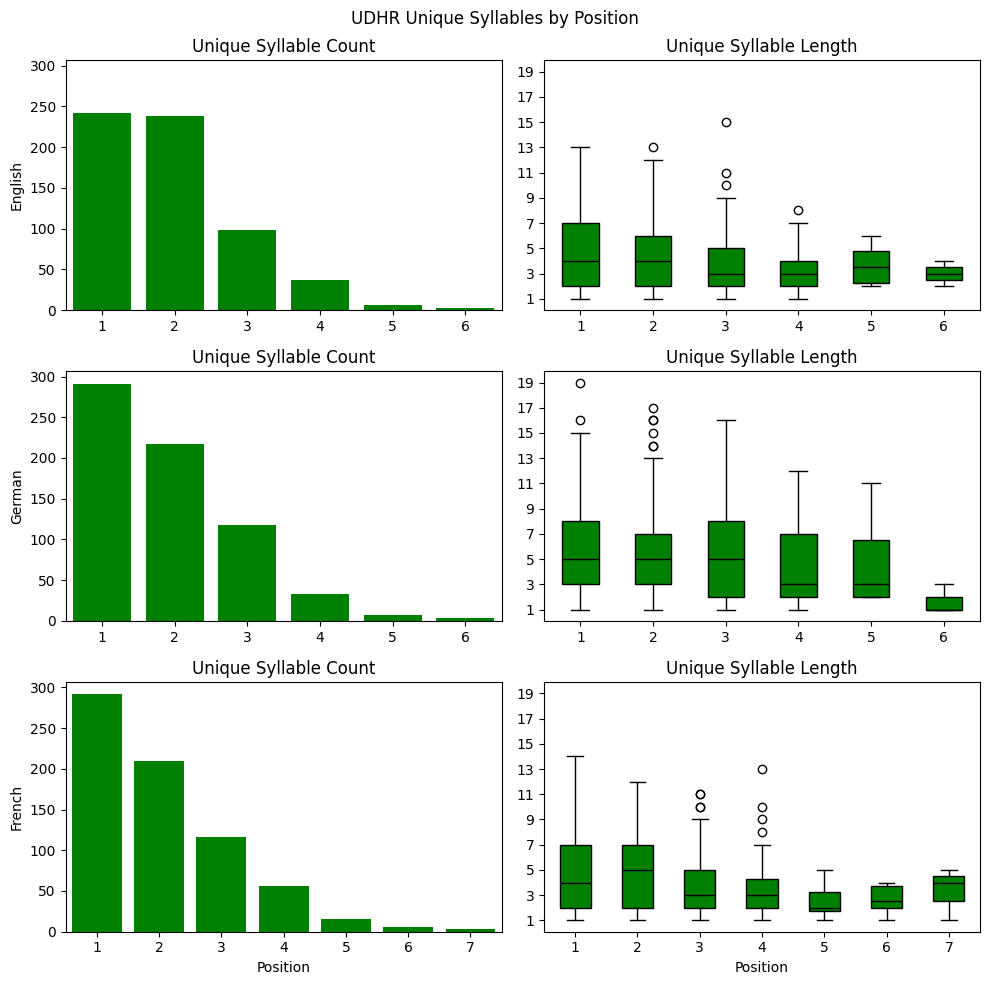

In [ ]:
#@title Plot Unique Syllables by Position

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex='row', sharey='col')
max_len = 0
for i, lang in enumerate(['English','German','French']):
  pred_df = unique_preds[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[pos,'Lengths'].tolist() for pos in pred_positions]
  max_pred = max([length for pred in pred_lengths for length in pred])
  max_len = max(max_len, max_pred)
  ax[i,0].bar(pred_positions, pred_count, color='green')
  ax[i,1].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_title(f'Unique Syllable Count')
  ax[i,1].set_title(f'Unique Syllable Length')
  ax[i,0].set_ylabel(lang)
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[0,1].set_yticks(range(1,max_len+1,2))
ax[1,1].set_yticks(range(1,max_len+1,2))
ax[2,1].set_yticks(range(1,max_len+1,2))
plt.suptitle(f'UDHR Unique Syllables by Position')
plt.tight_layout()
plt.savefig(f'UDHR Unique Syllables by Position (cased).png')
plt.show()
print()

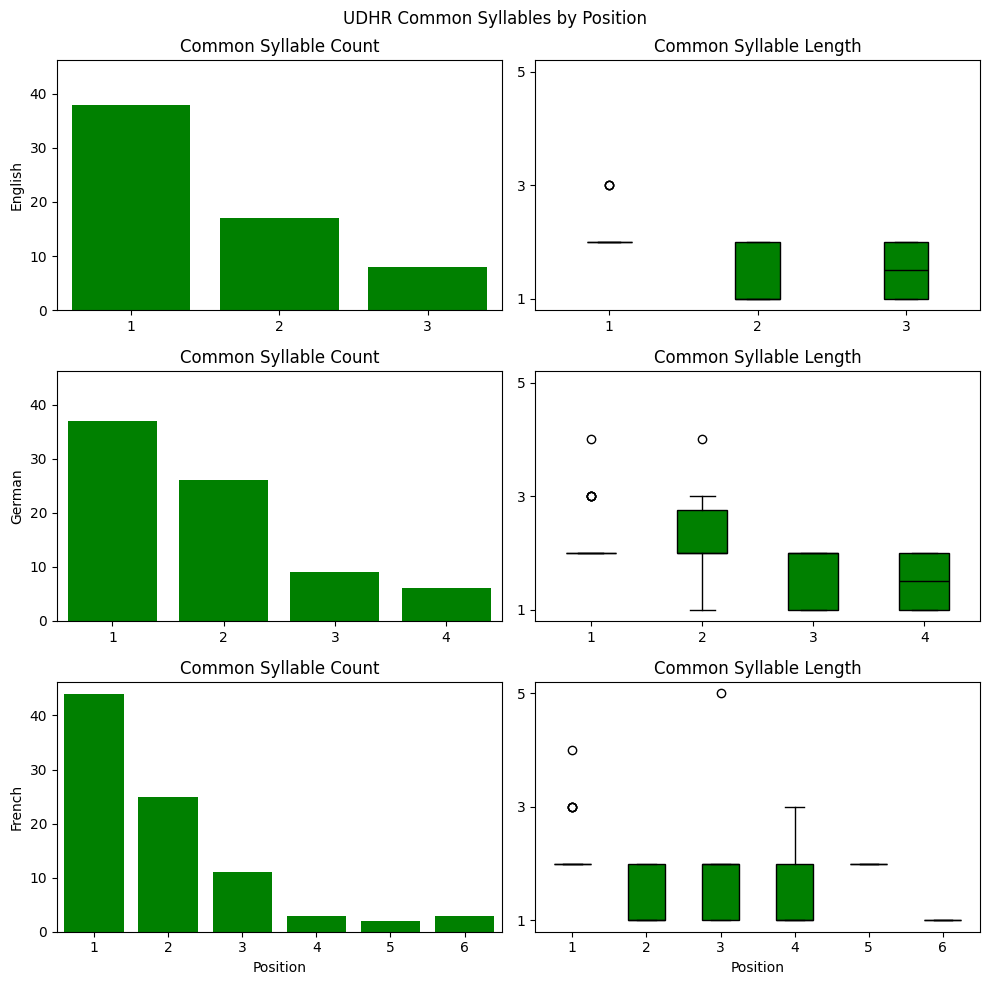

In [ ]:
#@title Plot Common Syllables by Position

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex='row', sharey='col')
max_len = 0
for i, lang in enumerate(['English','German','French']):
  pred_df = common_preds[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[[pos],'Lengths'].tolist() for pos in pred_positions]
  max_pred = max([length for pred in pred_lengths for length in pred])
  max_len = max(max_len, max_pred)
  ax[i,0].bar(pred_positions, pred_count, color='green')
  ax[i,1].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_title(f'Common Syllable Count')
  ax[i,1].set_title(f'Common Syllable Length')
  ax[i,0].set_ylabel(lang)
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[0,1].set_yticks(range(1,max_len+1,2))
ax[1,1].set_yticks(range(1,max_len+1,2))
ax[2,1].set_yticks(range(1,max_len+1,2))
plt.suptitle(f'UDHR Common Syllables by Position')
plt.tight_layout()
plt.savefig(f'UDHR Common Syllables by Position (cased).png')
plt.show()
print()

In [ ]:
#@title Save Common First Syllables

common_starts = dict()

for lang in ['English', 'German', 'French']:
  common_starts[lang] = dict()
  syll_df = pred_syllables[lang].loc[1]
  for syll in common_preds[lang].loc[1,'Syllables']:
    word_ids = syll_df[syll_df['Syllables']==syll]['Word Indices'].tolist()
    common_starts[lang][syll] = words[lang].loc[word_ids,'Word'].tolist()

  with open(f'{lang} Common First Syllables (cased).txt','w') as f:
    for syll, vals in sorted(common_starts[lang].items(),
                             key=lambda x: len(x[1]), reverse=True):
      f.write(f"{syll}: {', '.join(vals)}\n")

In [ ]:
#@title Save Syllabified UDHR Lexicon and Script
english_lexicon_syllabified = [syllable_dict['English'][word] for word in english_lexicon]
german_lexicon_syllabified = [syllable_dict['German'][word] for word in german_lexicon]
french_lexicon_syllabified = [syllable_dict['French'][word] for word in french_lexicon]

'''
with open('UDHR_English_lexicon_syllabified.txt', 'w') as f:
  f.write('\n'.join(english_lexicon_syllabified))
with open('UDHR_German_lexicon_syllabified.txt', 'w') as f:
  f.write('\n'.join(german_lexicon_syllabified))
with open('UDHR_French_lexicon_syllabified.txt', 'w') as f:
  f.write('\n'.join(french_lexicon_syllabified))
'''

english_script_syllabified = english_script
for key, val in syllable_dict['English'].items():
  english_script_syllabified = english_script_syllabified.replace(key, val)

german_script_syllabified = german_script
for key, val in syllable_dict['German'].items():
  german_script_syllabified = german_script_syllabified.replace(key, val)

french_script_syllabified = french_script
for key, val in syllable_dict['French'].items():
  french_script_syllabified = french_script_syllabified.replace(key, val)

'''
with open('UDHR_English_script_syllabified.txt', 'w') as f:
  f.write(english_script_syllabified)
with open('UDHR_German_script_syllabified.txt', 'w') as f:
  f.write(german_script_syllabified)
with open('UDHR_French_script_syllabified.txt', 'w') as f:
  f.write(french_script_syllabified)
'''
print(english_script_syllabified[:500])

Un_iversal Declaration of Huma_n Rights
Pr_eamble
Whereas re_cognition of the in_herent di_gnity and of the eq_ual and in_alienable ri_gh_ts of all me_mbers of the hu_ma_n family is the fo_un_dation of fr_e_edom, ju_stice and peace in the wor_ld, 

Whereas di_s_regard and con_tempt for hu_ma_n ri_gh_ts have re_sul_ted in barbarous ac_ts which have ou_traged the co_ns_cience of ma_nkind, and the ad_vent of a wor_ld in which hu_ma_n be_ings sh_all enjoy fr_e_edom of sp_eech and be_lief and fr_e_ed


# Uncased Orthography Preprocessing

This second experiment lower-cases all letters in the orthograpy. We also remove all non-alphabetic characters (including the dash - and apostraphe ').

## Process Data

In [ ]:
#@title Segment Surprisal Function

def segment_surprisal(lexicon, syllables, language, sample_size=None, random_seed=None):
  '''
  Takes a lexicon and breaks it down into segments (phonemes or graphemes).
  Returns an N x 6 DataFrame, where N is the total number of segments, and
  the columns are:

    word_id: The index of the word the segment belongs to (starting at 1)
    position: The position of the segment within the word (starting at 1)
    segment: The segment itself (phoneme or grapheme)
    surprisal: The surprisal of that segment conditioned on all the preceding segments in the word.
    language: The language code of the lexicon.
    syllable: Binary marker for syllable breaks, 1 for the start of a new syllable, 0 otherwise.

  Params:
    lexicon (list): List of vocab terms.
    syllables (list): List of syllable breaks.
    language (str): Language code for lexicon.
    sample_size (int): Number of samples to take from lexicon.
                       If None, will take entire lexicon.
    random_seed (int): Random seed to make sampling reproducible.
                       If None, sampling will be non-reproducible.
                       If sample_size is None, this parameter is ignored.
  '''
  np.random.seed(seed=random_seed)

  # If sample_size is not None, draw that many samples from lexicon for vocab_list.
  if sample_size:
    if sample_size > len(lexicon):
      raise ValueError(f'Sample size of {sample_size} is larger than lexicon size of {len(lexicon)}')
    rand_idx = np.random.choice(len(lexicon), size=sample_size, replace=False)
    vocab_list = [lexicon[i] for i in rand_idx]
    syll_list = [syllables[i] for i in rand_idx]

  # Otherwise, use full lexicon.
  else:
    vocab_list = lexicon
    syll_list = syllables

  # Add ending character ">" to each word.
  vocab_list = [word+'>' for word in vocab_list]

  # Flatten syll_list so it is no longer separated by words
  syll_list = [syll for word in syll_list for syll in word]

  max_pos = max([len(word) for word in vocab_list])
  idx = list(range(len(vocab_list)))

  # Initialize empty lists for column values.
  word_id = []
  position = []
  segment = []
  surprisal = []

  for p in range(0, max_pos):
    # Create conditional probability distribution P(segment|context) up to position p.
    pos_list = [(word[0:p], word[p]) for word in vocab_list if len(word)>p]
    cond_freq_dist = ConditionalFreqDist(pos_list)
    cond_prob_dist = ConditionalProbDist(cond_freq_dist, MLEProbDist)

    # Add on to lists of word_ids, positions, segments, and surprisals up to position p.
    word_id += [i+1 for i in idx if len(vocab_list[i])>p]
    position += [p+1] * len(pos_list)
    segment += [ngram[1] for ngram in pos_list]
    surprisal += [-cond_prob_dist[ngram[0]].logprob(ngram[1]) for ngram in pos_list]

  # Add "lang" list, should match the length of other four lists.
  lang = [language] * len(word_id)

  # Create DataFrame with word_id, position, segment, surprisal, and lang columns.
  df = pd.DataFrame(list(zip(word_id, position, segment, surprisal, lang)),
                    columns=['word_id', 'position', 'segment', 'surprisal', 'lang'])

  # Remove rows with ending marker ">" from DataFrame
  df = df[df['segment'] != '>']


  # Make sure all surprisal values are >= 0, then change -0.0 to 0.0.
  if df['surprisal'].lt(0).any():
    raise ValueError('Surprisal cannot be < 0')
  df['surprisal'] = df['surprisal'].apply(abs)


  # Sort DataFrame first by word_id, then by position.
  df = df.sort_values(by=['word_id', 'position'], ignore_index=True)

  # Add syll_list to DataFrame
  df['syllable'] = syll_list

  return df

In [ ]:
#@title Process and Calculate Surprisal

# Read in English, German, and French_script UDHR, lower-case
english_script = udhr.raw('English-Latin1').lower()
german_script = udhr.raw('German_Deutsch-Latin1').lower()
french_script = udhr.raw('French_Francais-Latin1').lower()

# Write UDHR to text file
with open('UDHR_English_script_uncased.txt','w') as f:
  f.write(english_script)
with open('UDHR_German_script_uncased.txt','w') as f:
  f.write(german_script)
with open('UDHR_French_script_uncased.txt','w') as f:
  f.write(french_script)

# Remove non-alphabetic characters
english_symbols = set(char for char in english_script if not char.isalpha() and not char.isspace())
german_symbols = set(char for char in german_script if not char.isalpha() and not char.isspace())
french_symbols = set(char for char in french_script if not char.isalpha() and not char.isspace())

english_map = str.maketrans('','',''.join(english_symbols))
german_map = str.maketrans('','',''.join(german_symbols))
french_map = str.maketrans('','',''.join(french_symbols))

english_clean = english_script.translate(english_map)
german_clean = german_script.translate(german_map)
french_clean = french_script.translate(french_map)

# Split text by whitespace
english_words = english_clean.split()
german_words = german_clean.split()
french_words = french_clean.split()

# Extract unique words
english_lexicon = sorted(set(english_words))
german_lexicon = sorted(set(german_words))
french_lexicon = sorted(set(french_words))

# Write lexicons to file
with open('UDHR_English_lexicon_uncased.txt','w') as f:
  f.write('\n'.join(english_lexicon))
with open('UDHR_German_lexicon_uncased.txt','w') as f:
  f.write('\n'.join(german_lexicon))
with open('UDHR_French_lexicon_uncased.txt','w') as f:
  f.write('\n'.join(french_lexicon))

# Create null syllable lists for segment_surprisal function
english_sylls = [[0]*len(word) for word in english_lexicon]
german_sylls = [[0]*len(word) for word in german_lexicon]
french_sylls = [[0]*len(word) for word in french_lexicon]

udhr_surprisals = dict()
udhr_surprisals['English'] = segment_surprisal(english_lexicon, english_sylls, 'English')
udhr_surprisals['German'] = segment_surprisal(german_lexicon, german_sylls, 'German')
udhr_surprisals['French'] = segment_surprisal(french_lexicon, french_sylls, 'French')

# Print number of words and unique words
print(f'English UDHR: {len(english_words)}  Unique lower-case words: {len(english_lexicon)}')
print(f'German UDHR: {len(german_words)}  Unique lower-case words: {len(german_lexicon)}')
print(f'French UDHR: {len(french_words)}  Unique lower-case words: {len(french_lexicon)}')

# Also calculate surprisal for subset of 500 words in original Test set
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'
with open(os.path.join(data_folder, 'Uniform', 'All_Langs_Test_Uniform.pickle'), 'rb') as f:
  uniform_ds = pickle.load(f)

test_surprisals = dict()
for lang, code in [('English','en'),('German','de'),('French','fr')]:
  medium_ds = [word for word in uniform_ds if word[2]==code]
  word_samples = [entry[3] for entry in medium_ds]
  syll_samples = [entry[1] for entry in medium_ds]
  test_surprisals[lang] = segment_surprisal(word_samples, syll_samples, lang, sample_size=500, random_seed=1)

English UDHR: 1589  Unique lower-case words: 481
German UDHR: 1329  Unique lower-case words: 535
French UDHR: 1591  Unique lower-case words: 541


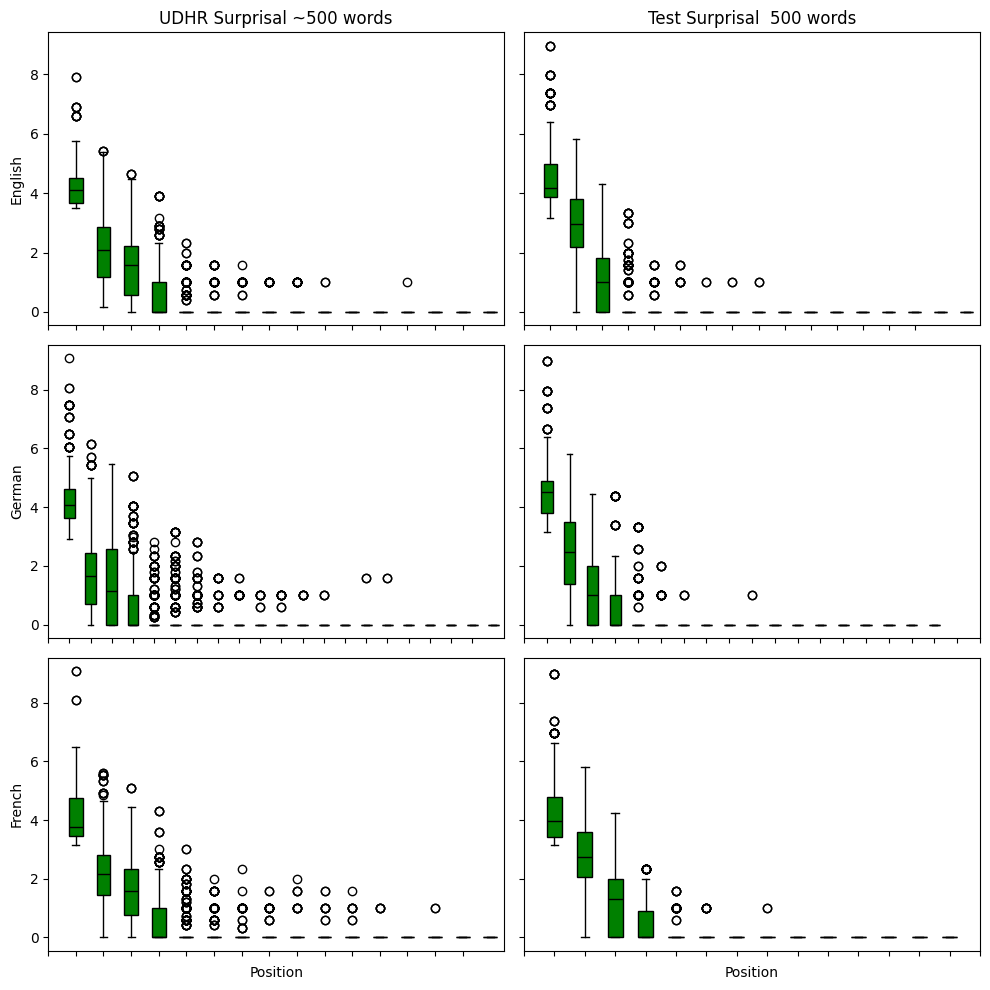

In [ ]:
#@title Plot Surprisal Across Positions

# Compare to sub-sampled Test Set surprisals
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'
with open(os.path.join(data_folder, 'Uniform', 'All_Langs_Test_Uniform.pickle'), 'rb') as f:
  uniform_ds = pickle.load(f)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharey='row')
for i, lang in enumerate(['English','German','French']):
  test_df = test_surprisals[lang]
  test_surp = [test_df[test_df['position']==pos]['surprisal'] for pos in test_df['position'].unique()]
  udhr_df = udhr_surprisals[lang]
  udhr_surp = [udhr_df[udhr_df['position']==pos]['surprisal'] for pos in udhr_df['position'].unique()]

  ax[i,0].boxplot(udhr_surp, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,1].boxplot(test_surp, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_xticks(range(len(udhr_surp)),[])
  ax[i,1].set_xticks(range(len(udhr_surp)),[])
ax[0,0].set_title('UDHR Surprisal ~500 words')
ax[0,1].set_title('Test Surprisal  500 words')
ax[0,0].set_ylabel('English')
ax[1,0].set_ylabel('German')
ax[2,0].set_ylabel('French')
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
plt.tight_layout()
plt.savefig('UDHR (uncased) and Test (sampled) Surprisals.png')
plt.show()

## Run Model

In [ ]:
#@title Model Definitions
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CommonModel(nn.Module):
  '''
  This defines the fit, evaluate, and predict functions that are shared between all models.
  It is not instantiated directly but inherited by all other model classes.

  Methods:
    fit: Train model on train dataloader and evaluate on validation dataloader.
         Prints training losses and validation losses. No return.

    evaluate: Calculates losses on evaluation dataloader, prints and returns average loss across whole dataset.

    predict: Returns predictions and true labels from test dataloader.
             Predictions are list of word length with probabilities of each position being syllable break.
             True labels are binary list of word length, with 1 for syllable break and 0 otherwise.
  '''
  def __init__(self):
    super().__init__()

  def fit(self, train_dl, val_dl, epochs, loss_fn, lstm=False):
    if loss_fn == 'bce':
      self.loss_fn = nn.BCEWithLogitsLoss()
    elif loss_fn == 'focal':
      self.loss_fn = sigmoid_focal_loss
    else:
      raise ValueError("loss_fn must either be 'bce' or 'focal'.")
    optimizer = torch.optim.AdamW(self.parameters())
    for epoch in range(epochs):
      running_loss = 0.0
      syllables = 0
      for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        prediction = self.forward(surprisal)
        loss = self.loss_fn(prediction, syll)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0 and i != 0:
          print(f'{loss}, [{epoch + 1}, {i + 1:5d}] loss: {running_loss/(i+1)}')
      print()

      val_loss = self.evaluate(val_dl, lstm=lstm)
      print('Validation Loss')
      print(val_loss)
      print()

    return running_loss / (i+1)

  def evaluate(self, val_dl, lstm=False):
    losses = []
    syllables = 0
    with torch.no_grad():
      for data in val_dl:
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        prediction = self.forward(surprisal)
        loss = self.loss_fn(prediction, syll)
        losses.append(loss)

    return torch.Tensor(losses).mean()

  def predict(self, test_dl, separate_words=False, lstm=False):
    with torch.no_grad():
      self.eval()
      predictions = []
      syllables = []
      activation = nn.Sigmoid()

      for data in test_dl:
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        pred = activation(self.forward(surprisal)).detach().cpu()

        if separate_words:
          if lstm:
            for i in range(syll.shape[0]):
              syllables.append(syll[i,:,0])
              predictions.append(pred[i,:,0])
          else:
            for i in range(syll.shape[0]):
              syllables.append(syll[i,0])
              predictions.append(pred[i,0])
        else:
          syll = syll.cpu().flatten().tolist()
          pred = activation(self.forward(surprisal)).flatten().tolist()
          syllables += syll
          predictions += pred

    return predictions, syllables

  def fit_wandb(self, train_dl, val_dl, epochs, loss_fn, run_name=None, project_name='Decipherment Project', lstm=False):
    if loss_fn == 'bce':
      self.loss_fn = nn.BCEWithLogitsLoss()
    elif loss_fn == 'focal':
      self.loss_fn = sigmoid_focal_loss
    else:
      raise ValueError("loss_fn must either be 'bce' or 'focal'.")

    if run_name:
      name = run_name
    elif lstm is False:
      name = f'{self.architecture}_{self.n_gram}gram_{self.d_hidden}hidden_{self.n_layers}layers_{loss_fn}_loss'
    elif self.bidirectional is True:
      name = f'{self.architecture}_{self.d_hidden}hidden_{self.n_layers}layers_bidirectional_{loss_fn}_loss'
    else:
      name = f'{self.architecture}_{self.d_hidden}hidden_{self.n_layers}layers_unidirectional_{loss_fn}_loss'

    if lstm is False:
      config = {'architecture' : self.architecture,
                'n_gram' : self.n_gram,
                'd_hidden' : self.d_hidden,
                'n_layers' : self.n_layers,
                'loss_fn' : loss_fn,
                'size' : self.size}
    else:
      config = {'architecture' : self.architecture,
                'd_hidden' : self.d_hidden,
                'n_layers' : self.n_layers,
                'loss_fn' : loss_fn,
                'size' : self.size,
                'bidirectional' : self.bidirectional}

    wandb.init(project=project_name,
               name=name,
               config=config)

    for epoch in range(epochs):
      train_loss = self.fit(train_dl, val_dl, epochs=1, loss_fn=loss_fn, lstm=lstm)
      val_loss = self.evaluate(val_dl, lstm=lstm)
      wandb.log({'train_loss': train_loss, 'val_loss': val_loss})


class NgramFNN(CommonModel):
  '''
  Feedforward Neural Network (FNN) that takes an ngram of size n_gram and feeds the surprisals through
  n hidden layers (n_layers) each of dimension d (d_hidden).

  *NOTE* This is implemented using Conv1d layers, however because we lock the kernel_size of all hidden
  layers and the output layer to 1, this is equivalent to a Feedforward Network operating over ngrams.

  Params:
    n_gram:   Size of ngram window to look over
    d_hidden: Dimensionality of hidden layers (equivalent to n_filters in NgramCNN)
    n_layers: Number of hidden layers (not including input and output layers)

  Returns:
    x: List of length of original word showing log-odds for each position to be a syllable break.
       This is converted to probabilities using sigmoid activation in "predict" method.

  Methods:
    See parent class "CommonModel"
  '''
  def __init__(self, n_gram, d_hidden, n_layers):
    super().__init__()

    self.n_gram = n_gram
    self.d_hidden = d_hidden
    self.n_layers = n_layers
    self.architecture = 'fnn'

    self.input_ = nn.Conv1d(in_channels=1, out_channels=d_hidden, kernel_size=n_gram, padding='same')
    self.output = nn.Conv1d(in_channels=d_hidden, out_channels=1, kernel_size=1)
    self.hidden = nn.ModuleList()
    for n in range(n_layers):
      self.hidden.append(nn.Conv1d(in_channels=d_hidden, out_channels=d_hidden, kernel_size=1))
      self.hidden.append(nn.GELU())
    self.activation = nn.GELU()

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x = self.input_(x)
    x = self.activation(x)
    for hidden in self.hidden:
      x = hidden(x)
    x = self.output(x)

    return x


class NgramCNN(CommonModel):
  '''
  Identical to the NgramFNN, except that it applies the same window size (n_gram) to the hidden layers
  as it does to the input layer, resulting in a kind of "recursive" ngram structure that incorporates
  information from more and more neighboring ngrams the deeper the model goes. This is the same as our
  original CNN model.

  Params:
    n_gram:    Size of ngram window to look over
    n_filters: Number of filters to pass over each layer
    n_layers:  Number of hidden layers (not including input and output layers)

  Returns:
    x: List of length of original word showing log-odds for each position to be a syllable break.
       This is converted to probabilities using sigmoid activation in "predict" method.

  Methods:
    See parent class "CommonModel"
  '''
  def __init__(self, n_gram, n_filters, n_layers):
    super().__init__()

    self.n_gram = n_gram
    self.d_hidden = n_filters
    self.n_layers = n_layers
    self.architecture = 'cnn'

    self.input_ = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=n_gram, padding='same')
    self.output = nn.Conv1d(in_channels=n_filters, out_channels=1, kernel_size=1)
    self.hidden = nn.ModuleList()
    for n in range(n_layers):
      self.hidden.append(nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=n_gram, padding='same'))
      self.hidden.append(nn.GELU())
    self.activation = nn.GELU()

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x = self.input_(x)
    x = self.activation(x)
    for hidden in self.hidden:
      x = hidden(x)
    x = self.output(x)

    return x


class NgramLSTM(CommonModel):
  def __init__(self,
               hidden_size=5,
               n_layers=1,
               bidirectional=True):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,
                        hidden_size=hidden_size,
                        num_layers=n_layers,
                        bias=True,
                        batch_first=True,
                        dropout=0.0,
                        bidirectional=bidirectional,
                        proj_size=0,
                        device=None,
                        dtype=None)

    self.d_hidden = hidden_size
    self.n_layers = n_layers
    self.architecture = 'lstm'
    self.bidirectional=bidirectional

    if bidirectional:
      self.linear = nn.Linear(in_features= 2 * hidden_size, out_features=1)
    else:
      self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x, hidden_out = self.lstm(x)
    x = self.linear(x)

    return x

In [ ]:
#@title Dataset Definition

class WordDataset(Dataset):
  def __init__(self, dataframe):
    super().__init__()
    self.dataframe = dataframe

  def __len__(self):
    return self.dataframe['word_id'].max()

  def __getitem__(self, idx):
    word_id = idx + 1
    word_df = self.dataframe[self.dataframe['word_id']==word_id]

    surprisal = word_df['surprisal'].to_numpy()
    syll = word_df['syllable'].to_numpy()
    lang = word_df['lang'].iloc[0]
    word = ''.join(word_df['segment'].tolist())

    return surprisal, syll, lang, word

In [ ]:
#@title Load Language Models
model_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Models/Original/LOO'

models = dict()

for model in ['FNN', 'CNN', 'LSTM']:
  models[model] = dict()
  if model == 'FNN':
    base_model = NgramFNN(n_gram=7, d_hidden=15, n_layers=5).to(device)
  elif model == 'CNN':
    base_model = NgramCNN(n_gram=7, n_filters=15, n_layers=10).to(device)
  else:
    base_model = NgramLSTM(hidden_size=15, n_layers=10, bidirectional=True).to(device)
  for lang in ['English', 'German', 'French']:
    base_model.load_state_dict(torch.load(os.path.join(model_folder, f'LOO_{lang}_{model}_Original.pt'),
                                          map_location=device, weights_only=True))
    models[model][lang] = base_model

In [ ]:
#@title Load DataLoaders
udhr_datasets = dict()
udhr_dataloaders = dict()
test_datasets = dict()
test_dataloaders = dict()

for lang in ['English','German','French']:
  udhr_datasets[lang] = WordDataset(udhr_surprisals[lang])
  udhr_dataloaders[lang] = DataLoader(udhr_datasets[lang], batch_size=1, shuffle=False)
  test_datasets[lang] = WordDataset(test_surprisals[lang])
  test_dataloaders[lang] = DataLoader(test_datasets[lang], batch_size=1, shuffle=False)

In [ ]:
#@title Make Predictions
preds_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Predictions/UDHR/Uncased'

udhr_predictions = dict()
test_predictions = dict()

for model in ['FNN', 'CNN', 'LSTM']:
  udhr_predictions[model] = dict()
  test_predictions[model] = dict()
  for lang, code in [('English','en'), ('German','de'), ('French','fr')]:
    udhr_ds = udhr_datasets[lang]
    udhr_dl = udhr_dataloaders[lang]
    test_ds = test_datasets[lang]
    test_dl = test_dataloaders[lang]
    test_model = models[model][lang]
    udhr_preds, udhr_sylls = test_model.predict(udhr_dl, separate_words=True, lstm=(model=='LSTM'))
    test_preds, test_sylls = test_model.predict(test_dl, separate_words=True, lstm=(model=='LSTM'))

    # Form predictions into Pandas DataFrame with exactly same format as original predictions
    udhr_preds = [entry for row in udhr_preds for entry in row.cpu().numpy()]
    udhr_sylls = [entry for row in udhr_sylls for entry in row.cpu().numpy().astype(int)]
    udhr_langs = [entry[2] for entry in udhr_ds for i in range(len(entry[1]))]
    udhr_ids = [id for id in range(len(udhr_ds)) for j in range(len(udhr_ds[id][1]))]
    udhr_positions = [i for entry in udhr_ds for i in range(len(entry[1]))]
    udhr_segments = [segment for entry in udhr_ds for segment in entry[3]]

    udhr_predictions[model][lang] = pd.DataFrame({'Predictions':udhr_preds, 'Ground Truths':udhr_sylls, 'Languages':udhr_langs,
                                              'Word Indices':udhr_ids, 'Positions':udhr_positions, 'Segments':udhr_segments})
    #udhr_predictions[model][lang].to_csv(os.path.join(preds_folder, f'UDHR_LOO_{lang}_{model}_Original_Uncased.csv'), index=False)


    test_preds = [entry for row in test_preds for entry in row.cpu().numpy()]
    test_sylls = [entry for row in test_sylls for entry in row.cpu().numpy().astype(int)]
    test_langs = [entry[2] for entry in test_ds for i in range(len(entry[1]))]
    test_ids = [id for id in range(len(test_ds)) for j in range(len(test_ds[id][1]))]
    test_positions = [i for entry in test_ds for i in range(len(entry[1]))]
    test_segments = [segment for entry in test_ds for segment in entry[3]]

    test_predictions[model][lang] = pd.DataFrame({'Predictions':test_preds, 'Ground Truths':test_sylls, 'Languages':test_langs,
                              'Word Indices':test_ids, 'Positions':test_positions, 'Segments':test_segments})
    #test_predictions[model][lang].to_csv(f'LOO_{lang}_{model}_Small_Test.csv'), index=False)

print('UDHR Predictions')
display(udhr_predictions['FNN']['English'])
print()
print('Test Predictions')
display(test_predictions['FNN']['English'])

UDHR Predictions


,Predictions,Ground Truths,Languages,Word Indices,Positions,Segments
0,0.860477,0,English,0,0,a
1,0.998634,0,English,1,0,a
2,0.012902,0,English,1,1,c
3,0.461933,0,English,1,2,c
4,0.303518,0,English,1,3,e
...,...,...,...,...,...,...
3347,0.039706,0,English,480,1,o
3348,0.537261,0,English,480,2,r
3349,0.479940,0,English,480,3,t
3350,0.389408,0,English,480,4,h



Test Predictions


,Predictions,Ground Truths,Languages,Word Indices,Positions,Segments
0,0.998415,1,English,0,0,@
1,0.023628,1,English,0,1,b
2,0.619972,0,English,0,2,l
3,0.271285,0,English,0,3,2
4,0.191812,0,English,0,4,_
...,...,...,...,...,...,...
3576,0.176785,0,English,499,2,Q
3577,0.478828,0,English,499,3,s
3578,0.311570,1,English,499,4,w
3579,0.182641,0,English,499,5,$


## Evaluate Results

In [ ]:
ortho = dict()
ortho['English'] = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/english_celex_database_updated.txt', delimiter='\t').rename
ortho['German'] = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/german_celex_database_updated.txt', delimiter='\t')
ortho['French'] = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/french_lexique_database_updated.txt', delimiter='\t')


for lang in ['English','German','French']:
  segments = [''.join(test_predictions['FNN'][lang].loc[i,'Segments'].tolist()) for i in range(1,501)]
  ipa = [''.join(test_predictions['FNN'][lang].loc[i,'IPA'].tolist()) for i in range(1,501)]

english_segments = [''.join(test_predictions['FNN']['English'].loc[i,'Segments'].tolist()) for i in range(1,501)]
english_ipa = [''.join(test_predictions['FNN']['English'].loc[i,'IPA'].tolist()) for i in range(1,501)]

english_df = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/english_celex_database_updated.txt', delimiter='\t')
english_df['phone_full'] = english_df['phone_full'].apply(lambda x: re.sub("[%'-]",'',x))
english_df = english_df[english_df['phone_full'].isin(english_segments)]
english_df = english_df.drop_duplicates(subset='phone_full')
english_df = english_df.set_index('phone_full')
english_words = [english_df.loc[word,'Lemma'] for word in english_segments]

with open('English Test Lexicon 500 words.txt', 'w') as f:
  f.write(f'{"X-sampa":<20} {"IPA":<20} Orthography\n\n')
  for sampa, phone, word in list((zip(english_segments, english_ipa, english_words))):
    f.write(f'{sampa:<20} {phone:<20} {word}\n')

german_segments = [''.join(test_predictions['FNN']['German'].loc[i,'Segments'].tolist()) for i in range(1,501)]
german_ipa = [''.join(test_predictions['FNN']['German'].loc[i,'IPA'].tolist()) for i in range(1,501)]

german_df = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/german_celex_database_updated.txt', delimiter='\t')
german_df['phone_full'] = german_df['phone_full'].apply(lambda x: re.sub("[%'-]",'',x))
german_df = german_df[german_df['phone_full'].isin(german_segments)]
german_df = german_df.drop_duplicates(subset='phone_full')
german_df = german_df.set_index('phone_full')
german_words = [german_df.loc[word,'Head'] for word in german_segments]

with open('German Test Lexicon 500 words.txt', 'w') as f:
  f.write(f'{"X-sampa":<20} {"IPA":<20} Orthography\n\n')
  for sampa, phone, word in list(zip(german_segments, german_ipa, german_words)):
    f.write(f'{sampa:<20} {phone:<20} {word}\n')

french_segments = [''.join(test_predictions['FNN']['French'].loc[i,'Segments'].tolist()) for i in range(1,501)]
french_ipa = [''.join(test_predictions['FNN']['French'].loc[i,'IPA'].tolist()) for i in range(1,501)]

french_df = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/french_lexique_database_updated.txt', delimiter='\t')
french_df['phone_full'] = french_df['phone_full'].apply(lambda x: re.sub("[%'-]",'',x))
french_df = french_df[french_df['phone_full'].isin(french_segments)]
french_df = french_df.drop_duplicates(subset='phone_full')
french_df = french_df.set_index('phone_full')
french_words = [french_df.loc[word,'c1_ortho'] for word in french_segments]

with open('French Test Lexicon 500 words.txt', 'w') as f:
  f.write(f'{"X-sampa":<20} {"IPA":<20} Orthography\n\n')
  for sampa, phone, word in list(zip(french_segments, french_ipa, french_words)):
    f.write(f'{sampa:<20} {phone:<20} {word}\n')

In [ ]:
#@title Threshold Predictions, Add Syllable Breaks
def syllabify(entry, syllables, segments):
  if entry[syllables] == 0 or entry['Positions'] == 1:
    return entry[segments]
  else:
    return '^' + entry[segments]

# Function to convert X-sampa to IPA, skipping unknown characters
def sampa_to_ipa(segments):
  exceptions = {'_':'ʤ', '#':'ɑː', '$':'ɔː', ')':'ɛː', '/':'œ', '+':'pf'}
  try:
    return sampa2uni(segments)
  except:
    ipa = []
    for segment in segments:
      try: ipa.append(sampa2uni(segment))
      except: ipa.append(exceptions[segment])
    return ''.join(ipa)

# Load thresholds from validation runs on other languages
results_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'
with open(os.path.join(results_original, 'LOO_Thresholds_NoHead')) as f:
  loo_thresholds_nohead = json.loads(f.read())

for model in ['FNN', 'CNN', 'LSTM']:
  for lang in ['English','German','French']:
    threshold = loo_thresholds_nohead[model][lang]
    udhr_predictions[model][lang][['Word Indices','Positions']] += 1
    udhr_predictions[model][lang]['Surprisals'] = udhr_surprisals[lang]['surprisal']
    udhr_predictions[model][lang]['Thresholds'] = threshold
    udhr_predictions[model][lang]['Pred Syllables'] = (udhr_predictions[model][lang]['Predictions'] >= threshold).astype('int')
    udhr_predictions[model][lang]['Pred Segments'] = udhr_predictions[model][lang].apply(syllabify, syllables='Pred Syllables', segments='Segments', axis=1)
    udhr_predictions[model][lang] = udhr_predictions[model][lang][['Word Indices', 'Positions', 'Predictions', 'Pred Syllables', 'Ground Truths',
                                                                   'Surprisals', 'Languages', 'Thresholds', 'Segments', 'Pred Segments']]
    udhr_predictions[model][lang] = udhr_predictions[model][lang].set_index('Word Indices')

    test_predictions[model][lang][['Word Indices','Positions']] += 1
    test_predictions[model][lang]['Surprisals'] = test_surprisals[lang]['surprisal']
    test_predictions[model][lang]['Thresholds'] = threshold
    test_predictions[model][lang]['Pred Syllables'] = (test_predictions[model][lang]['Predictions'] >= threshold).astype('int')
    test_predictions[model][lang]['IPA'] = test_predictions[model][lang]['Segments'].apply(sampa_to_ipa)
    test_predictions[model][lang]['Pred Segments'] = test_predictions[model][lang].apply(syllabify, syllables='Pred Syllables', segments='IPA', axis=1)
    test_predictions[model][lang]['True Segments'] = test_predictions[model][lang].apply(syllabify, syllables='Ground Truths', segments='IPA', axis=1)
    test_predictions[model][lang] = test_predictions[model][lang][['Word Indices', 'Positions', 'Predictions', 'Pred Syllables', 'Ground Truths',
                                                                   'Surprisals', 'Languages', 'Thresholds', 'Segments', 'IPA', 'Pred Segments',
                                                                   'True Segments']]
    test_predictions[model][lang] = test_predictions[model][lang].set_index('Word Indices')

print('UDHR Predictions')
display(udhr_predictions['FNN']['English'])
print()
print('Test Predictions')
display(test_predictions['FNN']['English'])

UDHR Predictions


,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Thresholds,Segments,Pred Segments
Word Indices,,,,,,,,,
1,1,0.860477,1,0,3.483628,English,0.38,a,a
2,1,0.998634,1,0,3.483628,English,0.38,a,a
2,2,0.012902,0,0,2.104337,English,0.38,c,c
2,3,0.461933,1,0,1.000000,English,0.38,c,^c
2,4,0.303518,0,0,1.321928,English,0.38,e,e
...,...,...,...,...,...,...,...,...,...
481,2,0.039706,0,0,1.523562,English,0.38,o,o
481,3,0.537261,1,0,0.192645,English,0.38,r,^r
481,4,0.479940,1,0,1.807355,English,0.38,t,^t



Test Predictions


,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Thresholds,Segments,IPA,Pred Segments,True Segments
Word Indices,,,,,,,,,,,
1,1,0.998415,1,1,4.965784,English,0.38,@,ə,ə,ə
1,2,0.023628,0,1,2.415037,English,0.38,b,b,b,^b
1,3,0.619972,1,0,0.584963,English,0.38,l,l,^l,l
1,4,0.271285,0,0,1.000000,English,0.38,2,ø,ø,ø
1,5,0.191812,0,0,0.000000,English,0.38,_,ʤ,ʤ,ʤ
...,...,...,...,...,...,...,...,...,...,...,...
500,3,0.176785,0,0,1.807355,English,0.38,Q,ɒ,ɒ,ɒ
500,4,0.478828,1,0,0.000000,English,0.38,s,s,^s,s
500,5,0.311570,0,1,1.000000,English,0.38,w,w,w,^w


In [ ]:
#@title Extract All Syllables

def get_word(word_id, dataframe):
  return ''.join(dataframe.loc[[word_id], 'Segments'].tolist())

def get_splits(word_id, dataframe):
  return ''.join(dataframe.loc[[word_id], 'Pred Segments'].tolist()).replace('^','_')

# Make dictionary for each language mapping each word in the lexicon to its syllabified form
udhr_dict = dict()
test_dict = dict()

for model in ['FNN','CNN','LSTM']:
  udhr_dict[model] = dict()
  test_dict[model] = dict()
  for lang in ['English','German','French']:
    udhr_dict[model][lang] = {get_word(id, udhr_predictions[model][lang]):get_splits(id, udhr_predictions[model][lang])
                                       for id in udhr_predictions[model][lang].index.unique()}
    test_dict[model][lang] = {get_word(id, test_predictions[model][lang]):get_splits(id, test_predictions[model][lang])
                                       for id in test_predictions[model][lang].index.unique()}

In [ ]:
#@title Extract Syllables by Position

udhr_words = dict()
udhr_syllables = dict()
test_words = dict()
test_pred_syllables = dict()
test_true_syllables = dict()

for model in ['FNN','CNN','LSTM']:
  udhr_words[model] = dict()
  udhr_syllables[model] = dict()
  test_words[model] = dict()
  test_pred_syllables[model] = dict()
  test_true_syllables[model] = dict()
  for lang in ['English','German','French']:
    udhr_ids = []
    udhr_segments = []
    udhr_preds = []
    for id in udhr_predictions[model][lang].index.unique():
      df = udhr_predictions[model][lang].loc[[id]]
      udhr_ids.append(id)
      udhr_segments.append(''.join(df['Segments'].tolist()))
      udhr_preds.append(''.join(df['Pred Segments'].tolist()).split('^'))
    udhr_words[model][lang] = pd.DataFrame({'Word Indices':udhr_ids, 'Word':udhr_segments, 'Pred Syllables':udhr_preds}).set_index('Word Indices')
    udhr_ids = [[id]*len(pred) for id,pred in zip(udhr_ids, udhr_preds)]
    udhr_ids = [i for id in udhr_ids for i in id]
    udhr_pos = [i+1 for pred in udhr_preds for i, syll in enumerate(pred)]
    udhr_sylls = [syll for pred in udhr_preds for syll in pred]
    udhr_lengths = [len(syll) for syll in udhr_sylls]
    udhr_syllables[model][lang] = pd.DataFrame({'Positions':udhr_pos, 'Syllables':udhr_sylls,'Lengths':udhr_lengths,
                                                'Word Indices':udhr_ids}).set_index('Positions')
    test_ids = []
    test_segments = []
    test_preds = []
    test_trues = []
    pred_matches = []
    true_matches = []
    for id in test_predictions[model][lang].index.unique():
      df = test_predictions[model][lang].loc[[id]]
      test_ids.append(id)
      test_segments.append(''.join(df['IPA'].tolist()))
      test_preds.append(''.join(df['Pred Segments'].tolist()).split('^'))
      test_trues.append(''.join(df['True Segments'].tolist()).split('^'))
      pred_sylls = df['Pred Syllables'].tolist()
      true_sylls = df['Ground Truths'].tolist()
      pred_breaks = [i for i, num in enumerate(pred_sylls) if num==1]
      pred_slices = [slice(pair[0],pair[1]+1) for pair in pairwise(pred_breaks)]
      true_breaks = [i for i, num in enumerate(true_sylls) if num==1]
      true_slices = [slice(pair[0],pair[1]+1) for pair in pairwise(true_breaks)]
      pred_matches.append([pred_sylls[s]==true_sylls[s] for s in pred_slices] + [pred_sylls[pred_breaks[-1]:]==true_sylls[pred_breaks[-1]:]])
      true_matches.append([true_sylls[s]==pred_sylls[s] for s in true_slices] + [true_sylls[true_breaks[-1]:]==pred_sylls[true_breaks[-1]:]])

    test_words[model][lang] = pd.DataFrame({'Word Indices':test_ids, 'Word':test_segments, 'True Syllables':test_trues, 'Pred Syllables':test_preds,
                                            'True Matches':true_matches, 'Pred Matches':pred_matches}).set_index('Word Indices')
    test_pred_ids = [[id]*len(pred) for id,pred in zip(test_ids, test_preds)]
    test_pred_ids = [i for id in test_pred_ids for i in id]
    test_pred_pos = [i+1 for pred in test_preds for i, syll in enumerate(pred)]
    test_pred_sylls = [syll for pred in test_preds for syll in pred]
    test_pred_lengths = [len(syll) for syll in test_pred_sylls]
    test_pred_syllables[model][lang] = pd.DataFrame({'Positions':test_pred_pos, 'Syllables':test_pred_sylls, 'Lengths':test_pred_lengths,
                                                     'Word Indices':test_pred_ids}).set_index('Positions')

    test_true_ids = [[id]*len(true) for id,true in zip(test_ids, test_trues)]
    test_true_ids = [i for id in test_true_ids for i in id]
    test_true_pos = [i+1 for true in test_trues for i, syll in enumerate(true)]
    test_true_sylls = [syll for true in test_trues for syll in true]
    test_true_lengths = [len(syll) for syll in test_true_sylls]
    test_true_syllables[model][lang] = pd.DataFrame({'Positions':test_true_pos, 'Syllables':test_true_sylls, 'Lengths':test_true_lengths,
                                                     'Word Indices':test_true_ids}).set_index('Positions')

print('UDHR')
display(udhr_words['FNN']['English'])
print()
display(udhr_syllables['FNN']['English'])
print()
print()
print('Test Set')
display(test_words['FNN']['English'])
print()
display(test_pred_syllables['FNN']['English'])
print()
display(test_true_syllables['FNN']['English'])

UDHR


,Word,Pred Syllables
Word Indices,,
1,a,[a]
2,access,"[ac, cess]"
3,accessible,"[ac, c, es, sible]"
4,accordance,"[ac, c, or, dance]"
5,according,"[ac, c, or, ding]"
...,...,...
477,works,"[wo, r, ks]"
478,world,"[wo, r, ld]"
479,worship,"[wo, r, ship]"


,Syllables,Lengths,Word Indices
Positions,,,
1,a,1,1
1,ac,2,2
2,cess,4,2
1,ac,2,3
2,c,1,3
...,...,...,...
3,th,2,480
1,wo,2,481
2,r,1,481




Test Set


,Word,True Syllables,Pred Syllables,True Matches,Pred Matches
Word Indices,,,,,
1,əbløʤ,"[ə, bløʤ]","[əb, løʤ]","[False, False]","[False, False]"
2,lɛts,[lɛts],[lɛts],[True],[True]
3,strɛnjœslɪ,"[strɛn, jœs, lɪ]","[str, ɛnjœslɪ]","[False, False, False]","[False, False]"
4,kəmplɨnɪŋ,"[kəm, plɨ, nɪŋ]",[kəmplɨnɪŋ],"[False, False, False]",[False]
5,ɡænɪt,"[ɡæ, nɪt]",[ɡænɪt],"[False, False]",[False]
...,...,...,...,...,...
496,ɪndɪfrənt,"[ɪn, dɪ, frənt]","[ɪn, dɪfrənt]","[True, False, False]","[True, False]"
497,lɪŋ,[lɪŋ],[lɪŋ],[True],[True]
498,dɪsəpruvɪŋ,"[dɪs, ə, pru, vɪŋ]","[dɪs, əpruvɪŋ]","[True, False, False, False]","[True, False]"


,Syllables,Lengths,Word Indices
Positions,,,
1,əb,2,1
2,løʤ,3,1
1,lɛts,4,2
1,str,3,3
2,ɛnjœslɪ,7,3
...,...,...,...
1,dɪs,3,498
2,əpruvɪŋ,7,498
1,fəɡɪvnɪs,8,499


{'FNN': {'English':           Syllables  Lengths  Word Indices
  Positions                                 
  1                 ə        1             1
  2              bløʤ        4             1
  1              lɛts        4             2
  1             strɛn        5             3
  2               jœs        3             3
  ...             ...      ...           ...
  1                fə        2           499
  2               ɡɪv        3           499
  3               nɪs        3           499
  1              krɒs        4           500
  2              wɔːk        4           500
  
  [1396 rows x 3 columns],
  'German':           Syllables  Lengths  Word Indices
  Positions                                 
  1               hɛr        3             1
  2               for        3             1
  3                ̩i        2             1
  4                ən        2             1
  1               vɶn        3             2
  ...             ...      ...           .

TypeError: 'NoneType' object is not subscriptable

In [ ]:
display(test_true_syllables['FNN']['English'])

,Syllables,Lengths,Word Indices
Positions,,,
1,ə,1,1
2,bløʤ,4,1
1,lɛts,4,2
1,strɛn,5,3
2,jœs,3,3
...,...,...,...
1,fə,2,499
2,ɡɪv,3,499
3,nɪs,3,499


In [ ]:
#@title Extract Unique Syllables by Position

unique_preds = dict()

for lang in ['English','German','French']:
  pred_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos],['Syllables','Lengths']].reset_index()
    pred_df['Count'] = pred_df['Syllables']
    pred_df = pred_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Count':'count'})
    #pred_df = pred_df[pred_df['Count']>10].set_index('Positions')
    pred_df = pred_df.set_index('Positions')
    pred_list.append(pred_df)
  unique_preds[lang] = pd.concat(pred_list)

display(unique_preds['English'])

,Syllables,Lengths,Count
Positions,,,
1,a,1,1
1,ac,2,2
1,acc,3,3
1,achi,4,1
1,achieve,7,1
...,...,...,...
5,nation,6,1
5,ned,3,1
5,tu,2,2


In [ ]:
#@title Extract Common Syllables by Position

common_preds = dict()  # We threshold predicted syllables by count

for lang in ['English','German','French']:
  pred_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos],['Syllables','Lengths']].reset_index()
    pred_df['Count'] = pred_df['Syllables']
    pred_df = pred_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Count':'count'})
    pred_df = pred_df[pred_df['Count']>2].set_index('Positions')
    #pred_df = pred_df.set_index('Positions')
    pred_list.append(pred_df)
  common_preds[lang] = pd.concat(pred_list)

display(common_preds['English'])

,Syllables,Lengths,Count
Positions,,,
1,acc,3,3
1,as,2,4
1,be,2,11
1,ch,2,8
1,co,2,16
...,...,...,...
3,r,1,4
3,ry,2,3
3,s,1,6


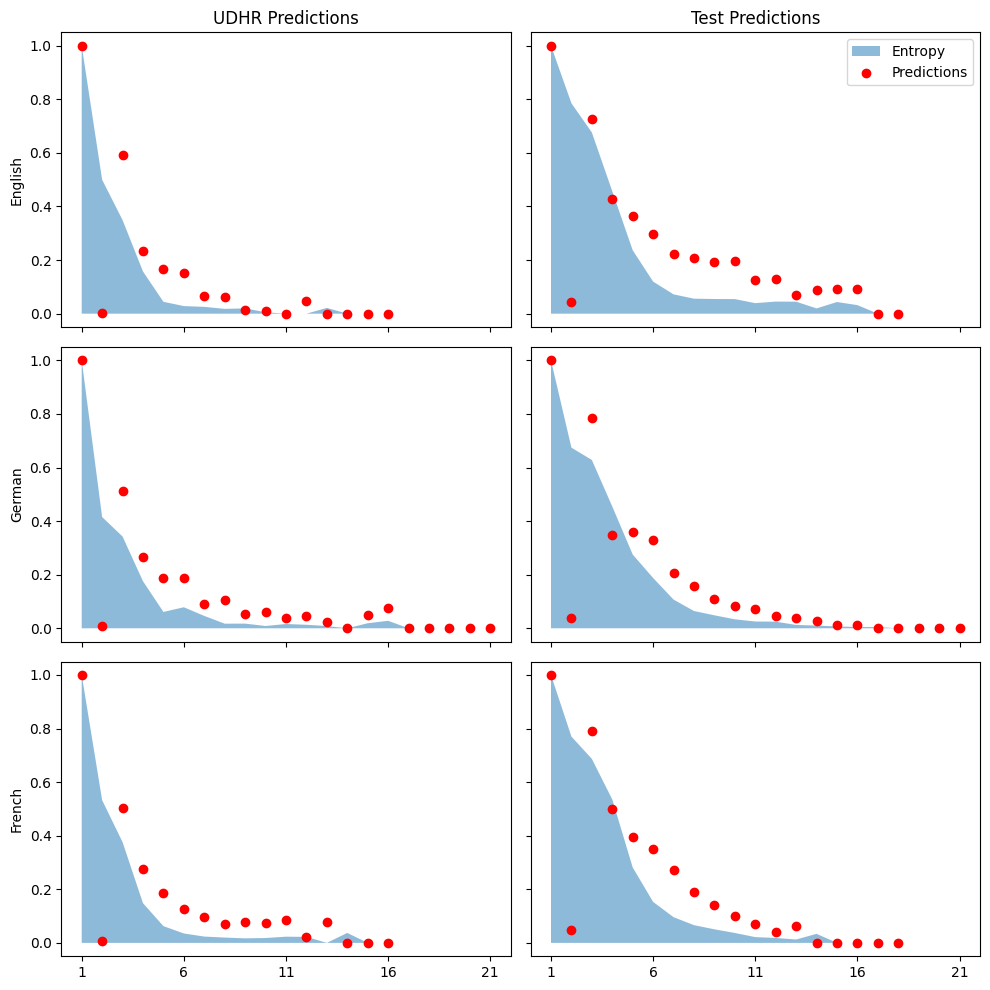

In [ ]:
#@title Plot Syllable Breaks by Position

# Folder Paths
results_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'
preds_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Predictions/Original'

# Load Test Result Thresholds
with open(os.path.join(results_original, 'LOO_Thresholds_NoHead')) as f:
  loo_thresholds_nohead = json.loads(f.read())

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey=True)
for i, (lang,code,df) in enumerate([('English','en',english_surprisal),('German','de',german_surprisal),('French','fr',french_surprisal)]):
  udhr_preds = predictions[lang]
  udhr_positions = udhr_preds['Positions'].unique()
  udhr_entropy = [udhr_preds[udhr_preds['Positions']==pos]['Surprisals'].mean() for pos in udhr_positions]
  udhr_entropy = udhr_entropy / max(udhr_entropy)
  udhr_sylls = [udhr_preds[udhr_preds['Positions']==pos]['Pred Syllables'].mean() for pos in udhr_positions]

  threshold = loo_thresholds_nohead['FNN'][lang]
  test_preds = pd.read_csv(os.path.join(preds_original, 'LOO', f'LOO_{lang}_FNN_Original.csv'))
  test_preds['Surprisals'] = [surprisal for entry in test_ds for surprisal in entry[0]]
  test_preds[['Word Indices','Positions']] +=1
  test_preds = test_preds[test_preds['Languages']==code]
  test_positions = test_preds['Positions'].unique()
  test_entropy = [test_preds[test_preds['Positions']==pos]['Surprisals'].mean() for pos in test_positions]
  test_entropy = test_entropy / max(test_entropy)
  test_sylls = [(test_preds[test_preds['Positions']==pos]['Predictions']>=threshold).mean() for pos in test_positions]
  ax[i,0].fill_between(udhr_positions, udhr_entropy, alpha=0.5)
  ax[i,0].scatter(udhr_positions, udhr_sylls, c='red')
  ax[i,1].fill_between(test_positions, test_entropy, alpha=0.5, label='Entropy')
  ax[i,1].scatter(test_positions, test_sylls, c='red', label='Predictions')
  ax[i,0].set_ylabel(lang)
ax[0,0].set_title('UDHR Predictions')
ax[0,1].set_title('Test Predictions')
ax[0,1].legend()
plt.xticks(range(1,22,5))
plt.tight_layout()
plt.savefig('UDHR Predictions (uncased).png')
plt.show()

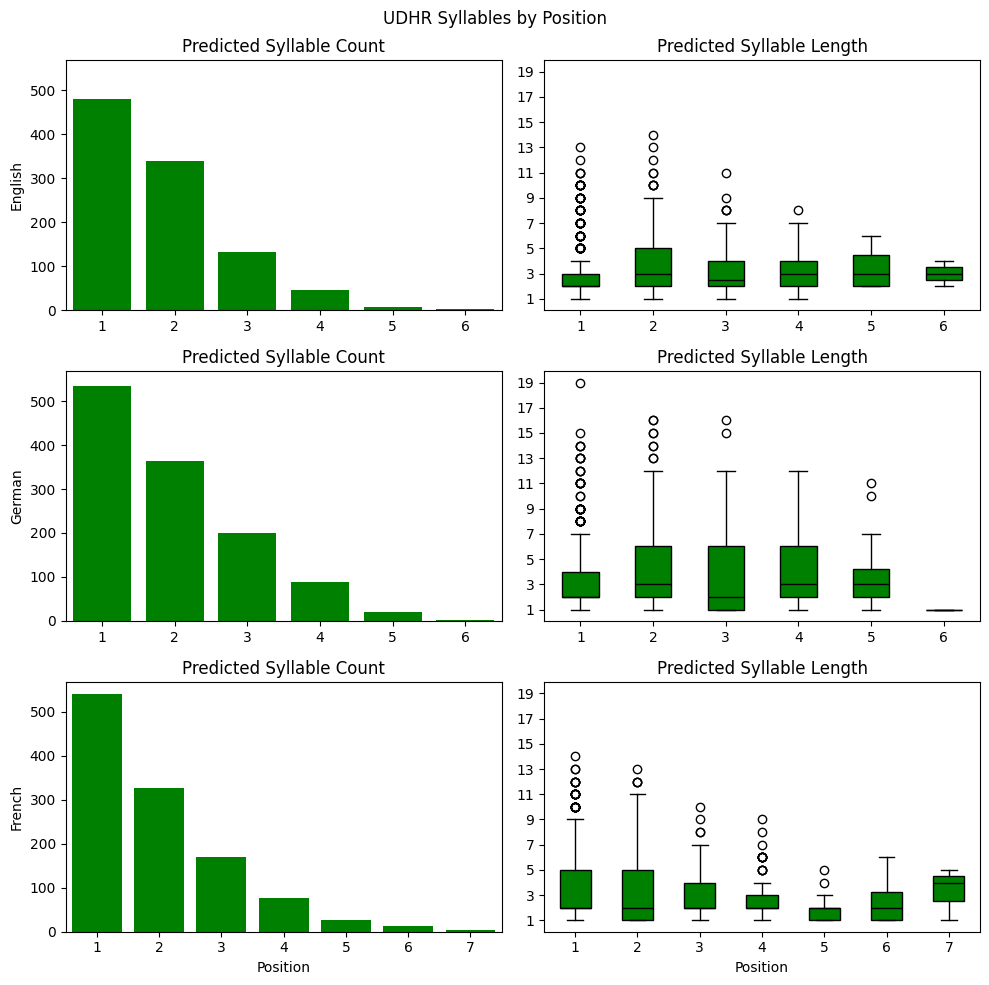

In [ ]:
#@title Plot Syllables by Position

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex='row', sharey='col')
max_len = 0
for i, lang in enumerate(['English','German','French']):
  pred_df = pred_syllables[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[pos,'Lengths'].tolist() for pos in pred_positions]
  max_pred = max([length for pred in pred_lengths for length in pred])
  max_len = max(max_len, max_pred)
  ax[i,0].bar(pred_positions, pred_count, color='green')
  ax[i,1].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_title(f'Predicted Syllable Count')
  ax[i,1].set_title(f'Predicted Syllable Length')
  ax[i,0].set_ylabel(lang)
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[0,1].set_yticks(range(1,max_len+1,2))
ax[1,1].set_yticks(range(1,max_len+1,2))
ax[2,1].set_yticks(range(1,max_len+1,2))
plt.suptitle(f'UDHR Syllables by Position')
plt.tight_layout()
plt.savefig(f'UDHR Syllables by Position (uncased).png')
plt.show()
print()

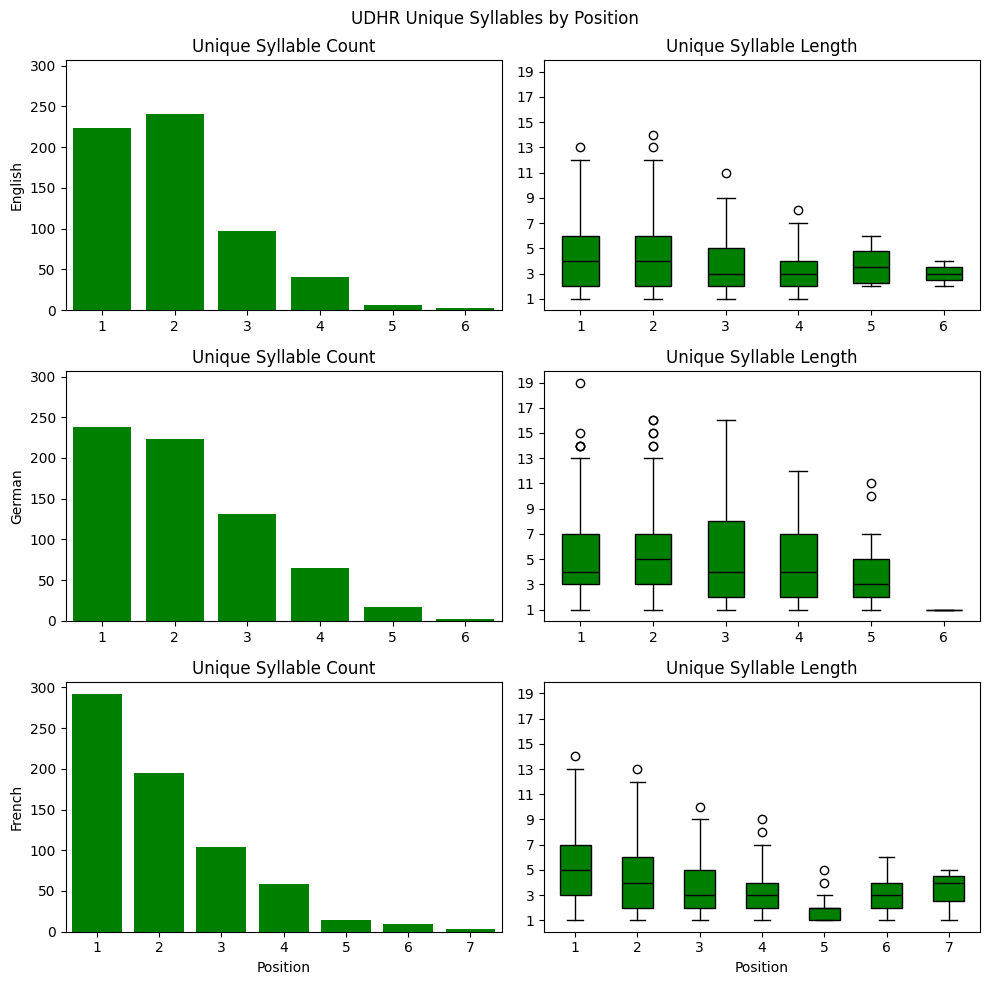

In [ ]:
#@title Plot Unique Syllables by Position

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex='row', sharey='col')
max_len = 0
for i, lang in enumerate(['English','German','French']):
  pred_df = unique_preds[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[pos,'Lengths'].tolist() for pos in pred_positions]
  max_pred = max([length for pred in pred_lengths for length in pred])
  max_len = max(max_len, max_pred)
  ax[i,0].bar(pred_positions, pred_count, color='green')
  ax[i,1].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_title(f'Unique Syllable Count')
  ax[i,1].set_title(f'Unique Syllable Length')
  ax[i,0].set_ylabel(lang)
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[0,1].set_yticks(range(1,max_len+1,2))
ax[1,1].set_yticks(range(1,max_len+1,2))
ax[2,1].set_yticks(range(1,max_len+1,2))
plt.suptitle(f'UDHR Unique Syllables by Position')
plt.tight_layout()
plt.savefig(f'UDHR Unique Syllables by Position (uncased).png')
plt.show()
print()

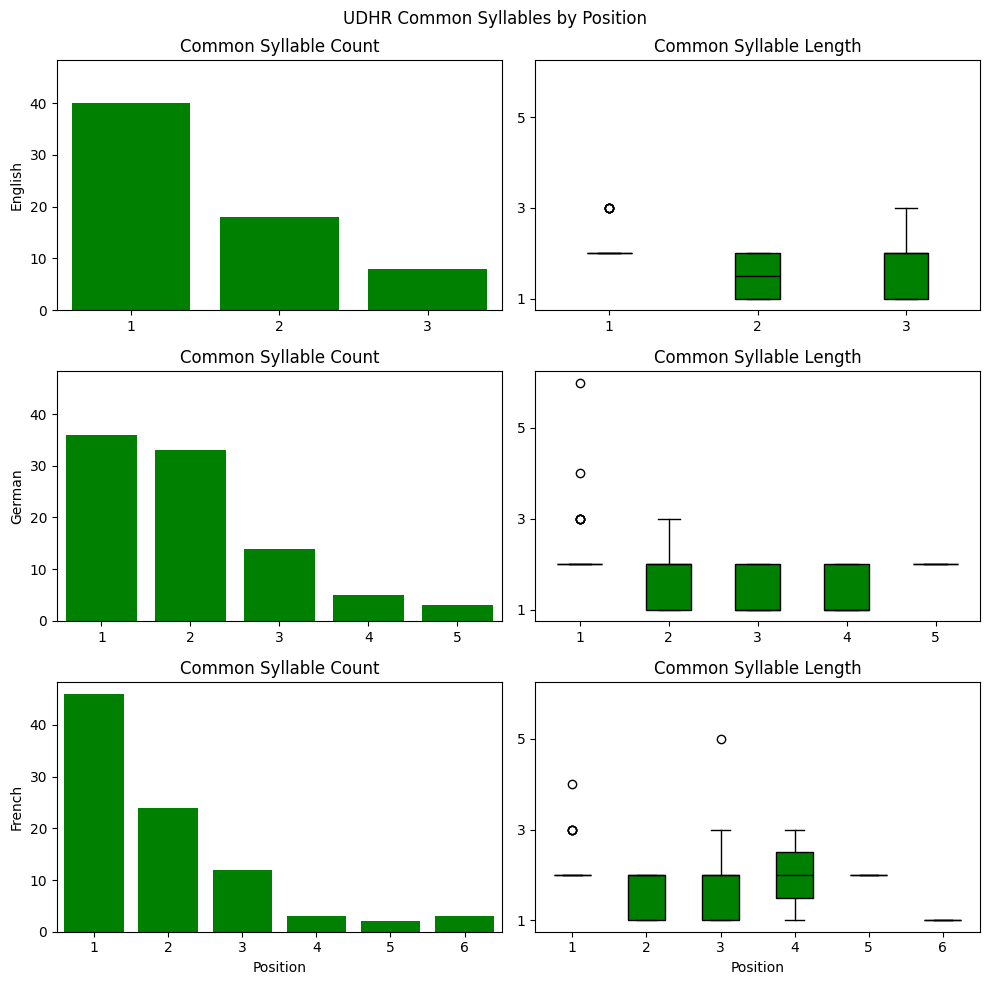

In [ ]:
#@title Plot Common Syllables by Position

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex='row', sharey='col')
max_len = 0
for i, lang in enumerate(['English','German','French']):
  pred_df = common_preds[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[[pos],'Lengths'].tolist() for pos in pred_positions]
  max_pred = max([length for pred in pred_lengths for length in pred])
  max_len = max(max_len, max_pred)
  ax[i,0].bar(pred_positions, pred_count, color='green')
  ax[i,1].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_title(f'Common Syllable Count')
  ax[i,1].set_title(f'Common Syllable Length')
  ax[i,0].set_ylabel(lang)
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[0,1].set_yticks(range(1,max_len+1,2))
ax[1,1].set_yticks(range(1,max_len+1,2))
ax[2,1].set_yticks(range(1,max_len+1,2))
plt.suptitle(f'UDHR Common Syllables by Position')
plt.tight_layout()
plt.savefig(f'UDHR Common Syllables by Position (uncased).png')
plt.show()
print()

In [ ]:
#@title Save Common First Syllables

common_starts = dict()

for lang in ['English', 'German', 'French']:
  common_starts[lang] = dict()
  syll_df = pred_syllables[lang].loc[1]
  for syll in common_preds[lang].loc[1,'Syllables']:
    word_ids = syll_df[syll_df['Syllables']==syll]['Word Indices'].tolist()
    common_starts[lang][syll] = words[lang].loc[word_ids,'Word'].tolist()

  with open(f'{lang} Common First Syllables (uncased).txt','w') as f:
    for syll, vals in sorted(common_starts[lang].items(),
                             key=lambda x: len(x[1]), reverse=True):
      f.write(f"{syll}: {', '.join(vals)}\n")

In [ ]:
#@title Save Syllabified UDHR Lexicon and Script
english_lexicon_syllabified = [syllable_dict['English'][word] for word in english_lexicon]
german_lexicon_syllabified = [syllable_dict['German'][word] for word in german_lexicon]
french_lexicon_syllabified = [syllable_dict['French'][word] for word in french_lexicon]

'''
with open('UDHR_English_lexicon_syllabified_uncased.txt', 'w') as f:
  f.write('\n'.join(english_lexicon_syllabified))
with open('UDHR_German_lexicon_syllabified_uncased.txt', 'w') as f:
  f.write('\n'.join(german_lexicon_syllabified))
with open('UDHR_French_lexicon_syllabified_uncased.txt', 'w') as f:
  f.write('\n'.join(french_lexicon_syllabified))
'''

english_script_syllabified = english_script
for key, val in syllable_dict['English'].items():
  english_script_syllabified = english_script_syllabified.replace(key, val)

german_script_syllabified = german_script
for key, val in syllable_dict['German'].items():
  german_script_syllabified = german_script_syllabified.replace(key, val)

french_script_syllabified = french_script
for key, val in syllable_dict['French'].items():
  french_script_syllabified = french_script_syllabified.replace(key, val)
'''
with open('UDHR_English_script_syllabified_uncased.txt', 'w') as f:
  f.write(english_script_syllabified)
with open('UDHR_German_script_syllabified_uncased.txt', 'w') as f:
  f.write(german_script_syllabified)
with open('UDHR_French_script_syllabified_uncased.txt', 'w') as f:
  f.write(french_script_syllabified)
'''
print(english_script_syllabified[:500])

un_i_versal de_claration of hu_ma_n ri_gh_ts
pr_eamble
wh_ereas re_cognition of the in_herent di_gnity and of the eq_ual and in_alienable ri_gh_ts of all me_mbers of the hu_ma_n family is the fo_un_dation of fr_e_edom, ju_stice and peace in the wor_ld, 

wh_ereas di_s_regard and con_tempt for hu_ma_n ri_gh_ts have re_sul_ted in barbarous acts which have ou_traged the co_ns_cience of ma_nkind, and the ad_vent of a wor_ld in which hu_ma_n be_ings sh_all enjoy fr_e_edom of sp_eech and be_lief and f


# Evaluate on Test Set

In [ ]:
#@title Load Predictions

# Function to convert X-sampa to IPA, skipping unknown characters
def sampa_to_ipa(segments):
  try:
    return sampa2uni(segments)
  except:
    ipa = []
    for segment in segments:
      try: ipa.append(sampa2uni(segment))
      except: ipa.append(segment)
    return ''.join(ipa)

# Folder Paths
results_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'
preds_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Predictions/Original'
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'

# Load Surprisals from Test Set
with open(os.path.join(data_folder, 'Original', 'All_Langs_Test_Original.pickle'), 'rb') as f:
  test_ds = pickle.load(f)
test_surprisals = [element for entry in test_ds for element in entry[0]]

# Load Thresholds
with open(os.path.join(results_original, 'LOO_Thresholds_NoHead')) as f:
  loo_thresholds_nohead = json.loads(f.read())

# Load predictions on Test Set for each LOO Model and specify target language
model = 'FNN'
predictions = dict()
for lang, id in [('English','en'),('German','de'),('French','fr')]:
  threshold = loo_thresholds_nohead[model][lang]
  predictions[lang] = pd.read_csv(os.path.join(preds_original, 'LOO', f'LOO_{lang}_{model}_Original.csv'))
  predictions[lang][['Word Indices','Positions']] += 1
  predictions[lang]['Surprisals'] = test_surprisals
  predictions[lang]['Threshold'] = threshold
  predictions[lang]['Pred Syllables'] = (predictions[lang]['Predictions'] >= threshold).astype('int')
  predictions[lang]['IPA'] = predictions[lang]['Segments'].apply(sampa_to_ipa)
  predictions[lang] = predictions[lang][['Word Indices', 'Positions', 'Predictions', 'Pred Syllables', 'Ground Truths',
                                        'Surprisals', 'Languages', 'Threshold', 'Segments', 'IPA']]
  predictions[lang] = predictions[lang][predictions[lang]['Languages']==id].set_index('Word Indices')

predictions['English']

,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Threshold,Segments,IPA
Word Indices,,,,,,,,,
10,1,0.999964,1,1,3.095461,en,0.38,s,s
10,2,0.174700,0,0,9.566688,en,0.38,4,ɾ
10,3,0.446940,1,1,2.584963,en,0.38,s,s
10,4,0.248464,0,0,0.000000,en,0.38,$,$
10,5,0.254216,0,0,0.000000,en,0.38,s,s
...,...,...,...,...,...,...,...,...,...
62858,7,0.221384,0,1,0.000000,en,0.38,p,p
62858,8,0.230051,0,0,0.000000,en,0.38,l,l
62858,9,0.214423,0,0,0.000000,en,0.38,#,#


In [ ]:
#@title Calculate Metrics by Position
results = dict()
styles = dict()
for lang in ['English','German','French']:
  preds = predictions[lang]
  counts = preds['Positions'].value_counts()
  positions = counts.index
  segments = counts.values
  sylls = [preds[preds['Positions']==pos]['Ground Truths'].sum() for pos in positions]
  pred_sylls = [preds[preds['Positions']==pos]['Pred Syllables'].sum() for pos in positions]
  tp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
  fp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==0)&(preds['Positions']==pos)).sum() for pos in positions])
  fn = np.array([((preds['Pred Syllables']==0)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
  precision = np.divide(tp, (tp+fp), where=tp+fp!=0, out=np.zeros(len(tp)))
  recall = np.divide(tp, (tp+fn), where=tp+fn!=0, out=np.zeros(len(tp)))
  f1 = np.divide((2*precision*recall), (precision+recall), where=(precision+recall!=0), out=np.zeros(len(tp)))
  results[lang] = pd.DataFrame([segments, sylls, pred_sylls, precision, recall, f1],
                                index=['Segments', 'Syllables', 'Predicted', 'Precision', 'Recall', 'F1'],
                                columns=positions)
  results[lang] = results[lang].T.astype({'Segments':int, 'Syllables':int, 'Predicted':int})
  styles[lang] = results[lang].style.format({'Precision':'{:.0%}', 'Recall':'{:.0%}', 'F1':'{:.0%}'})

styles['English']

,Segments,Syllables,Predicted,Precision,Recall,F1
Positions,,,,,,
1,3889,3889,3889,100%,100%,100%
2,3888,336,167,55%,27%,37%
3,3864,1854,2802,55%,83%,66%
4,3678,1267,1580,48%,60%,54%
5,3383,1153,1229,50%,53%,51%
6,2903,797,859,45%,49%,47%
7,2262,645,502,48%,37%,42%
8,1624,376,338,44%,40%,42%
9,1126,259,216,49%,41%,45%


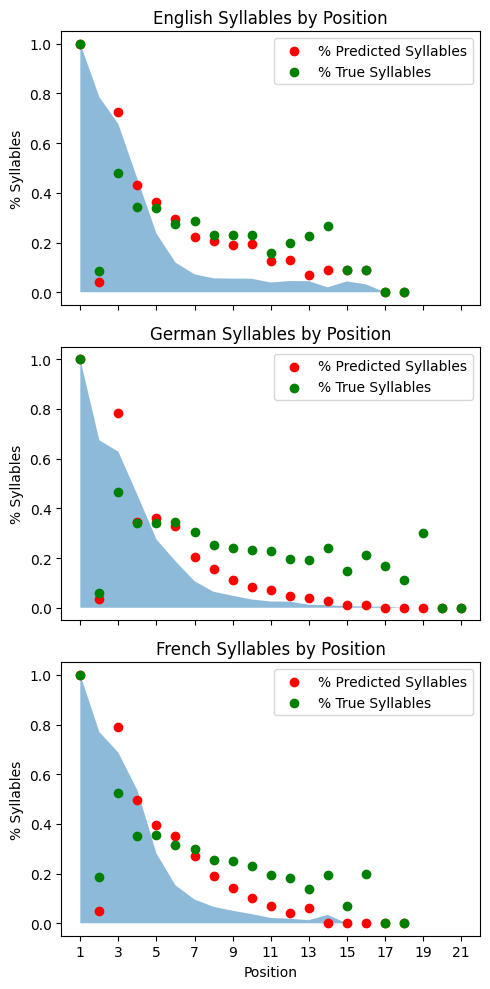

In [ ]:
#@title Plot Syllable Breaks by Position
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,10), sharex=True, sharey=True)
for i, lang in enumerate(['English','German','French']):
  positions = results[lang].index
  sylls = results[lang]['Syllables'] / results[lang]['Segments']
  preds = results[lang]['Predicted'] / results[lang]['Segments']
  entropy = [predictions[lang][predictions[lang]['Positions']==pos]['Surprisals'].mean() for pos in positions]
  entropy = entropy / max(entropy)
  ax[i].fill_between(positions, entropy, alpha=0.5)
  ax[i].scatter(positions, preds, c='red', label='% Predicted Syllables')
  ax[i].scatter(positions, sylls, c='green', label='% True Syllables')
  ax[i].set_title(f'{lang} Syllables by Position')
  ax[i].set_ylabel('% Syllables')
  ax[i].legend()
ax[2].set_xlabel('Position')
ax[2].set_xticks(range(1,22,2))
plt.tight_layout()
plt.savefig(f'{model} Syllable Breaks by Position.png')
plt.show()

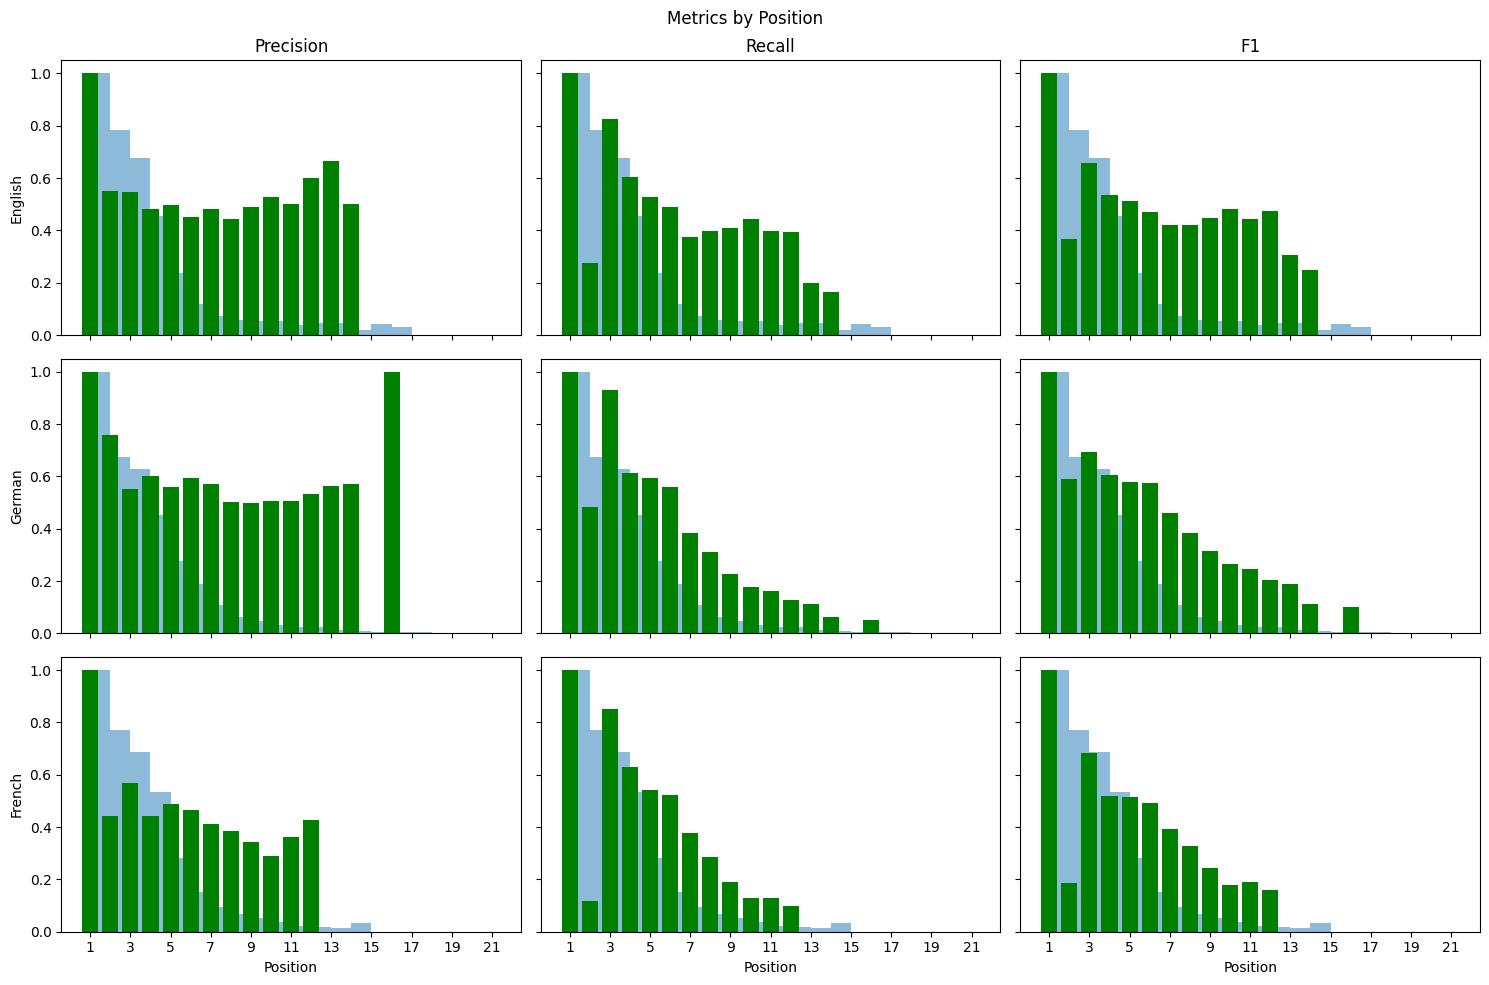

In [ ]:
#@title Plot Metrics by Position
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10), sharex=True, sharey=True)
for i, lang in enumerate(['English','German','French']):
  positions = results[lang].index
  precision = results[lang]['Precision']
  recall = results[lang]['Recall']
  f1 = results[lang]['F1']
  entropy = [predictions[lang][predictions[lang]['Positions']==pos]['Surprisals'].mean() for pos in positions]
  entropy = entropy / max(entropy)
  ax[i,0].fill_between(positions, entropy, step='post', alpha=0.5)
  ax[i,0].bar(positions, precision, color='green')
  ax[i,0].set_ylabel(lang)
  ax[i,1].fill_between(positions, entropy, step='post', alpha=0.5)
  ax[i,1].bar(positions, recall, color='green')
  ax[i,2].fill_between(positions, entropy, step='post', alpha=0.5)
  ax[i,2].bar(positions, f1, color='green')
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
ax[2,2].set_xlabel('Position')
ax[0,0].set_title('Precision')
ax[0,1].set_title('Recall')
ax[0,2].set_title('F1')
plt.suptitle('Metrics by Position')
plt.xticks(range(1,22,2))
plt.tight_layout()
plt.savefig(f'{model} Metrics by Position.png')
plt.show()

In [ ]:
#@title Extract Syllables by Position

words = dict()
pred_syllables = dict()
true_syllables = dict()

for lang in ['English','German','French']:
  ids = []
  phonos = []
  pred_sylls = []
  true_sylls = []
  pred_matches = []
  true_matches = []
  for id in predictions[lang].index.unique():
    df = predictions[lang].loc[[id]]
    ids.append(id)

    phono = ''.join(df['IPA'].tolist())
    truths = df['Ground Truths'].tolist()
    preds = df['Pred Syllables'].tolist()
    pred_breaks = [i for i, num in enumerate(preds) if num==1]
    pred_slices = [slice(pair[0],pair[1]+1) for pair in pairwise(pred_breaks)]
    pred_phono_slices = [slice(pair[0],pair[1]) for pair in pairwise(pred_breaks)]
    true_breaks = [i for i, num in enumerate(truths) if num==1]
    true_slices = [slice(pair[0],pair[1]+1) for pair in pairwise(true_breaks)]
    true_phono_slices = [slice(pair[0],pair[1]) for pair in pairwise(true_breaks)]

    phonos.append(phono)
    pred_matches.append([preds[s]==truths[s] for s in pred_slices] + [preds[pred_breaks[-1]:]==truths[pred_breaks[-1]:]])
    pred_sylls.append([phono[s] for s in pred_phono_slices] + [phono[pred_breaks[-1]:]])
    true_matches.append([truths[s]==preds[s] for s in true_slices] + [truths[true_breaks[-1]:]==preds[true_breaks[-1]:]])
    true_sylls.append([phono[s] for s in true_phono_slices] + [phono[true_breaks[-1]:]])

  words[lang] = pd.DataFrame({'Word Indices':ids, 'Word':phonos, 'True Syllables':true_sylls, 'Pred Syllables':pred_sylls,
                              'Pred Matches':pred_matches, 'True Matches':true_matches}).set_index('Word Indices')

  pred_ids = [[id]*len(pred) for id,pred in zip(ids, pred_sylls)]
  pred_ids = [i for id in pred_ids for i in id]
  pred_positions = [i+1 for pred in pred_sylls for i, syll in enumerate(pred)]
  pred_sylls = [syll for pred in pred_sylls for syll in pred]
  pred_lengths = [len(syll) for syll in pred_sylls]
  pred_matches = [val for pred in pred_matches for val in pred]

  true_ids = [[id]*len(truth) for id,truth in zip(ids, true_sylls)]
  true_ids = [i for id in true_ids for i in id]
  true_positions = [i+1 for truth in true_sylls for i, syll in enumerate(truth)]
  true_sylls = [syll for truth in true_sylls for syll in truth]
  true_lengths = [len(syll) for syll in true_sylls]
  true_matches = [val for truth in true_matches for val in truth]

  pred_syllables[lang] = pd.DataFrame({'Positions':pred_positions, 'Syllables':pred_sylls, 'Lengths':pred_lengths,
                                       'Matches':pred_matches, 'Word Indices':pred_ids}).set_index('Positions')

  true_syllables[lang] = pd.DataFrame({'Positions':true_positions, 'Syllables':true_sylls, 'Lengths':true_lengths,
                                       'Matches':true_matches, 'Word Indices':true_ids}).set_index('Positions')

display(words['English'])
print()
display(pred_syllables['English'])
print()
display(true_syllables['English'])

,Word,True Syllables,Pred Syllables,Pred Matches,True Matches
Word Indices,,,,,
10,sɾs$s,"[sɾ, s$s]","[sɾ, s$s]","[True, True]","[True, True]"
17,bɨbɪ,"[bɨ, bɪ]","[bɨ, bɪ]","[True, True]","[True, True]"
48,ɡæɡəl,"[ɡæ, ɡəl]","[ɡæ, ɡəl]","[True, True]","[True, True]"
66,hødrɫpɒnɪks,"[hø, drɫ, pɒ, nɪks]","[hø, dr, ɫ, pɒ, nɪ, ks]","[True, False, False, True, False, False]","[True, False, True, False]"
119,prəpɪʃəs,"[prə, pɪ, ʃəs]","[prə, pɪ, ʃəs]","[True, True, True]","[True, True, True]"
...,...,...,...,...,...
62777,mɒkɛt,"[mɒ, kɛt]","[mɒ, kɛt]","[True, True]","[True, True]"
62811,f$tɨst,"[f$, tɨst]","[f$, t, ɨst]","[True, False, False]","[True, False]"
62813,ɡænɪt,"[ɡæ, nɪt]","[ɡæ, nɪt]","[True, True]","[True, True]"


,Syllables,Lengths,Matches,Word Indices
Positions,,,,
1,sɾ,2,True,10
2,s$s,3,True,10
1,bɨ,2,True,17
2,bɪ,2,True,17
1,ɡæ,2,True,48
...,...,...,...,...
1,ɒf,2,True,62851
2,dɨ,2,True,62851
1,ɪl,2,False,62858


,Syllables,Lengths,Matches,Word Indices
Positions,,,,
1,sɾ,2,True,10
2,s$s,3,True,10
1,bɨ,2,True,17
2,bɪ,2,True,17
1,ɡæ,2,True,48
...,...,...,...,...
2,dɨ,2,True,62851
1,ɪ,1,False,62858
2,læ,2,False,62858


In [ ]:
#@title Extract Unique Syllables by Position

unique_preds = dict()
unique_truths = dict()

for lang in ['English','German','French']:
  pred_list = []
  true_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos],['Syllables','Lengths','Matches']].reset_index()
    pred_df['Count'] = pred_df['Syllables']
    pred_df = pred_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Matches':'mean', 'Count':'count'})
    pred_df['True'] = pred_df['Matches'] > 0
    #pred_df = pred_df[pred_df['Count']>10].set_index('Positions')
    pred_df = pred_df.set_index('Positions')
    pred_list.append(pred_df)

  for pos in true_syllables[lang].index.unique():
    true_df = true_syllables[lang].loc[[pos],['Syllables','Lengths','Matches']].reset_index()
    true_df['Count'] = true_df['Syllables']
    true_df = true_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Matches':'mean', 'Count':'count'})
    true_df['Predicted'] = true_df['Matches'] > 0
    #true_df = true_df[true_df['Count']>10].set_index('Positions')
    true_df = true_df.set_index('Positions')
    true_list.append(true_df)

  unique_preds[lang] = pd.concat(pred_list)
  unique_truths[lang] = pd.concat(true_list)

display(unique_preds['English'])
print()
display(unique_truths['English'])

,Syllables,Lengths,Matches,Count,True
Positions,,,,,
1,#,1,0.75,8,True
1,#k,2,0.20,5,True
1,#kɪ,3,0.00,1,False
1,#m,2,1.00,1,True
1,#mə,3,0.00,1,False
...,...,...,...,...,...
8,nɪs,3,1.00,1,True
8,vlɪ,3,0.00,1,False
9,lɪ,2,1.00,1,True


,Syllables,Lengths,Matches,Count,Predicted
Positions,,,,,
1,#,1,0.500000,12,True
1,#f,2,0.000000,2,False
1,#k,2,1.000000,1,True
1,#m,2,1.000000,1,True
1,$,1,0.428571,28,True
...,...,...,...,...,...
7,tɪ,2,0.000000,3,False
7,zəm,3,0.000000,1,False
7,ɡræm,4,0.000000,1,False


In [ ]:
#@title Extract Common Syllables by Position

common_preds = dict()  # We threshold predicted syllables to be > 10 for stability
common_truths = dict()

for lang in ['English','German','French']:
  pred_list = []
  true_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos],['Syllables','Lengths','Matches']].reset_index()
    pred_df['Count'] = pred_df['Syllables']
    pred_df = pred_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Matches':'mean', 'Count':'count'})
    pred_df['True'] = pred_df['Matches'] > 0
    pred_df = pred_df[pred_df['Count']>10].set_index('Positions')
    #pred_df = pred_df.set_index('Positions')
    pred_list.append(pred_df)

  for pos in true_syllables[lang].index.unique():
    true_df = true_syllables[lang].loc[[pos],['Syllables','Lengths','Matches']].reset_index()
    true_df['Count'] = true_df['Syllables']
    true_df = true_df.groupby(by='Syllables',as_index=False).agg(
        {'Positions':'max', 'Lengths':'max', 'Matches':'mean', 'Count':'count'})
    true_df['Predicted'] = true_df['Matches'] > 0
    true_df = true_df[true_df['Count']>10].set_index('Positions')
    #true_df = true_df.set_index('Positions')
    true_list.append(true_df)

  common_preds[lang] = pd.concat(pred_list)
  common_truths[lang] = pd.concat(true_list)

display(common_preds['English'])
print()
display(common_truths['English'])

,Syllables,Lengths,Matches,Count,True
Positions,,,,,
1,$,1,1.000000,12,True
1,_,1,0.000000,14,False
1,_ɪ,2,0.500000,12,True
1,bl,2,0.000000,21,False
1,br,2,0.000000,27,False
...,...,...,...,...,...
5,ə,1,0.000000,24,False
5,ɨt,2,0.000000,12,False
5,ɪ,1,0.000000,20,False


,Syllables,Lengths,Matches,Count,Predicted
Positions,,,,,
1,#,1,0.500000,12,True
1,$,1,0.428571,28,True
1,bɪ,2,1.000000,21,True
1,di,2,1.000000,15,True
1,dɛ,2,0.928571,14,True
...,...,...,...,...,...
5,tɪ,2,0.100000,20,True
5,ʃən,3,0.351351,37,True
6,lɪ,2,0.518519,27,True


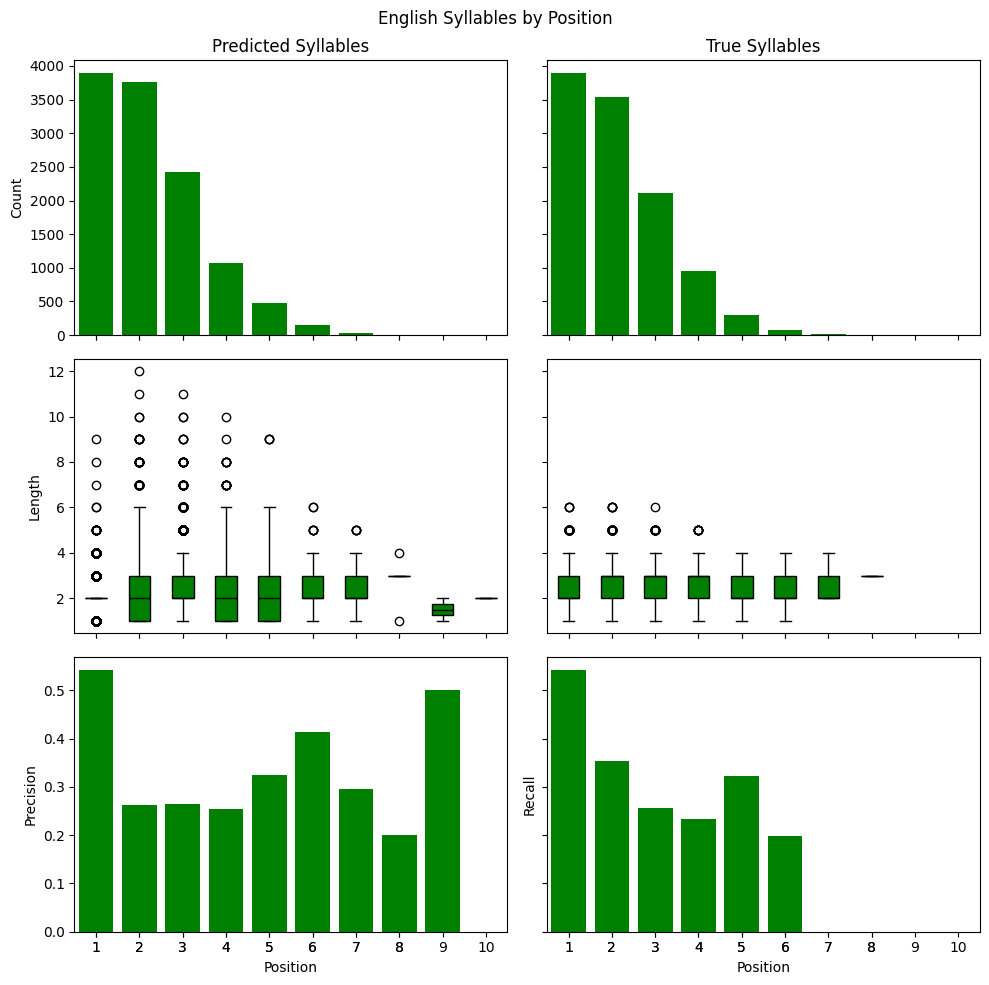

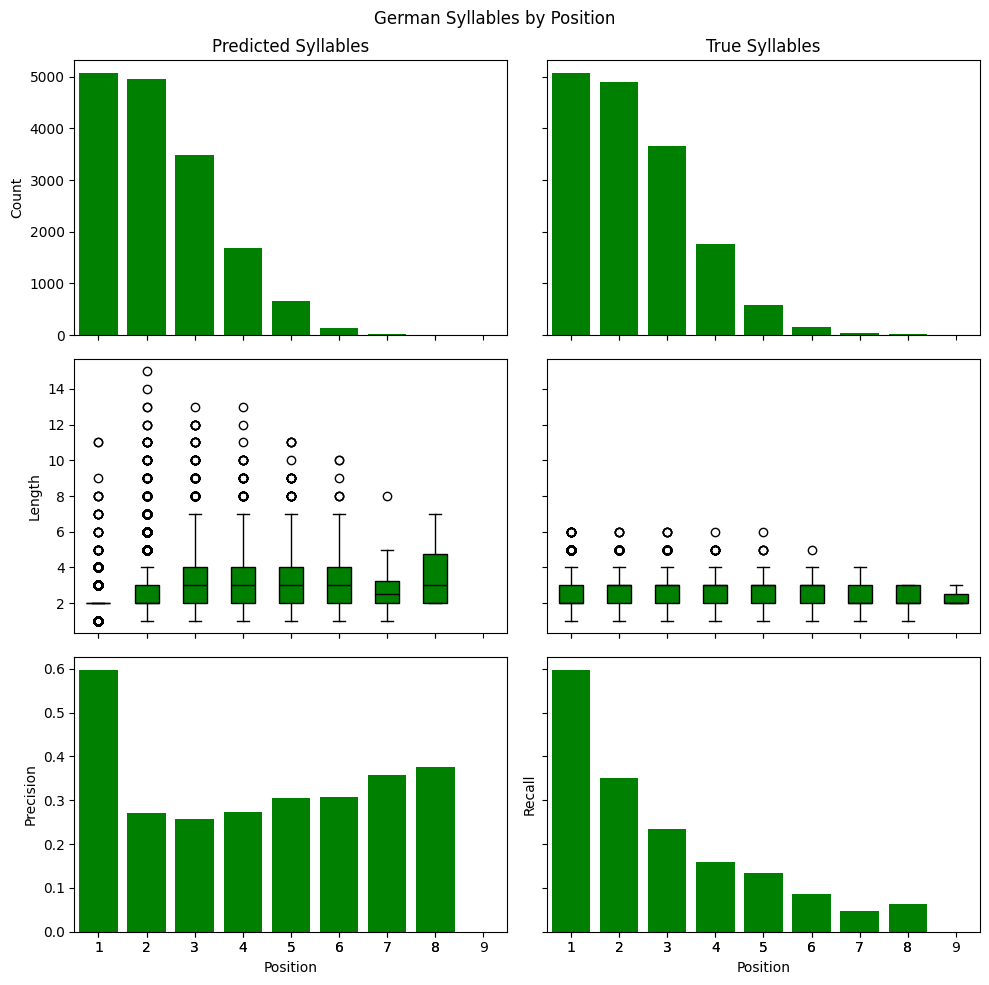

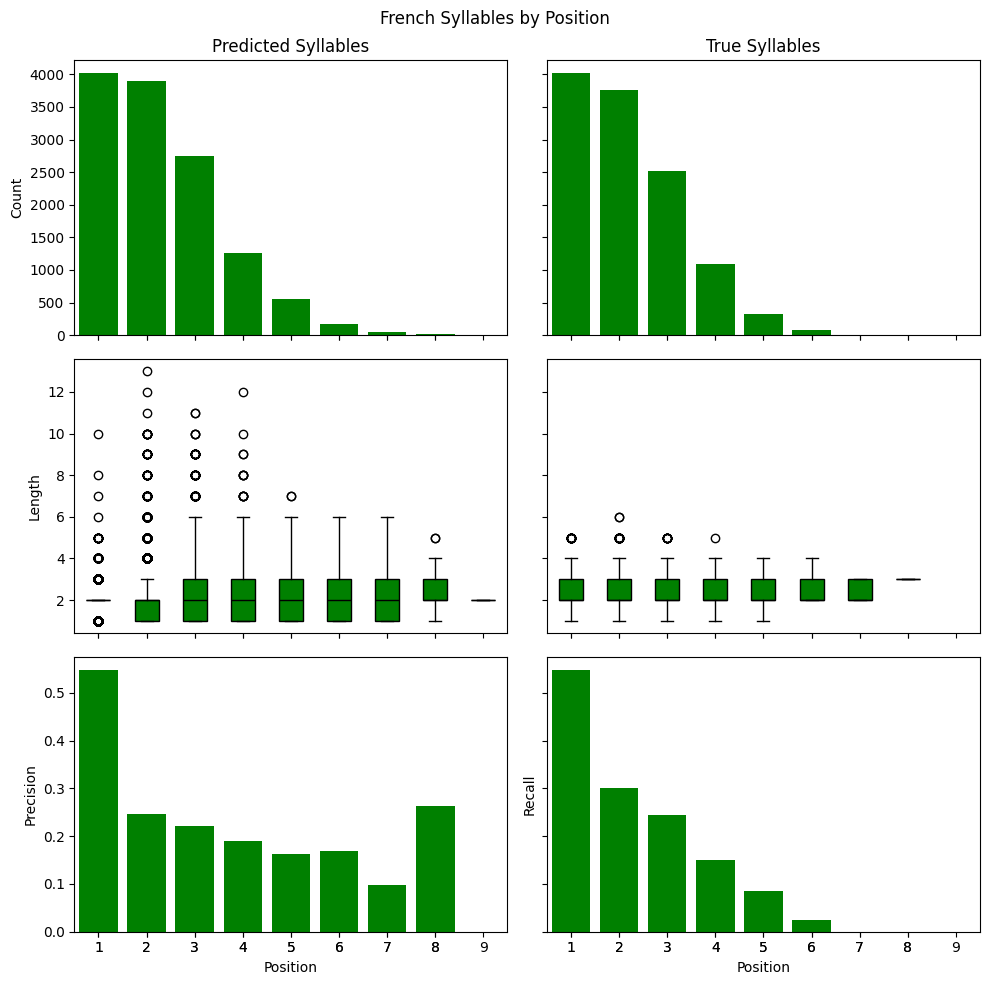

In [ ]:
#@title Plot Syllables by Position

for lang in ['English','German','French']:
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey='row')
  pred_df = pred_syllables[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[pos,'Lengths'].tolist() for pos in pred_positions]
  pred_precision = [pred_df.loc[pos,'Matches'].mean() for pos in pred_positions]
  true_df = true_syllables[lang]
  true_positions = true_df.index.unique()
  true_count = [len(true_df.loc[pos]) for pos in true_positions]
  true_lengths = [true_df.loc[pos,'Lengths'].tolist() for pos in true_positions]
  true_recall = [true_df.loc[pos,'Matches'].mean() for pos in true_positions]
  ax[0,0].bar(pred_positions, pred_count, color='green')
  ax[0,1].bar(true_positions, true_count, color='green')
  ax[0,0].set_ylabel('Count')
  ax[1,0].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,1].boxplot(true_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,0].set_ylabel('Length')
  ax[2,0].bar(pred_positions, pred_precision, color='green')
  ax[2,1].bar(true_positions, true_recall, color='green')
  ax[2,0].set_ylabel('Precision')
  ax[2,1].set_ylabel('Recall')
  ax[2,0].set_xlabel('Position')
  ax[2,1].set_xlabel('Position')
  ax[0,0].set_title('Predicted Syllables')
  ax[0,1].set_title('True Syllables')
  plt.suptitle(f'{lang} Syllables by Position')
  plt.tight_layout()
  plt.savefig(f'{lang} Syllables by Position.png')
  plt.show()
  print()

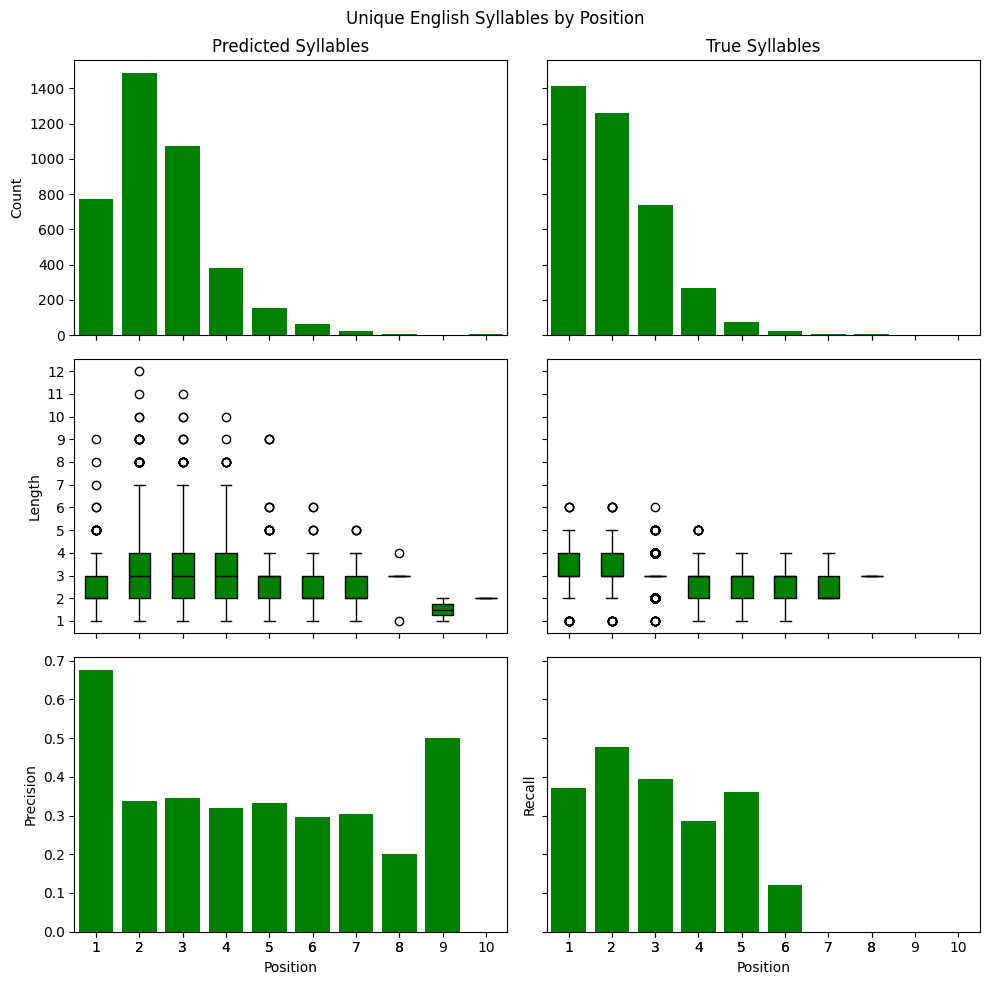

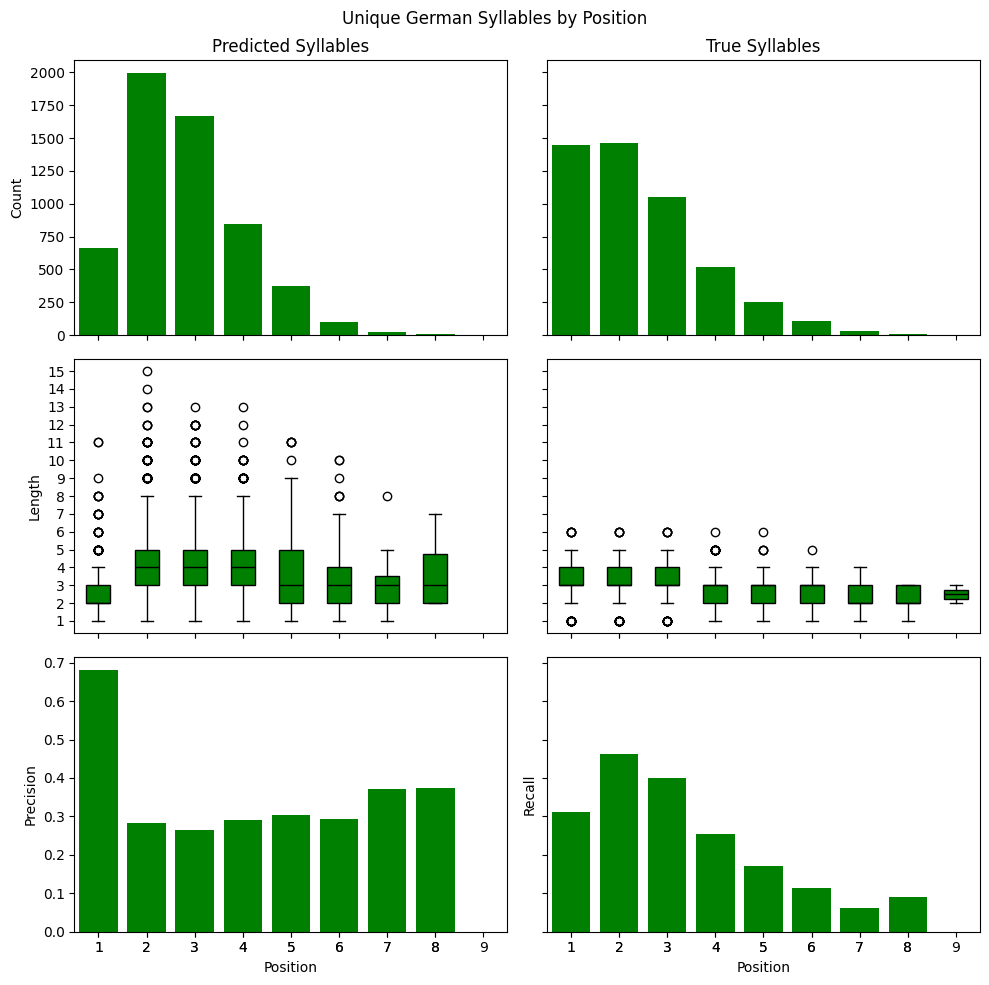

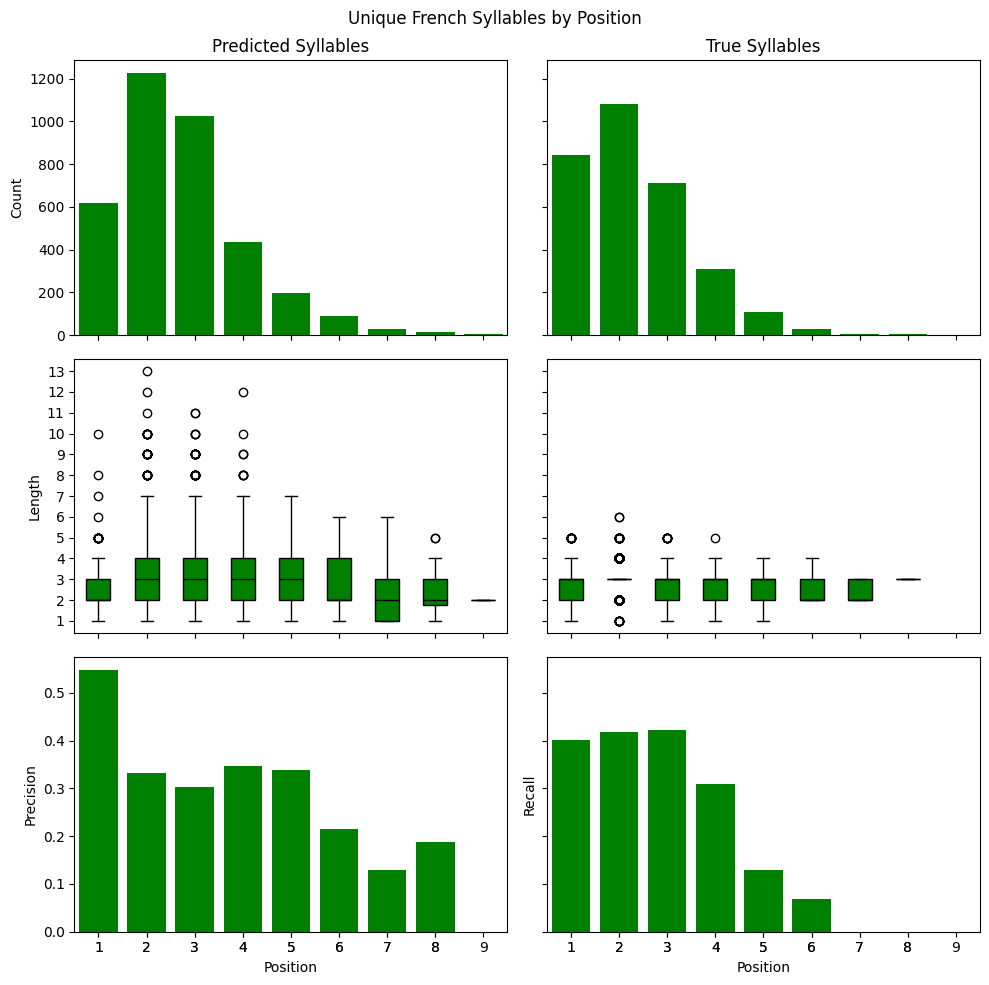

In [ ]:
#@title Plot Unique Syllables by Position

for lang in ['English','German','French']:
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey='row')
  pred_df = unique_preds[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[[pos],'Lengths'].tolist() for pos in pred_positions]
  pred_precision = [pred_df.loc[[pos],'True'].mean() for pos in pred_positions]
  true_df = unique_truths[lang]
  true_positions = true_df.index.unique()
  true_count = [len(true_df.loc[pos]) for pos in true_positions]
  true_lengths = [true_df.loc[[pos],'Lengths'].tolist() for pos in true_positions]
  true_recall = [true_df.loc[[pos],'Predicted'].mean() for pos in true_positions]
  max_length = max([length for pred in pred_lengths for length in pred] + [length for truth in true_lengths for length in truth])
  ax[0,0].bar(pred_positions, pred_count, color='green')
  ax[0,1].bar(true_positions, true_count, color='green')
  ax[0,0].set_ylabel('Count')
  ax[1,0].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,1].boxplot(true_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,0].set_ylabel('Length')
  ax[1,0].set_yticks(range(1,max_length+1))
  ax[1,1].set_yticks(range(1,max_length+1))
  ax[2,0].bar(pred_positions, pred_precision, color='green')
  ax[2,1].bar(true_positions, true_recall, color='green')
  ax[2,0].set_ylabel('Precision')
  ax[2,1].set_ylabel('Recall')
  ax[2,0].set_xlabel('Position')
  ax[2,1].set_xlabel('Position')
  ax[0,0].set_title('Predicted Syllables')
  ax[0,1].set_title('True Syllables')
  plt.suptitle(f'Unique {lang} Syllables by Position')
  plt.tight_layout()
  plt.savefig(f'Unique {lang} Syllables by Position.png')
  plt.show()
  print()

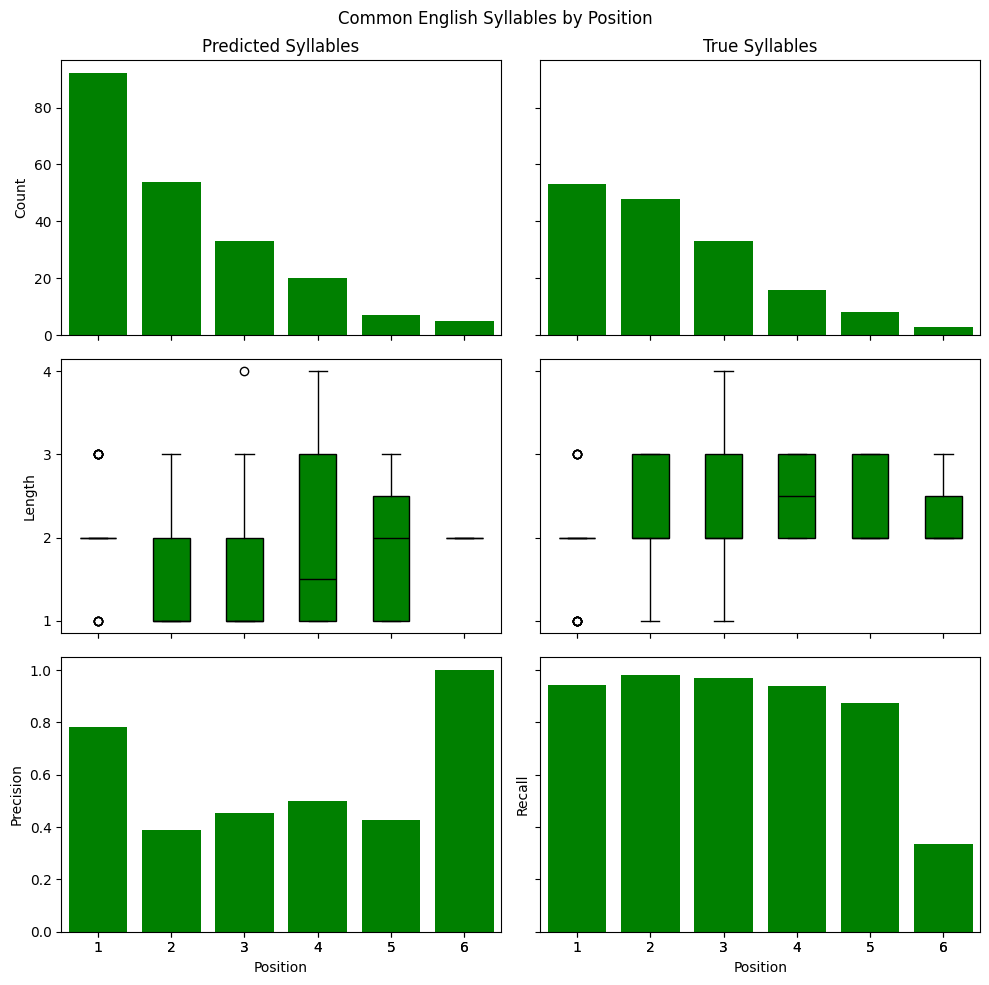

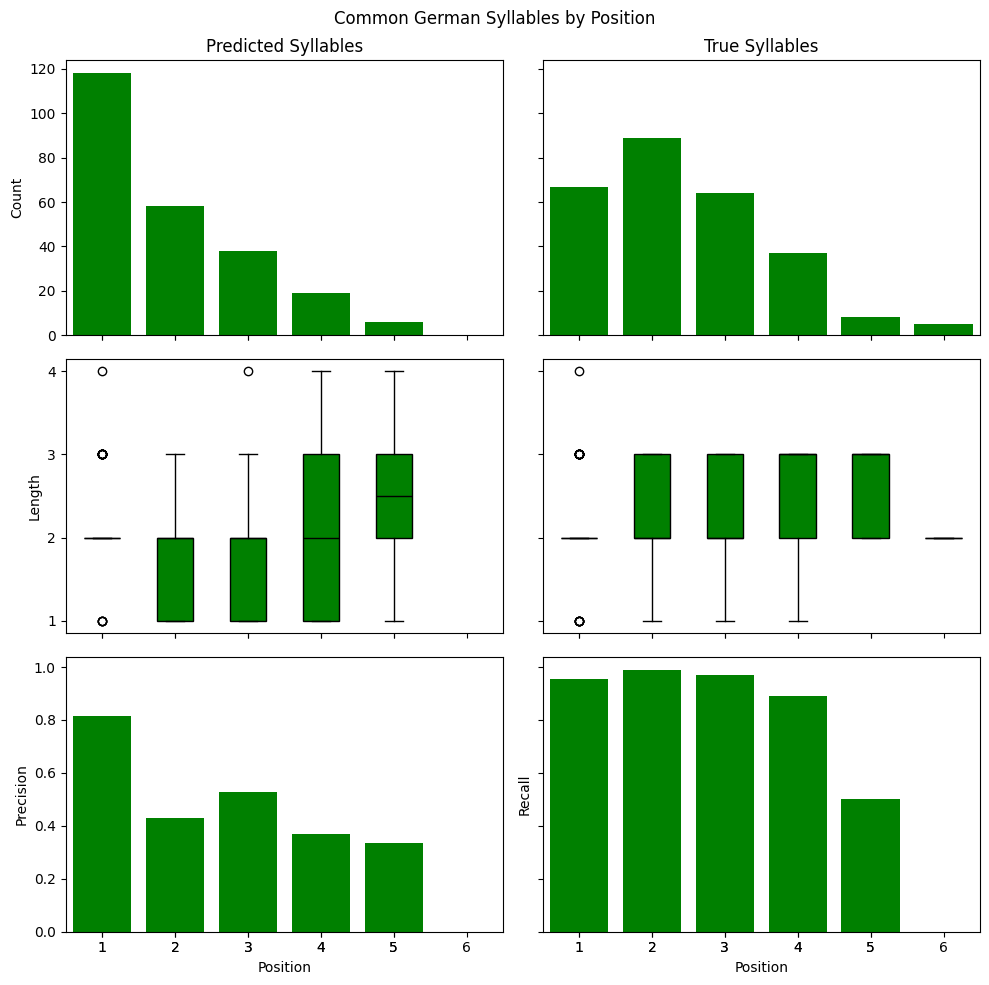

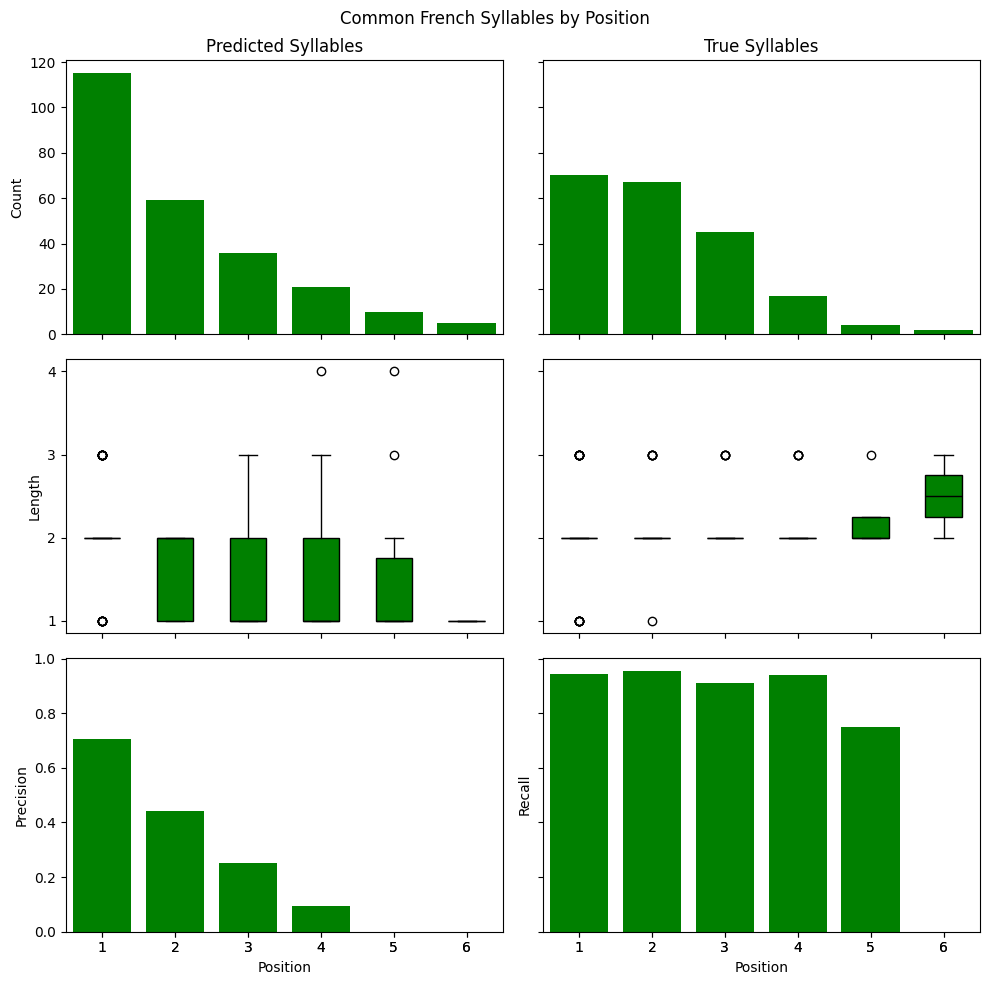

In [ ]:
#@title Plot Common Syllables by Position

for lang in ['English','German','French']:
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey='row')
  pred_df = common_preds[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[[pos],'Lengths'].tolist() for pos in pred_positions]
  pred_precision = [pred_df.loc[[pos],'True'].mean() for pos in pred_positions]
  true_df = common_truths[lang]
  true_positions = true_df.index.unique()
  true_count = [len(true_df.loc[pos]) for pos in true_positions]
  true_lengths = [true_df.loc[[pos],'Lengths'].tolist() for pos in true_positions]
  true_recall = [true_df.loc[[pos],'Predicted'].mean() for pos in true_positions]
  max_length = max([length for pred in pred_lengths for length in pred] + [length for truth in true_lengths for length in truth])
  ax[0,0].bar(pred_positions, pred_count, color='green')
  ax[0,1].bar(true_positions, true_count, color='green')
  ax[0,0].set_ylabel('Count')
  ax[1,0].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,1].boxplot(true_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,0].set_ylabel('Length')
  ax[1,0].set_yticks(range(1,max_length+1))
  ax[1,1].set_yticks(range(1,max_length+1))
  ax[2,0].bar(pred_positions, pred_precision, color='green')
  ax[2,1].bar(true_positions, true_recall, color='green')
  ax[2,0].set_ylabel('Precision')
  ax[2,1].set_ylabel('Recall')
  ax[2,0].set_xlabel('Position')
  ax[2,1].set_xlabel('Position')
  ax[0,0].set_title('Predicted Syllables')
  ax[0,1].set_title('True Syllables')
  plt.suptitle(f'Common {lang} Syllables by Position')
  plt.tight_layout()
  plt.savefig(f'Common {lang} Syllables by Position.png')
  plt.show()
  print()

In [ ]:
#@title Save Common First Syllables

for lang in ['English','German','French']:
  pred_df = common_preds[lang].loc[1]
  true_df = common_truths[lang].loc[1]
  tp = pred_df[pred_df['True']==True]['Syllables'].tolist()
  fp = pred_df[pred_df['True']==False]['Syllables'].tolist()
  fn = true_df[true_df['Predicted']==False]['Syllables'].tolist()

  with open(f'{lang} Common First Syllables.txt','w') as f:
    f.write(f'True Positives: {len(tp)}\n\n')
    f.write('\n'.join(tp))
    f.write(f'\n\nFalse Positives: {len(fp)}\n\n')
    f.write('\n'.join(fp))
    f.write(f'\n\nFalse Negatives: {len(fn)}\n\n')
    f.write('\n'.join(fn))


In [ ]:
#@title Extract Common Syllables by Position (Alternative)

common_preds_alt = dict()
common_truths_alt = dict()

for lang in ['English','German','French']:
  pred_list = []
  true_list = []
  for pos in pred_syllables[lang].index.unique():
    pred_df = pred_syllables[lang].loc[[pos]]
    pred_counts = pred_df.value_counts('Syllables')
    pred_sylls = pred_counts[pred_counts > 10].index
    pred_list.append(pred_df[pred_df['Syllables'].isin(pred_sylls)])

  for pos in true_syllables[lang].index.unique():
    true_df = true_syllables[lang].loc[[pos]]
    true_counts = true_df.value_counts('Syllables')
    true_sylls = true_counts[true_counts > 10].index
    true_list.append(true_df[true_df['Syllables'].isin(true_sylls)])

  common_preds_alt[lang] = pd.concat(pred_list)
  common_truths_alt[lang] = pd.concat(true_list)

display(common_preds_alt['English'])
print()
display(common_truths_alt['English'])

,Syllables,Lengths,Matches,Word Indices
Positions,,,,
1,ɡæ,2,True,48
1,hø,2,True,66
1,mæ,2,False,124
1,pr,2,False,132
1,dɪ,2,True,196
...,...,...,...,...
6,lɪ,2,True,47840
6,lɪ,2,True,54561
6,lɪ,2,True,54608


,Syllables,Lengths,Matches,Word Indices
Positions,,,,
1,hø,2,True,66
1,prə,3,True,119
1,kɒ,2,False,148
1,dɪ,2,True,196
1,ɪn,2,True,232
...,...,...,...,...
6,lɪ,2,True,59411
6,ʃən,3,False,60870
6,lɪ,2,False,62129


NameError: name 'common_preds_alt' is not defined

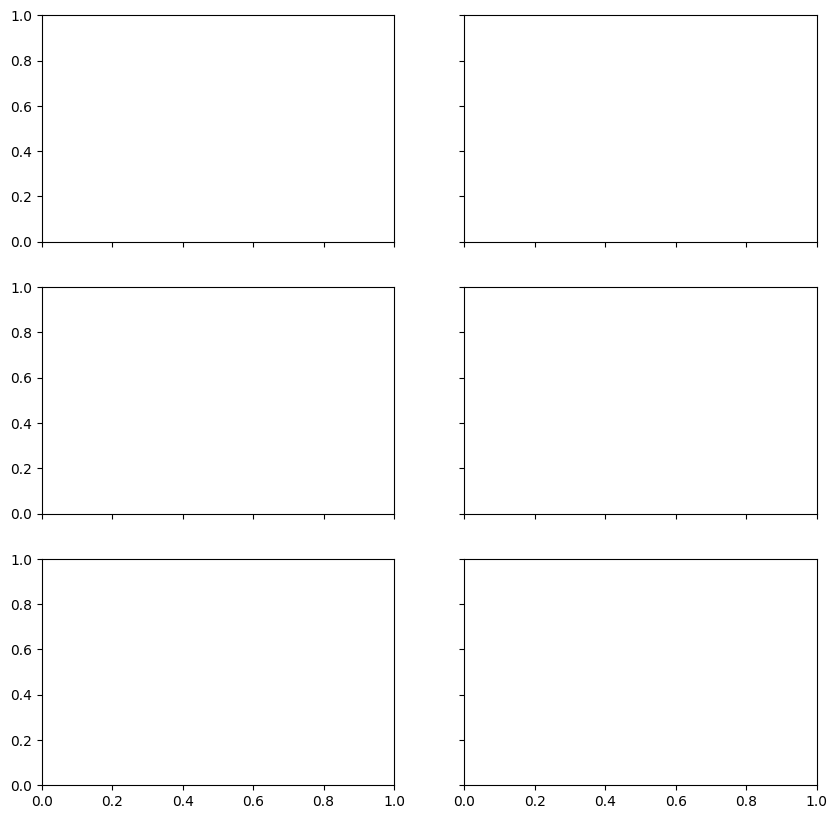

In [ ]:
#@title Plot Common Syllables by Position (Alternative)

for lang in ['English','German','French']:
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey='row')
  pred_df = common_preds_alt[lang]
  pred_positions = pred_df.index.unique()
  pred_count = [len(pred_df.loc[pos]) for pos in pred_positions]
  pred_lengths = [pred_df.loc[pos,'Lengths'].tolist() for pos in pred_positions]
  pred_precision = [pred_df.loc[pos,'Matches'].mean() for pos in pred_positions]
  true_df = common_truths_alt[lang]
  true_positions = true_df.index.unique()
  true_count = [len(true_df.loc[pos]) for pos in true_positions]
  true_lengths = [true_df.loc[pos,'Lengths'].tolist() for pos in true_positions]
  true_recall = [true_df.loc[pos,'Matches'].mean() for pos in true_positions]
  max_length = max([length for pred in pred_lengths for length in pred] + [length for truth in true_lengths for length in truth])
  ax[0,0].bar(pred_positions, pred_count, color='green')
  ax[0,1].bar(true_positions, true_count, color='green')
  ax[0,0].set_ylabel('Count')
  ax[1,0].boxplot(pred_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,1].boxplot(true_lengths, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[1,0].set_ylabel('Length')
  ax[1,0].set_yticks(range(1,max_length+1))
  ax[1,1].set_yticks(range(1,max_length+1))
  ax[2,0].bar(pred_positions, pred_precision, color='green')
  ax[2,1].bar(true_positions, true_recall, color='green')
  ax[2,0].set_ylabel('Precision')
  ax[2,1].set_ylabel('Recall')
  ax[2,0].set_xlabel('Position')
  ax[2,1].set_xlabel('Position')
  ax[0,0].set_title('Predicted Syllables')
  ax[0,1].set_title('True Syllables')
  plt.suptitle(f'Common {lang} Syllables by Position')
  plt.tight_layout()
  plt.savefig(f'Common {lang} Syllables by Position (Alternative).png')
  plt.show()
  print()

# Evaluate on Different Size Test Sets

In [ ]:
#@title Segment Surprisal Function

def segment_surprisal(lexicon, syllables, language, sample_size=None, random_seed=None):
  '''
  Takes a lexicon and breaks it down into segments (phonemes or graphemes).
  Returns an N x 6 DataFrame, where N is the total number of segments, and
  the columns are:

    word_id: The index of the word the segment belongs to (starting at 1)
    position: The position of the segment within the word (starting at 1)
    segment: The segment itself (phoneme or grapheme)
    surprisal: The surprisal of that segment conditioned on all the preceding segments in the word.
    language: The language code of the lexicon.
    syllable: Binary marker for syllable breaks, 1 for the start of a new syllable, 0 otherwise.

  Params:
    lexicon (list): List of vocab terms.
    syllables (list): List of syllable breaks.
    language (str): Language code for lexicon.
    sample_size (int): Number of samples to take from lexicon.
                       If None, will take entire lexicon.
    random_seed (int): Random seed to make sampling reproducible.
                       If None, sampling will be non-reproducible.
                       If sample_size is None, this parameter is ignored.
  '''
  np.random.seed(seed=random_seed)

  # If sample_size is not None, draw that many samples from lexicon for vocab_list.
  if sample_size:
    if sample_size > len(lexicon):
      raise ValueError(f'Sample size of {sample_size} is larger than lexicon size of {len(lexicon)}')
    rand_idx = np.random.choice(len(lexicon), size=sample_size, replace=False)
    vocab_list = [lexicon[i] for i in rand_idx]
    syll_list = [syllables[i] for i in rand_idx]

  # Otherwise, use full lexicon.
  else:
    vocab_list = lexicon
    syll_list = syllables

  # Add ending character ">" to each word.
  vocab_list = [word+'>' for word in vocab_list]

  # Flatten syll_list so it is no longer separated by words
  syll_list = [syll for word in syll_list for syll in word]

  max_pos = max([len(word) for word in vocab_list])
  idx = list(range(len(vocab_list)))

  # Initialize empty lists for column values.
  word_id = []
  position = []
  segment = []
  surprisal = []

  for p in range(0, max_pos):
    # Create conditional probability distribution P(segment|context) up to position p.
    pos_list = [(word[0:p], word[p]) for word in vocab_list if len(word)>p]
    cond_freq_dist = ConditionalFreqDist(pos_list)
    cond_prob_dist = ConditionalProbDist(cond_freq_dist, MLEProbDist)

    # Add on to lists of word_ids, positions, segments, and surprisals up to position p.
    word_id += [i+1 for i in idx if len(vocab_list[i])>p]
    position += [p+1] * len(pos_list)
    segment += [ngram[1] for ngram in pos_list]
    surprisal += [-cond_prob_dist[ngram[0]].logprob(ngram[1]) for ngram in pos_list]

  # Add "lang" list, should match the length of other four lists.
  lang = [language] * len(word_id)

  # Create DataFrame with word_id, position, segment, surprisal, and lang columns.
  df = pd.DataFrame(list(zip(word_id, position, segment, surprisal, lang)),
                    columns=['word_id', 'position', 'segment', 'surprisal', 'lang'])

  # Remove rows with ending marker ">" from DataFrame
  df = df[df['segment'] != '>']


  # Make sure all surprisal values are >= 0, then change -0.0 to 0.0.
  if df['surprisal'].lt(0).any():
    raise ValueError('Surprisal cannot be < 0')
  df['surprisal'] = df['surprisal'].apply(abs)


  # Sort DataFrame first by word_id, then by position.
  df = df.sort_values(by=['word_id', 'position'], ignore_index=True)

  # Add syll_list to DataFrame
  df['syllable'] = syll_list

  return df

In [ ]:
#@title Model Definitions
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CommonModel(nn.Module):
  '''
  This defines the fit, evaluate, and predict functions that are shared between all models.
  It is not instantiated directly but inherited by all other model classes.

  Methods:
    fit: Train model on train dataloader and evaluate on validation dataloader.
         Prints training losses and validation losses. No return.

    evaluate: Calculates losses on evaluation dataloader, prints and returns average loss across whole dataset.

    predict: Returns predictions and true labels from test dataloader.
             Predictions are list of word length with probabilities of each position being syllable break.
             True labels are binary list of word length, with 1 for syllable break and 0 otherwise.
  '''
  def __init__(self):
    super().__init__()

  def fit(self, train_dl, val_dl, epochs, loss_fn, lstm=False):
    if loss_fn == 'bce':
      self.loss_fn = nn.BCEWithLogitsLoss()
    elif loss_fn == 'focal':
      self.loss_fn = sigmoid_focal_loss
    else:
      raise ValueError("loss_fn must either be 'bce' or 'focal'.")
    optimizer = torch.optim.AdamW(self.parameters())
    for epoch in range(epochs):
      running_loss = 0.0
      syllables = 0
      for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        prediction = self.forward(surprisal)
        loss = self.loss_fn(prediction, syll)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0 and i != 0:
          print(f'{loss}, [{epoch + 1}, {i + 1:5d}] loss: {running_loss/(i+1)}')
      print()

      val_loss = self.evaluate(val_dl, lstm=lstm)
      print('Validation Loss')
      print(val_loss)
      print()

    return running_loss / (i+1)

  def evaluate(self, val_dl, lstm=False):
    losses = []
    syllables = 0
    with torch.no_grad():
      for data in val_dl:
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        prediction = self.forward(surprisal)
        loss = self.loss_fn(prediction, syll)
        losses.append(loss)

    return torch.Tensor(losses).mean()

  def predict(self, test_dl, separate_words=False, lstm=False):
    with torch.no_grad():
      self.eval()
      predictions = []
      syllables = []
      activation = nn.Sigmoid()

      for data in test_dl:
        surprisal, syll, lang, word = data
        if lstm:
          surprisal = surprisal.unsqueeze(-1).to(torch.float32).to(device)
          syll = syll.unsqueeze(-1).to(torch.float32).to(device)
        else:
          surprisal = surprisal.unsqueeze(1).to(torch.float32).to(device)
          syll = syll.unsqueeze(1).to(torch.float32).to(device)
        pred = activation(self.forward(surprisal)).detach().cpu()

        if separate_words:
          if lstm:
            for i in range(syll.shape[0]):
              syllables.append(syll[i,:,0])
              predictions.append(pred[i,:,0])
          else:
            for i in range(syll.shape[0]):
              syllables.append(syll[i,0])
              predictions.append(pred[i,0])
        else:
          syll = syll.cpu().flatten().tolist()
          pred = activation(self.forward(surprisal)).flatten().tolist()
          syllables += syll
          predictions += pred

    return predictions, syllables

  def fit_wandb(self, train_dl, val_dl, epochs, loss_fn, run_name=None, project_name='Decipherment Project', lstm=False):
    if loss_fn == 'bce':
      self.loss_fn = nn.BCEWithLogitsLoss()
    elif loss_fn == 'focal':
      self.loss_fn = sigmoid_focal_loss
    else:
      raise ValueError("loss_fn must either be 'bce' or 'focal'.")

    if run_name:
      name = run_name
    elif lstm is False:
      name = f'{self.architecture}_{self.n_gram}gram_{self.d_hidden}hidden_{self.n_layers}layers_{loss_fn}_loss'
    elif self.bidirectional is True:
      name = f'{self.architecture}_{self.d_hidden}hidden_{self.n_layers}layers_bidirectional_{loss_fn}_loss'
    else:
      name = f'{self.architecture}_{self.d_hidden}hidden_{self.n_layers}layers_unidirectional_{loss_fn}_loss'

    if lstm is False:
      config = {'architecture' : self.architecture,
                'n_gram' : self.n_gram,
                'd_hidden' : self.d_hidden,
                'n_layers' : self.n_layers,
                'loss_fn' : loss_fn,
                'size' : self.size}
    else:
      config = {'architecture' : self.architecture,
                'd_hidden' : self.d_hidden,
                'n_layers' : self.n_layers,
                'loss_fn' : loss_fn,
                'size' : self.size,
                'bidirectional' : self.bidirectional}

    wandb.init(project=project_name,
               name=name,
               config=config)

    for epoch in range(epochs):
      train_loss = self.fit(train_dl, val_dl, epochs=1, loss_fn=loss_fn, lstm=lstm)
      val_loss = self.evaluate(val_dl, lstm=lstm)
      wandb.log({'train_loss': train_loss, 'val_loss': val_loss})


class NgramFNN(CommonModel):
  '''
  Feedforward Neural Network (FNN) that takes an ngram of size n_gram and feeds the surprisals through
  n hidden layers (n_layers) each of dimension d (d_hidden).

  *NOTE* This is implemented using Conv1d layers, however because we lock the kernel_size of all hidden
  layers and the output layer to 1, this is equivalent to a Feedforward Network operating over ngrams.

  Params:
    n_gram:   Size of ngram window to look over
    d_hidden: Dimensionality of hidden layers (equivalent to n_filters in NgramCNN)
    n_layers: Number of hidden layers (not including input and output layers)

  Returns:
    x: List of length of original word showing log-odds for each position to be a syllable break.
       This is converted to probabilities using sigmoid activation in "predict" method.

  Methods:
    See parent class "CommonModel"
  '''
  def __init__(self, n_gram, d_hidden, n_layers):
    super().__init__()

    self.n_gram = n_gram
    self.d_hidden = d_hidden
    self.n_layers = n_layers
    self.architecture = 'fnn'

    self.input_ = nn.Conv1d(in_channels=1, out_channels=d_hidden, kernel_size=n_gram, padding='same')
    self.output = nn.Conv1d(in_channels=d_hidden, out_channels=1, kernel_size=1)
    self.hidden = nn.ModuleList()
    for n in range(n_layers):
      self.hidden.append(nn.Conv1d(in_channels=d_hidden, out_channels=d_hidden, kernel_size=1))
      self.hidden.append(nn.GELU())
    self.activation = nn.GELU()

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x = self.input_(x)
    x = self.activation(x)
    for hidden in self.hidden:
      x = hidden(x)
    x = self.output(x)

    return x


class NgramCNN(CommonModel):
  '''
  Identical to the NgramFNN, except that it applies the same window size (n_gram) to the hidden layers
  as it does to the input layer, resulting in a kind of "recursive" ngram structure that incorporates
  information from more and more neighboring ngrams the deeper the model goes. This is the same as our
  original CNN model.

  Params:
    n_gram:    Size of ngram window to look over
    n_filters: Number of filters to pass over each layer
    n_layers:  Number of hidden layers (not including input and output layers)

  Returns:
    x: List of length of original word showing log-odds for each position to be a syllable break.
       This is converted to probabilities using sigmoid activation in "predict" method.

  Methods:
    See parent class "CommonModel"
  '''
  def __init__(self, n_gram, n_filters, n_layers):
    super().__init__()

    self.n_gram = n_gram
    self.d_hidden = n_filters
    self.n_layers = n_layers
    self.architecture = 'cnn'

    self.input_ = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=n_gram, padding='same')
    self.output = nn.Conv1d(in_channels=n_filters, out_channels=1, kernel_size=1)
    self.hidden = nn.ModuleList()
    for n in range(n_layers):
      self.hidden.append(nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=n_gram, padding='same'))
      self.hidden.append(nn.GELU())
    self.activation = nn.GELU()

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x = self.input_(x)
    x = self.activation(x)
    for hidden in self.hidden:
      x = hidden(x)
    x = self.output(x)

    return x


class NgramLSTM(CommonModel):
  def __init__(self,
               hidden_size=5,
               n_layers=1,
               bidirectional=True):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,
                        hidden_size=hidden_size,
                        num_layers=n_layers,
                        bias=True,
                        batch_first=True,
                        dropout=0.0,
                        bidirectional=bidirectional,
                        proj_size=0,
                        device=None,
                        dtype=None)

    self.d_hidden = hidden_size
    self.n_layers = n_layers
    self.architecture = 'lstm'
    self.bidirectional=bidirectional

    if bidirectional:
      self.linear = nn.Linear(in_features= 2 * hidden_size, out_features=1)
    else:
      self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    self.size = sum(p.numel() for p in self.parameters())

  def forward(self, x):
    x, hidden_out = self.lstm(x)
    x = self.linear(x)

    return x

In [ ]:
#@title Dataset Definition

class WordDataset(Dataset):
  def __init__(self, dataframe):
    super().__init__()
    self.dataframe = dataframe

  def __len__(self):
    return self.dataframe['word_id'].max()

  def __getitem__(self, idx):
    word_id = idx + 1
    word_df = self.dataframe[self.dataframe['word_id']==word_id]

    surprisal = word_df['surprisal'].to_numpy()
    syll = word_df['syllable'].to_numpy()
    lang = word_df['lang'].iloc[0]
    word = ''.join(word_df['segment'].tolist())

    return surprisal, syll, lang, word

In [ ]:
#@title Load Language Models
model_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Models/Original/LOO'

models = dict()

for model in ['FNN', 'CNN', 'LSTM']:
  models[model] = dict()
  if model == 'FNN':
    base_model = NgramFNN(n_gram=7, d_hidden=15, n_layers=5).to(device)
  elif model == 'CNN':
    base_model = NgramCNN(n_gram=7, n_filters=15, n_layers=10).to(device)
  else:
    base_model = NgramLSTM(hidden_size=15, n_layers=10, bidirectional=True).to(device)
  for lang in ['English', 'German', 'French']:
    base_model.load_state_dict(torch.load(os.path.join(model_folder, f'LOO_{lang}_{model}_Original.pt'),
                                          map_location=device, weights_only=True))
    models[model][lang] = base_model

In [ ]:
#@title Load Medium and Small DataLoaders

data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'

with open(os.path.join(data_folder, 'Uniform', 'All_Langs_Test_Uniform.pickle'), 'rb') as f:
  uniform_ds = pickle.load(f)

medium_datasets = dict()
medium_dataloaders = dict()
small_datasets = dict()
small_dataloaders = dict()

for lang, code in [('English','en'), ('German','de'), ('French','fr')]:
  medium_ds = [word for word in uniform_ds if word[2]==code]
  medium_datasets[lang] = medium_ds
  medium_dataloaders[lang] = DataLoader(medium_ds, batch_size=1, shuffle=False)

  word_samples = [entry[3] for entry in medium_ds]
  syll_samples = [entry[1] for entry in medium_ds]
  small_ds = WordDataset(segment_surprisal(word_samples, syll_samples, code, sample_size=500, random_seed=1))
  small_datasets[lang] = small_ds
  small_dataloaders[lang] = DataLoader(small_ds, batch_size=1, shuffle=False)

In [ ]:
#@title Load Original (Large) Predictions

# Function to convert X-sampa to IPA, skipping unknown characters
def sampa_to_ipa(segments):
  try:
    return sampa2uni(segments)
  except:
    ipa = []
    for segment in segments:
      try: ipa.append(sampa2uni(segment))
      except: ipa.append(segment)
    return ''.join(ipa)

# Folder Paths
results_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'
preds_original = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Predictions/Original'
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'

# Load Surprisals from Test Set
with open(os.path.join(data_folder, 'Original', 'All_Langs_Test_Original.pickle'), 'rb') as f:
  original_ds = pickle.load(f)
original_surprisals = [element for entry in original_ds for element in entry[0]]

# Load Thresholds
with open(os.path.join(results_original, 'LOO_Thresholds_NoHead')) as f:
  loo_thresholds_nohead = json.loads(f.read())

# Load predictions on Test Set for each LOO Model and specify target language
large_preds = dict()
for model in ['FNN', 'CNN', 'LSTM']:
  large_preds[model] = dict()
  for lang, id in [('English','en'),('German','de'),('French','fr')]:
    threshold = loo_thresholds_nohead[model][lang]
    large_preds[model][lang] = pd.read_csv(os.path.join(preds_original, 'LOO', f'LOO_{lang}_{model}_Original.csv'))
    large_preds[model][lang][['Word Indices','Positions']] += 1
    large_preds[model][lang]['Surprisals'] = original_surprisals
    large_preds[model][lang]['Threshold'] = threshold
    large_preds[model][lang]['Pred Syllables'] = (large_preds[model][lang]['Predictions'] >= threshold).astype('int')
    large_preds[model][lang]['IPA'] = large_preds[model][lang]['Segments'].apply(sampa_to_ipa)
    large_preds[model][lang] = large_preds[model][lang][['Word Indices', 'Positions', 'Predictions', 'Pred Syllables', 'Ground Truths',
                                                         'Surprisals', 'Languages', 'Threshold', 'Segments', 'IPA']]
    large_preds[model][lang] = large_preds[model][lang][large_preds[model][lang]['Languages']==id].set_index('Word Indices')

large_preds['FNN']['English']

,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Threshold,Segments,IPA
Word Indices,,,,,,,,,
10,1,0.999964,1,1,3.095461,en,0.38,s,s
10,2,0.174700,0,0,9.566688,en,0.38,4,ɾ
10,3,0.446940,1,1,2.584963,en,0.38,s,s
10,4,0.248464,0,0,0.000000,en,0.38,$,$
10,5,0.254216,0,0,0.000000,en,0.38,s,s
...,...,...,...,...,...,...,...,...,...
62858,7,0.221384,0,1,0.000000,en,0.38,p,p
62858,8,0.230051,0,0,0.000000,en,0.38,l,l
62858,9,0.214423,0,0,0.000000,en,0.38,#,#


In [ ]:
#@title Predict on Medium and Small Samples
new_preds_folder = '/content/drive/MyDrive/New Voynich Predictions'

medium_preds = dict()
small_preds = dict()

for model in ['FNN', 'CNN', 'LSTM']:
  medium_preds[model] = dict()
  small_preds[model] = dict()
  for lang, code in [('English','en'), ('German','de'), ('French','fr')]:

    m_ds = medium_datasets[lang]
    m_dl = medium_dataloaders[lang]
    s_ds = small_datasets[lang]
    s_dl = small_dataloaders[lang]
    test_model = models[model][lang]
    m_preds, m_sylls = test_model.predict(m_dl, separate_words=True, lstm=(model=='LSTM'))
    s_preds, s_sylls = test_model.predict(s_dl, separate_words=True, lstm=(model=='LSTM'))

    # Form predictions into Pandas DataFrame with exactly same format as original predictions
    m_preds = [entry for row in m_preds for entry in row.cpu().numpy()]
    m_sylls = [entry for row in m_sylls for entry in row.cpu().numpy()]
    sylls_check = [entry for row in m_ds for entry in row[1]]
    m_langs = [entry[2] for entry in m_ds for i in range(len(entry[1]))]
    m_ids = [id for id in range(len(m_ds)) for j in range(len(m_ds[id][1]))]
    m_positions = [i for entry in m_ds for i in range(len(entry[1]))]
    m_segments = [segment for entry in m_ds for segment in entry[3]]
    for i in range(len(sylls_check)):
      assert (m_sylls[i] == sylls_check[i]).all(), f'Check syllables at {i}.'

    medium_preds[model][lang] = pd.DataFrame({'Predictions':m_preds, 'Ground Truths':sylls_check, 'Languages':m_langs,
                                              'Word Indices':m_ids, 'Positions':m_positions, 'Segments':m_segments})
    #medium_preds[model][lang].to_csv(os.path.join(new_preds_folder, 'Medium', f'LOO_{lang}_{model}_Medium.csv'), index=False)


    s_preds = [entry for row in s_preds for entry in row.cpu().numpy()]
    s_sylls = [entry for row in s_sylls for entry in row.cpu().numpy()]
    sylls_check = [entry for row in s_ds for entry in row[1]]
    s_langs = [entry[2] for entry in s_ds for i in range(len(entry[1]))]
    s_ids = [id for id in range(len(s_ds)) for j in range(len(s_ds[id][1]))]
    s_positions = [i for entry in s_ds for i in range(len(entry[1]))]
    s_segments = [segment for entry in s_ds for segment in entry[3]]
    for i in range(len(sylls_check)):
      assert (s_sylls[i] == sylls_check[i]).all(), f'Check syllables at {i}.'

    small_preds[model][lang] = pd.DataFrame({'Predictions':s_preds, 'Ground Truths':sylls_check, 'Languages':s_langs,
                              'Word Indices':s_ids, 'Positions':s_positions, 'Segments':s_segments})
    #small_preds[model][lang].to_csv(os.path.join(new_preds_folder, 'Small', f'LOO_{lang}_{model}_Small.csv'), index=False)

# Apply further formatting to match them to Large predictions

for model in ['FNN', 'CNN', 'LSTM']:
  for lang, id in [('English','en'),('German','de'),('French','fr')]:
    threshold = loo_thresholds_nohead[model][lang]
    medium_surprisals = [element for entry in medium_datasets[lang] for element in entry[0]]
    #medium_preds[model][lang] = pd.read_csv(os.path.join(new_preds_folder, 'Medium', f'LOO_{lang}_{model}_Medium.csv'))
    medium_preds[model][lang][['Word Indices','Positions']] += 1
    medium_preds[model][lang]['Surprisals'] = medium_surprisals
    medium_preds[model][lang]['Threshold'] = threshold
    medium_preds[model][lang]['Pred Syllables'] = (medium_preds[model][lang]['Predictions'] >= threshold).astype('int')
    medium_preds[model][lang]['IPA'] = medium_preds[model][lang]['Segments'].apply(sampa_to_ipa)
    medium_preds[model][lang] = medium_preds[model][lang][['Word Indices', 'Positions', 'Predictions', 'Pred Syllables', 'Ground Truths',
                                                         'Surprisals', 'Languages', 'Threshold', 'Segments', 'IPA']]
    medium_preds[model][lang] = medium_preds[model][lang][medium_preds[model][lang]['Languages']==id].set_index('Word Indices')

    small_surprisals = [element for entry in small_datasets[lang] for element in entry[0]]
    #small_preds[model][lang] = pd.read_csv(os.path.join(new_preds_folder, 'Small', f'LOO_{lang}_{model}_Small.csv'))
    small_preds[model][lang][['Word Indices','Positions']] += 1
    small_preds[model][lang]['Surprisals'] = small_surprisals
    small_preds[model][lang]['Threshold'] = threshold
    small_preds[model][lang]['Pred Syllables'] = (small_preds[model][lang]['Predictions'] >= threshold).astype('int')
    small_preds[model][lang]['IPA'] = small_preds[model][lang]['Segments'].apply(sampa_to_ipa)
    small_preds[model][lang] = small_preds[model][lang][['Word Indices', 'Positions', 'Predictions', 'Pred Syllables', 'Ground Truths',
                                                         'Surprisals', 'Languages', 'Threshold', 'Segments', 'IPA']]
    small_preds[model][lang] = small_preds[model][lang][small_preds[model][lang]['Languages']==id].set_index('Word Indices')

display(medium_preds['FNN']['English'])
print()
display(small_preds['FNN']['English'])

display(medium_preds['FNN']['English'])
print()
display(small_preds['FNN']['English'])

,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Threshold,Segments,IPA
Word Indices,,,,,,,,,
1,1,0.999968,1,1,4.445403,en,0.38,t,t
1,2,0.029460,0,0,3.150657,en,0.38,E,ɛ
1,3,0.497589,1,0,3.329124,en,0.38,k,k
1,4,0.348543,0,1,0.621488,en,0.38,n,n
1,5,0.512803,1,0,1.115477,en,0.38,I,ɪ
...,...,...,...,...,...,...,...,...,...
1500,1,0.999995,1,1,4.445403,en,0.38,t,t
1500,2,0.101836,0,0,5.801708,en,0.38,#,#
1500,3,0.542545,1,1,2.415037,en,0.38,s,s


,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Threshold,Segments,IPA
Word Indices,,,,,,,,,
1,1,0.998415,1,1,4.965784,en,0.38,@,ə
1,2,0.023628,0,1,2.415037,en,0.38,b,b
1,3,0.619972,1,0,0.584963,en,0.38,l,l
1,4,0.271285,0,0,1.000000,en,0.38,2,ø
1,5,0.191812,0,0,0.000000,en,0.38,_,_
...,...,...,...,...,...,...,...,...,...
500,3,0.176785,0,0,1.807355,en,0.38,Q,ɒ
500,4,0.478828,1,0,0.000000,en,0.38,s,s
500,5,0.311570,0,1,1.000000,en,0.38,w,w


,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Threshold,Segments,IPA
Word Indices,,,,,,,,,
1,1,0.999968,1,1,4.445403,en,0.38,t,t
1,2,0.029460,0,0,3.150657,en,0.38,E,ɛ
1,3,0.497589,1,0,3.329124,en,0.38,k,k
1,4,0.348543,0,1,0.621488,en,0.38,n,n
1,5,0.512803,1,0,1.115477,en,0.38,I,ɪ
...,...,...,...,...,...,...,...,...,...
1500,1,0.999995,1,1,4.445403,en,0.38,t,t
1500,2,0.101836,0,0,5.801708,en,0.38,#,#
1500,3,0.542545,1,1,2.415037,en,0.38,s,s


,Positions,Predictions,Pred Syllables,Ground Truths,Surprisals,Languages,Threshold,Segments,IPA
Word Indices,,,,,,,,,
1,1,0.998415,1,1,4.965784,en,0.38,@,ə
1,2,0.023628,0,1,2.415037,en,0.38,b,b
1,3,0.619972,1,0,0.584963,en,0.38,l,l
1,4,0.271285,0,0,1.000000,en,0.38,2,ø
1,5,0.191812,0,0,0.000000,en,0.38,_,_
...,...,...,...,...,...,...,...,...,...
500,3,0.176785,0,0,1.807355,en,0.38,Q,ɒ
500,4,0.478828,1,0,0.000000,en,0.38,s,s
500,5,0.311570,0,1,1.000000,en,0.38,w,w


In [ ]:
#@title Write 500 word samples to text files
english_segments = [''.join(small_preds['FNN']['English'].loc[i,'Segments'].tolist()) for i in range(1,501)]
english_ipa = [''.join(small_preds['FNN']['English'].loc[i,'IPA'].tolist()) for i in range(1,501)]

english_df = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/english_celex_database_updated.txt', delimiter='\t')
english_df['phone_full'] = english_df['phone_full'].apply(lambda x: re.sub("[%'-]",'',x))
english_df = english_df[english_df['phone_full'].isin(english_segments)]
english_df = english_df.drop_duplicates(subset='phone_full')
english_df = english_df.set_index('phone_full')
english_words = [english_df.loc[word,'Lemma'] for word in english_segments]

with open('English Test Lexicon 500 words.txt', 'w') as f:
  f.write(f'{"X-sampa":<20} {"IPA":<20} Orthography\n\n')
  for sampa, phone, word in list((zip(english_segments, english_ipa, english_words))):
    f.write(f'{sampa:<20} {phone:<20} {word}\n')

german_segments = [''.join(small_preds['FNN']['German'].loc[i,'Segments'].tolist()) for i in range(1,501)]
german_ipa = [''.join(small_preds['FNN']['German'].loc[i,'IPA'].tolist()) for i in range(1,501)]

german_df = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/german_celex_database_updated.txt', delimiter='\t')
german_df['phone_full'] = german_df['phone_full'].apply(lambda x: re.sub("[%'-]",'',x))
german_df = german_df[german_df['phone_full'].isin(german_segments)]
german_df = german_df.drop_duplicates(subset='phone_full')
german_df = german_df.set_index('phone_full')
german_words = [german_df.loc[word,'Head'] for word in german_segments]

with open('German Test Lexicon 500 words.txt', 'w') as f:
  f.write(f'{"X-sampa":<20} {"IPA":<20} Orthography\n\n')
  for sampa, phone, word in list(zip(german_segments, german_ipa, german_words)):
    f.write(f'{sampa:<20} {phone:<20} {word}\n')

french_segments = [''.join(small_preds['FNN']['French'].loc[i,'Segments'].tolist()) for i in range(1,501)]
french_ipa = [''.join(small_preds['FNN']['French'].loc[i,'IPA'].tolist()) for i in range(1,501)]

french_df = pd.read_csv('/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/SunPoeppelDatabases/french_lexique_database_updated.txt', delimiter='\t')
french_df['phone_full'] = french_df['phone_full'].apply(lambda x: re.sub("[%'-]",'',x))
french_df = french_df[french_df['phone_full'].isin(french_segments)]
french_df = french_df.drop_duplicates(subset='phone_full')
french_df = french_df.set_index('phone_full')
french_words = [french_df.loc[word,'c1_ortho'] for word in french_segments]

with open('French Test Lexicon 500 words.txt', 'w') as f:
  f.write(f'{"X-sampa":<20} {"IPA":<20} Orthography\n\n')
  for sampa, phone, word in list(zip(french_segments, french_ipa, french_words)):
    f.write(f'{sampa:<20} {phone:<20} {word}\n')

In [ ]:
#@title Calculate Metrics by Position
large_results = dict()
medium_results = dict()
small_results = dict()
for model in ['FNN','CNN','LSTM']:
  large_results[model] = dict()
  medium_results[model] = dict()
  small_results[model] = dict()
  for lang in ['English','German','French']:
    preds = large_preds[model][lang]
    counts = preds['Positions'].value_counts()
    positions = counts.index
    segments = counts.values
    sylls = [preds[preds['Positions']==pos]['Ground Truths'].sum() for pos in positions]
    pred_sylls = [preds[preds['Positions']==pos]['Pred Syllables'].sum() for pos in positions]
    tp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
    fp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==0)&(preds['Positions']==pos)).sum() for pos in positions])
    fn = np.array([((preds['Pred Syllables']==0)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
    precision = np.divide(tp, (tp+fp), where=tp+fp!=0, out=np.zeros(len(tp)))
    recall = np.divide(tp, (tp+fn), where=tp+fn!=0, out=np.zeros(len(tp)))
    f1 = np.divide((2*precision*recall), (precision+recall), where=(precision+recall!=0), out=np.zeros(len(tp)))
    large_results[model][lang] = pd.DataFrame([segments, sylls, pred_sylls, precision, recall, f1],
                                               index=['Segments', 'Syllables', 'Predicted', 'Precision', 'Recall', 'F1'],
                                               columns=positions)
    large_results[model][lang] = large_results[model][lang].T.astype({'Segments':int, 'Syllables':int, 'Predicted':int})

    preds = medium_preds[model][lang]
    counts = preds['Positions'].value_counts()
    positions = counts.index
    segments = counts.values
    sylls = [preds[preds['Positions']==pos]['Ground Truths'].sum() for pos in positions]
    pred_sylls = [preds[preds['Positions']==pos]['Pred Syllables'].sum() for pos in positions]
    tp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
    fp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==0)&(preds['Positions']==pos)).sum() for pos in positions])
    fn = np.array([((preds['Pred Syllables']==0)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
    precision = np.divide(tp, (tp+fp), where=tp+fp!=0, out=np.zeros(len(tp)))
    recall = np.divide(tp, (tp+fn), where=tp+fn!=0, out=np.zeros(len(tp)))
    f1 = np.divide((2*precision*recall), (precision+recall), where=(precision+recall!=0), out=np.zeros(len(tp)))
    medium_results[model][lang] = pd.DataFrame([segments, sylls, pred_sylls, precision, recall, f1],
                                                index=['Segments', 'Syllables', 'Predicted', 'Precision', 'Recall', 'F1'],
                                                columns=positions)
    medium_results[model][lang] = medium_results[model][lang].T.astype({'Segments':int, 'Syllables':int, 'Predicted':int})

    preds = small_preds[model][lang]
    counts = preds['Positions'].value_counts()
    positions = counts.index
    segments = counts.values
    sylls = [preds[preds['Positions']==pos]['Ground Truths'].sum() for pos in positions]
    pred_sylls = [preds[preds['Positions']==pos]['Pred Syllables'].sum() for pos in positions]
    tp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
    fp = np.array([((preds['Pred Syllables']==1)&(preds['Ground Truths']==0)&(preds['Positions']==pos)).sum() for pos in positions])
    fn = np.array([((preds['Pred Syllables']==0)&(preds['Ground Truths']==1)&(preds['Positions']==pos)).sum() for pos in positions])
    precision = np.divide(tp, (tp+fp), where=tp+fp!=0, out=np.zeros(len(tp)))
    recall = np.divide(tp, (tp+fn), where=tp+fn!=0, out=np.zeros(len(tp)))
    f1 = np.divide((2*precision*recall), (precision+recall), where=(precision+recall!=0), out=np.zeros(len(tp)))
    small_results[model][lang] = pd.DataFrame([segments, sylls, pred_sylls, precision, recall, f1],
                                               index=['Segments', 'Syllables', 'Predicted', 'Precision', 'Recall', 'F1'],
                                               columns=positions)
    small_results[model][lang] = small_results[model][lang].T.astype({'Segments':int, 'Syllables':int, 'Predicted':int})

small_results['FNN']['English'].style.format({'Precision':'{:.0%}', 'Recall':'{:.0%}', 'F1':'{:.0%}'})

,Segments,Syllables,Predicted,Precision,Recall,F1
Positions,,,,,,
1,500,500,500,100%,100%,100%
2,500,39,0,0%,0%,0%
3,495,240,107,65%,29%,40%
4,472,161,45,36%,10%,16%
5,441,152,12,42%,3%,6%
6,362,99,2,0%,0%,0%
7,281,78,2,0%,0%,0%
8,196,46,2,0%,0%,0%
9,131,37,0,0%,0%,0%


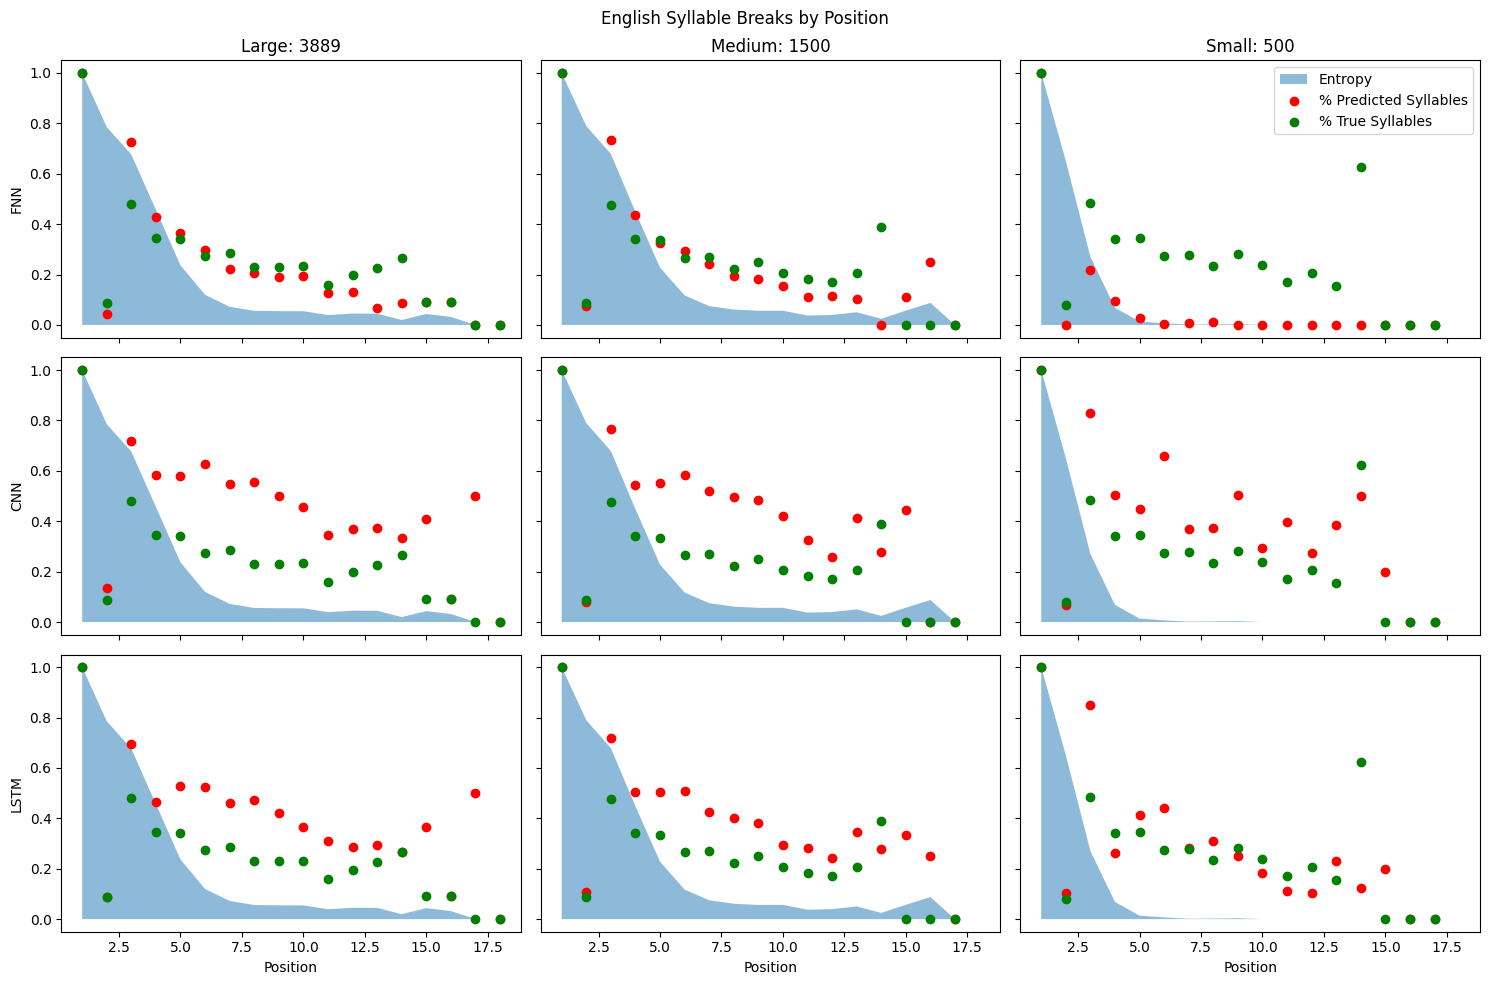

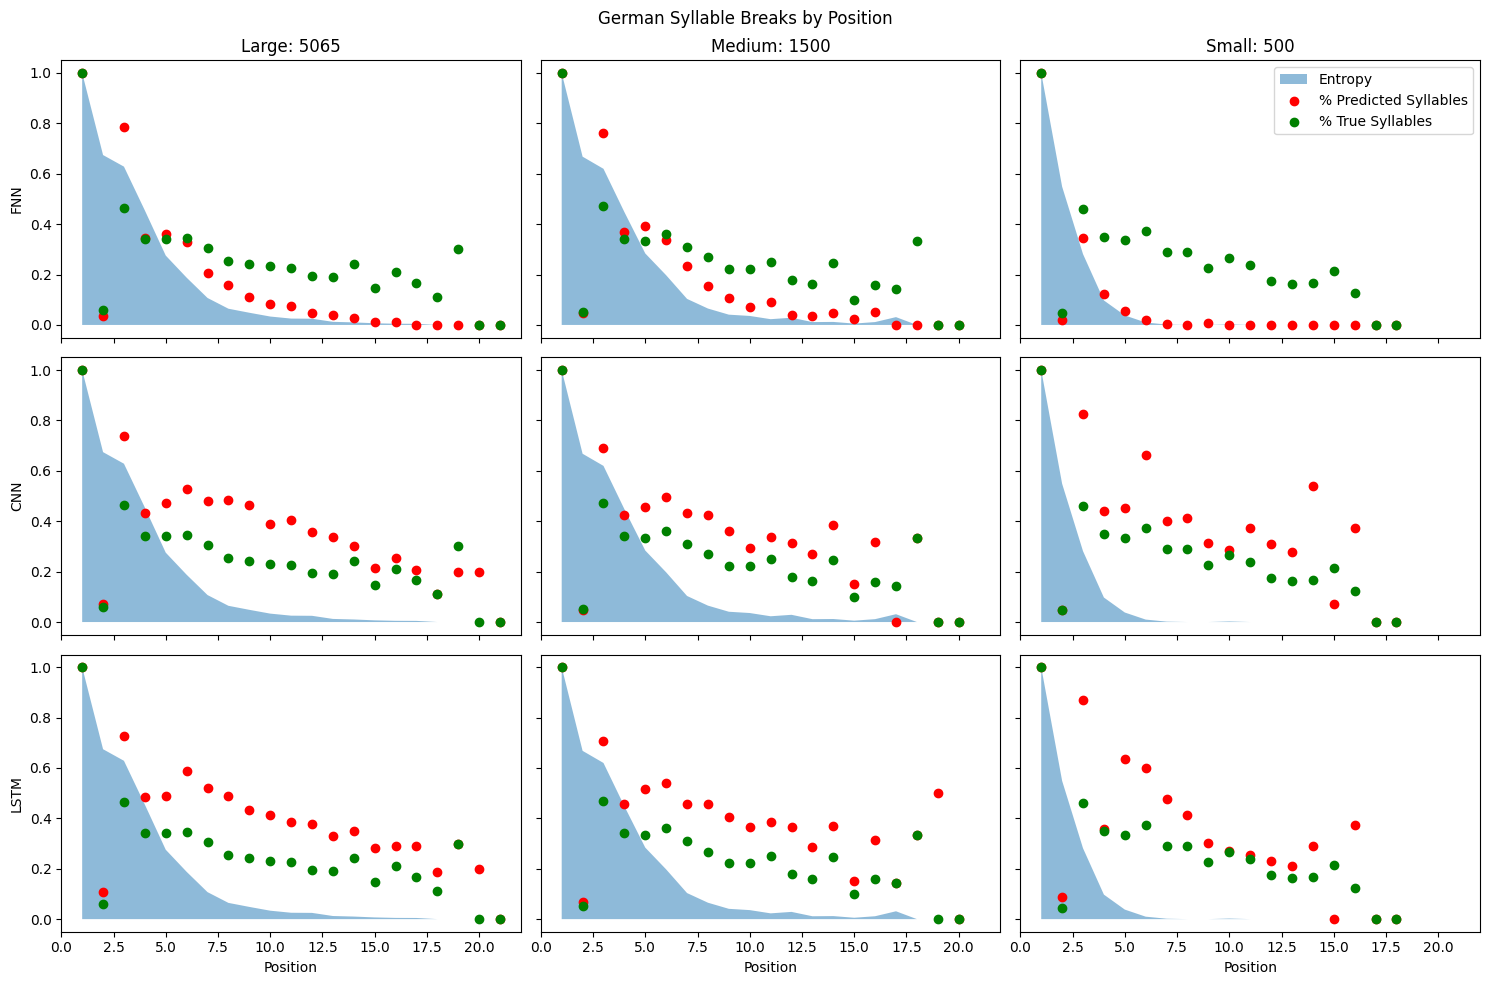

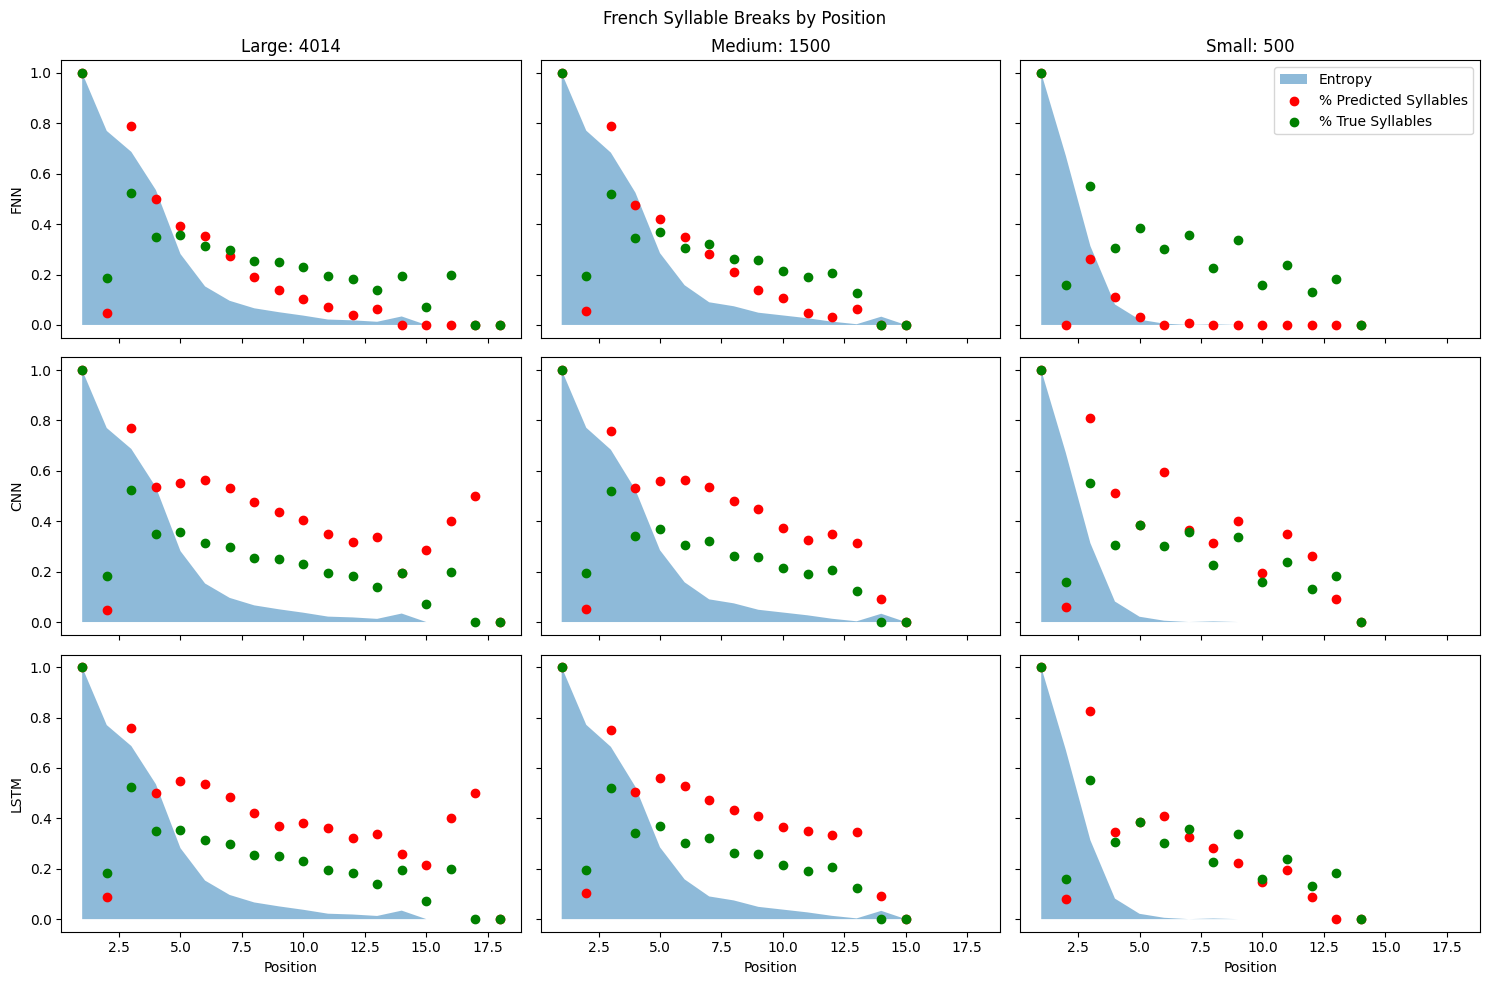

In [ ]:
#@title Plot Syllable Breaks by Position
for lang in ['English','German','French']:
  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10), sharex=True, sharey=True)
  for i, model in enumerate(['FNN','CNN','LSTM']):
    for j, size in enumerate(['Large', 'Medium', 'Small']):
      if size == 'Large':
        results = large_results
        preds = large_preds
      elif size == 'Medium':
        results = medium_results
        preds = medium_preds
      else:
        results = small_results
        preds = small_preds
      positions = results[model][lang].index
      syllables = results[model][lang]['Syllables'] / results[model][lang]['Segments']
      predictions = results[model][lang]['Predicted'] / results[model][lang]['Segments']
      entropy = [preds[model][lang][preds[model][lang]['Positions']==pos]['Surprisals'].mean() for pos in positions]
      entropy = entropy / max(entropy)
      ax[i,j].fill_between(positions, entropy, alpha=0.5, label='Entropy')
      ax[i,j].scatter(positions, predictions, c='red', label='% Predicted Syllables')
      ax[i,j].scatter(positions, syllables, c='green', label='% True Syllables')
      ax[0,j].set_title(f"{size}: {len(preds[model][lang].index.unique())}")
      ax[2,j].set_xlabel('Position')
    ax[i,0].set_ylabel(model)
  ax[0,2].legend()
  #ax[2].set_xticks(range(1,22,2))
  plt.suptitle(f'{lang} Syllable Breaks by Position')
  plt.tight_layout()
  plt.savefig(f'{lang} Syllable Breaks by Position.png')
  plt.show()
  print()
  print()

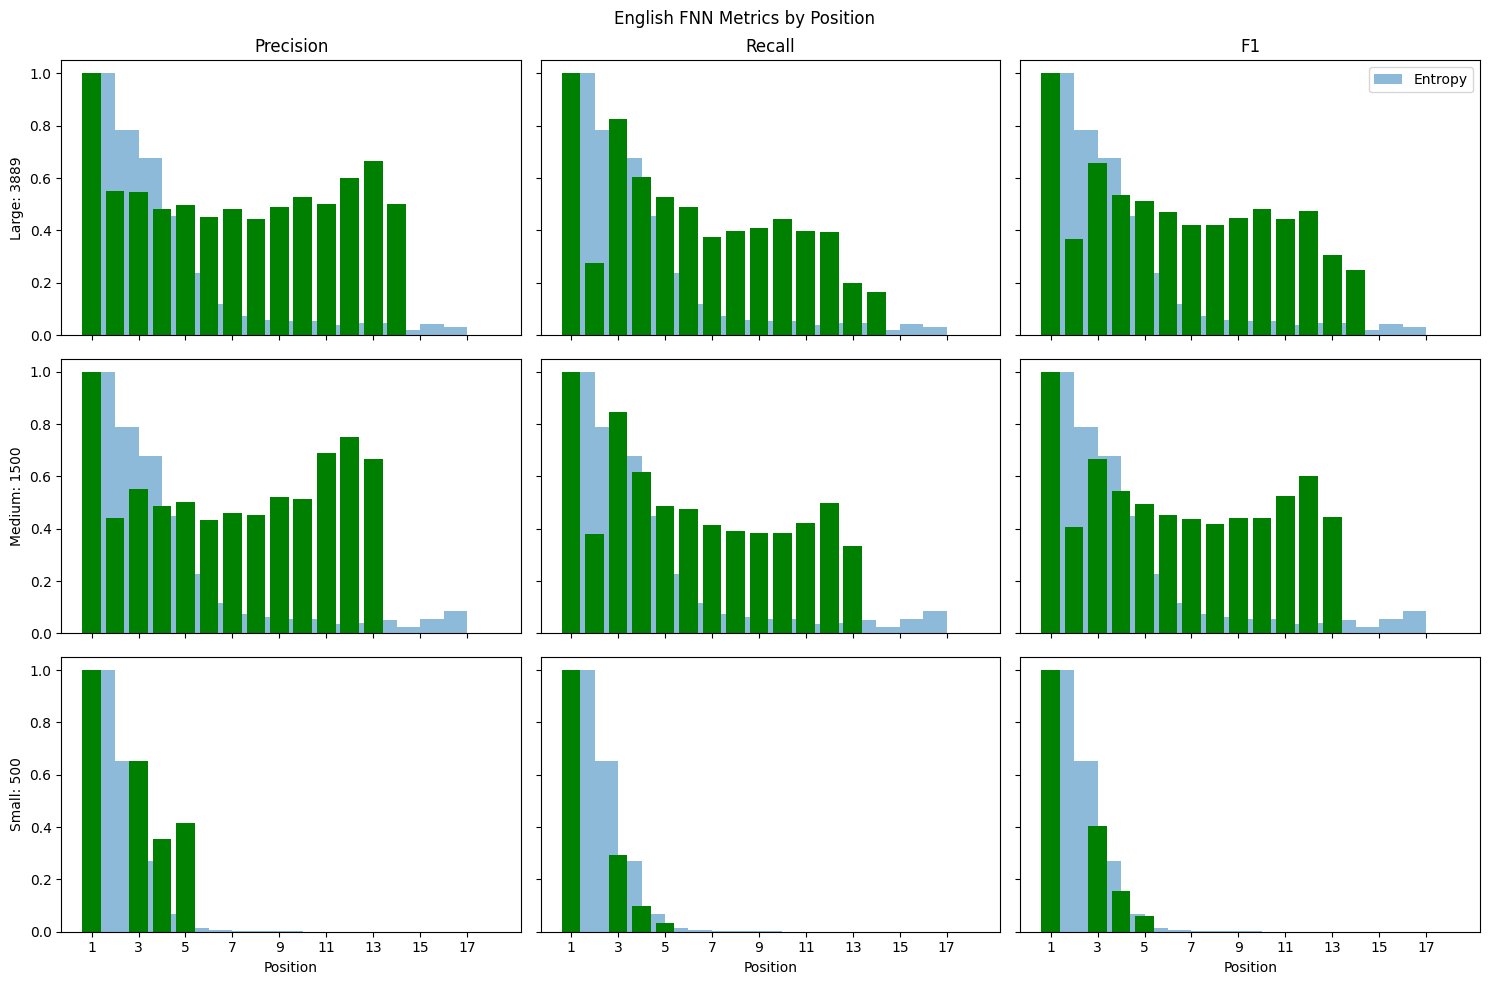

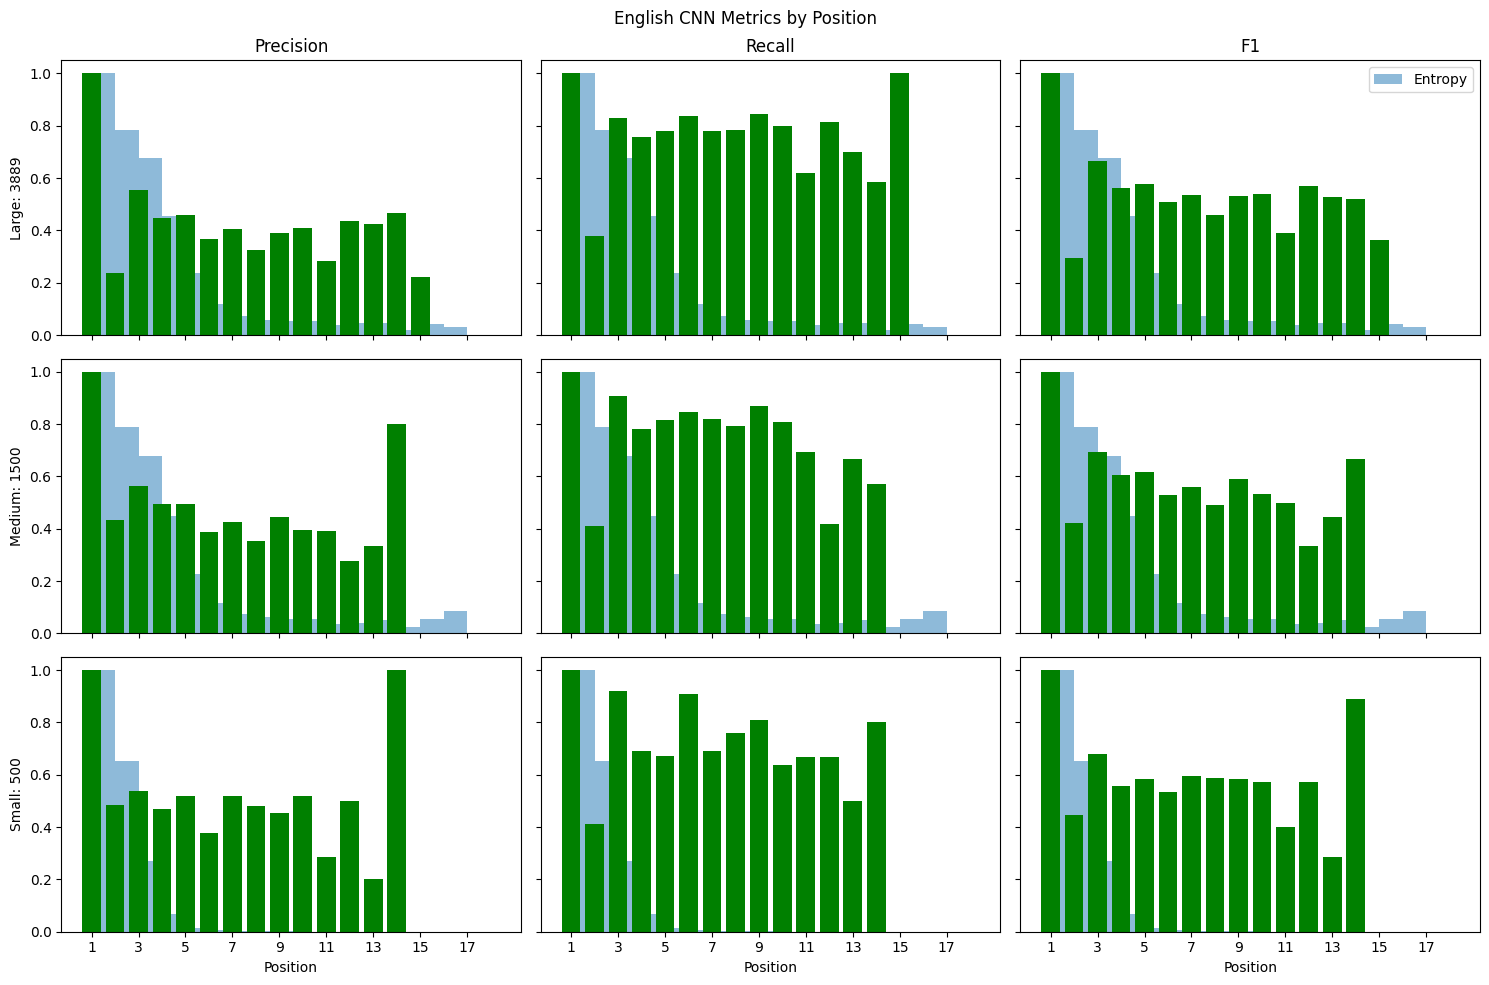

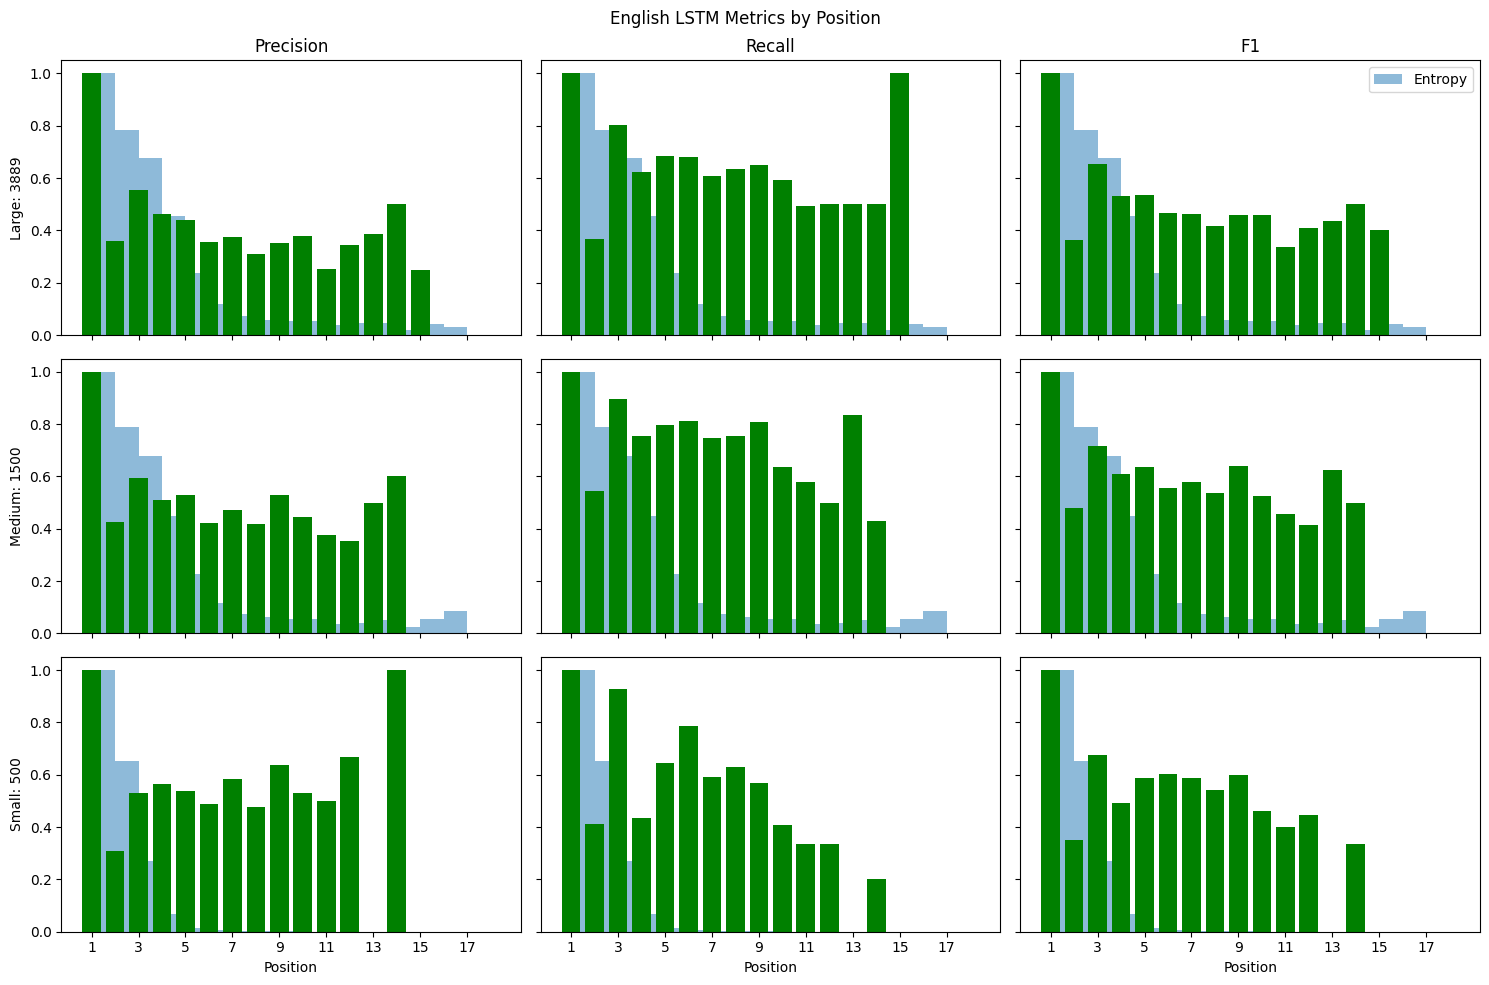

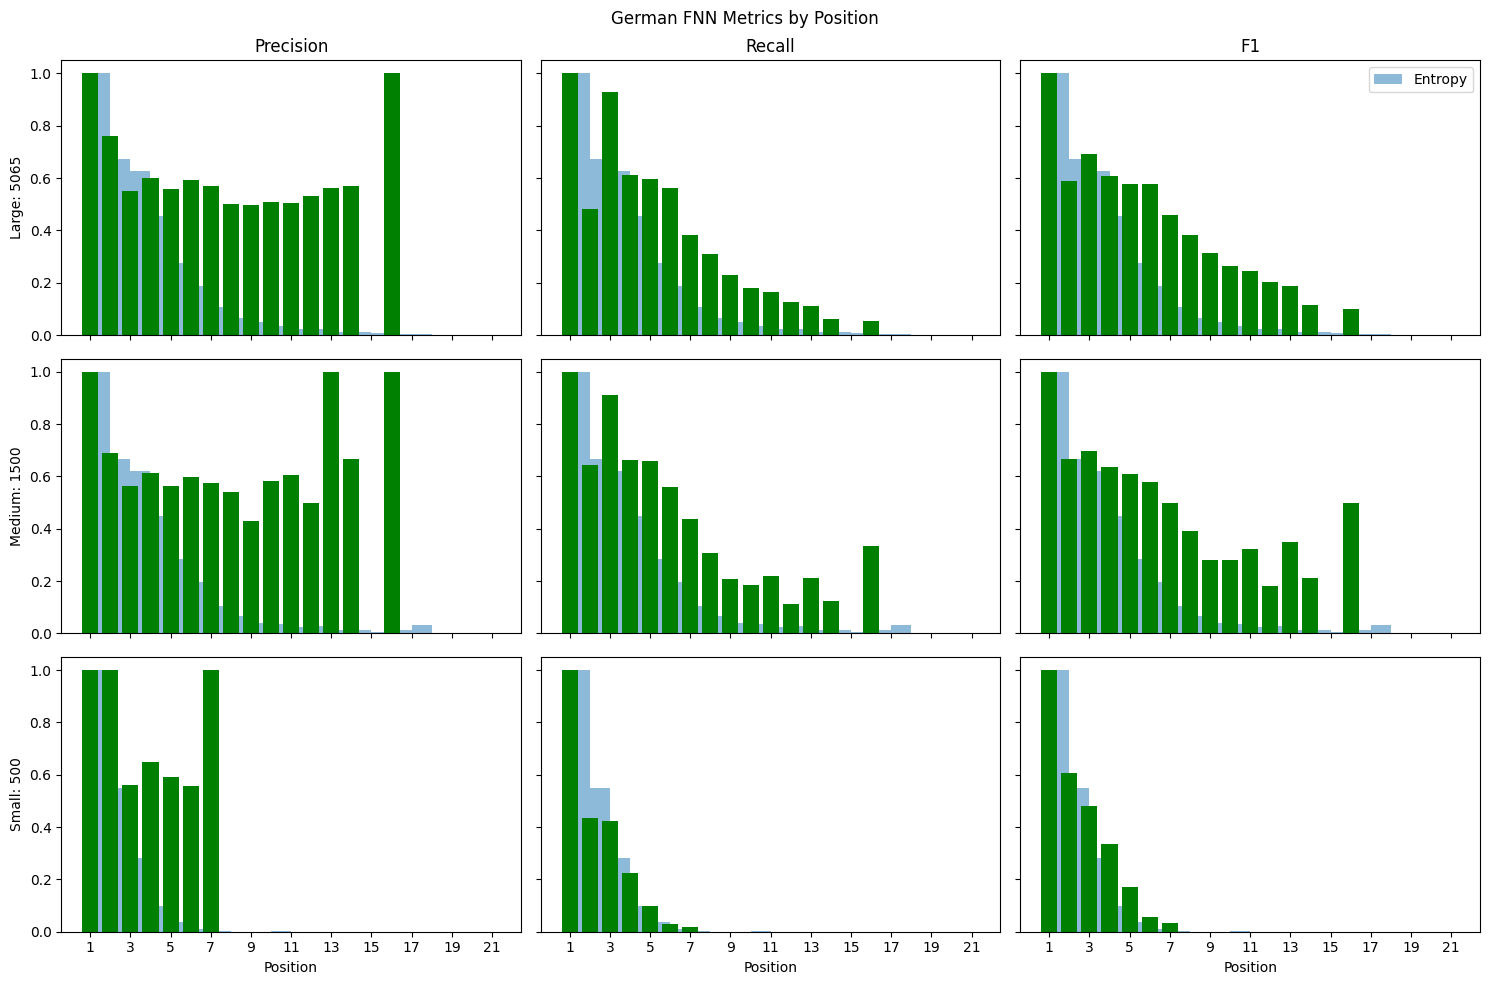

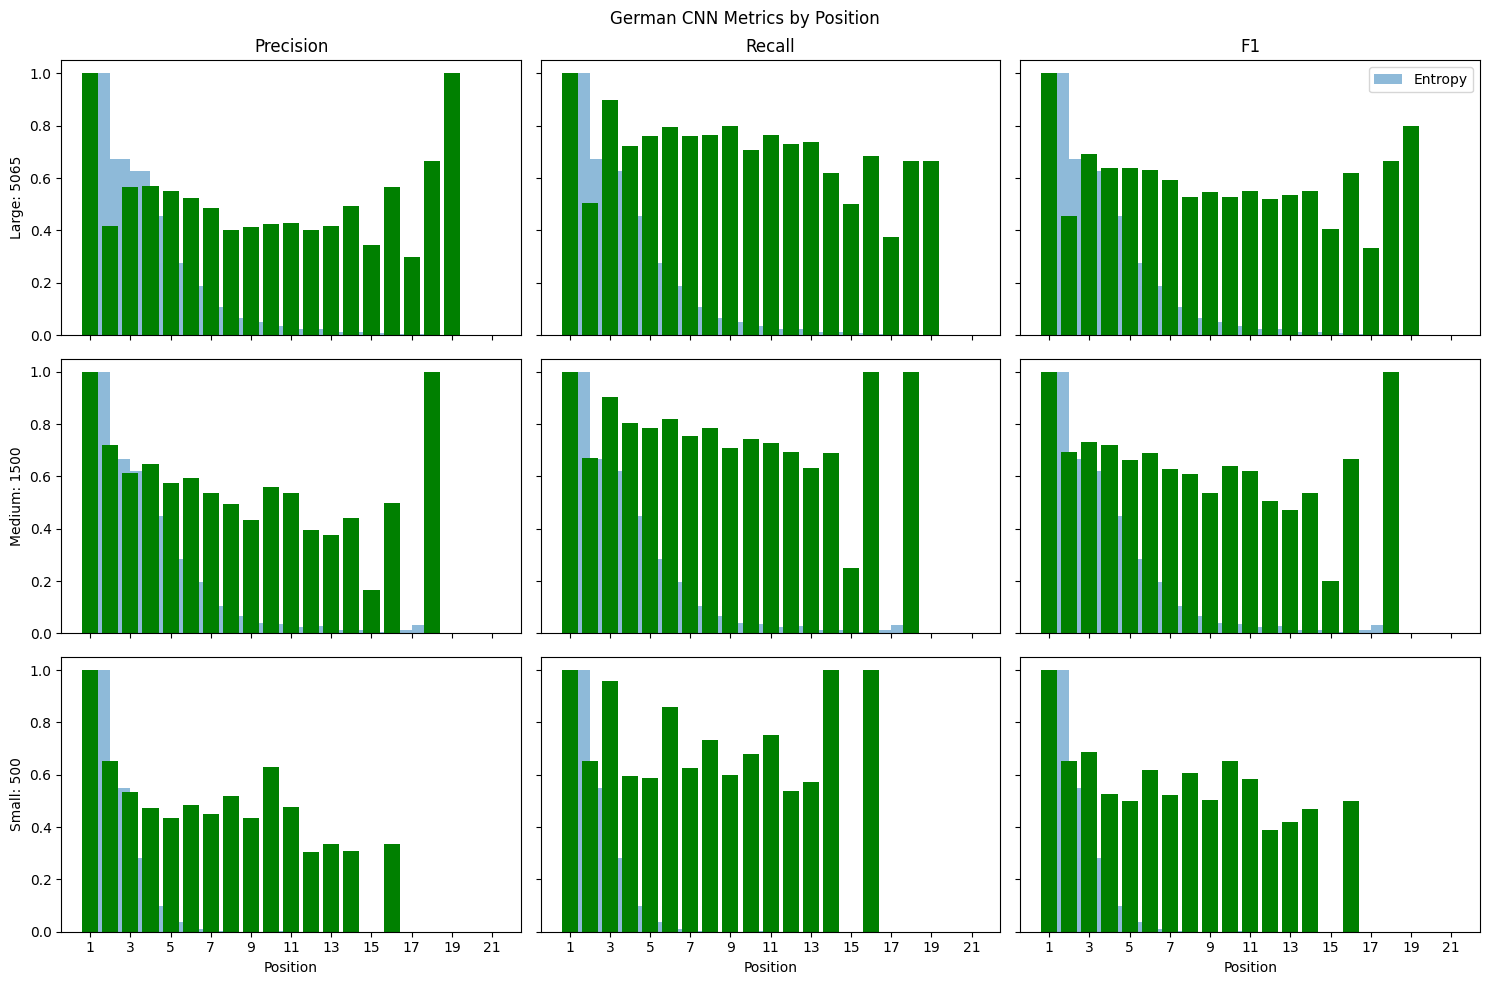

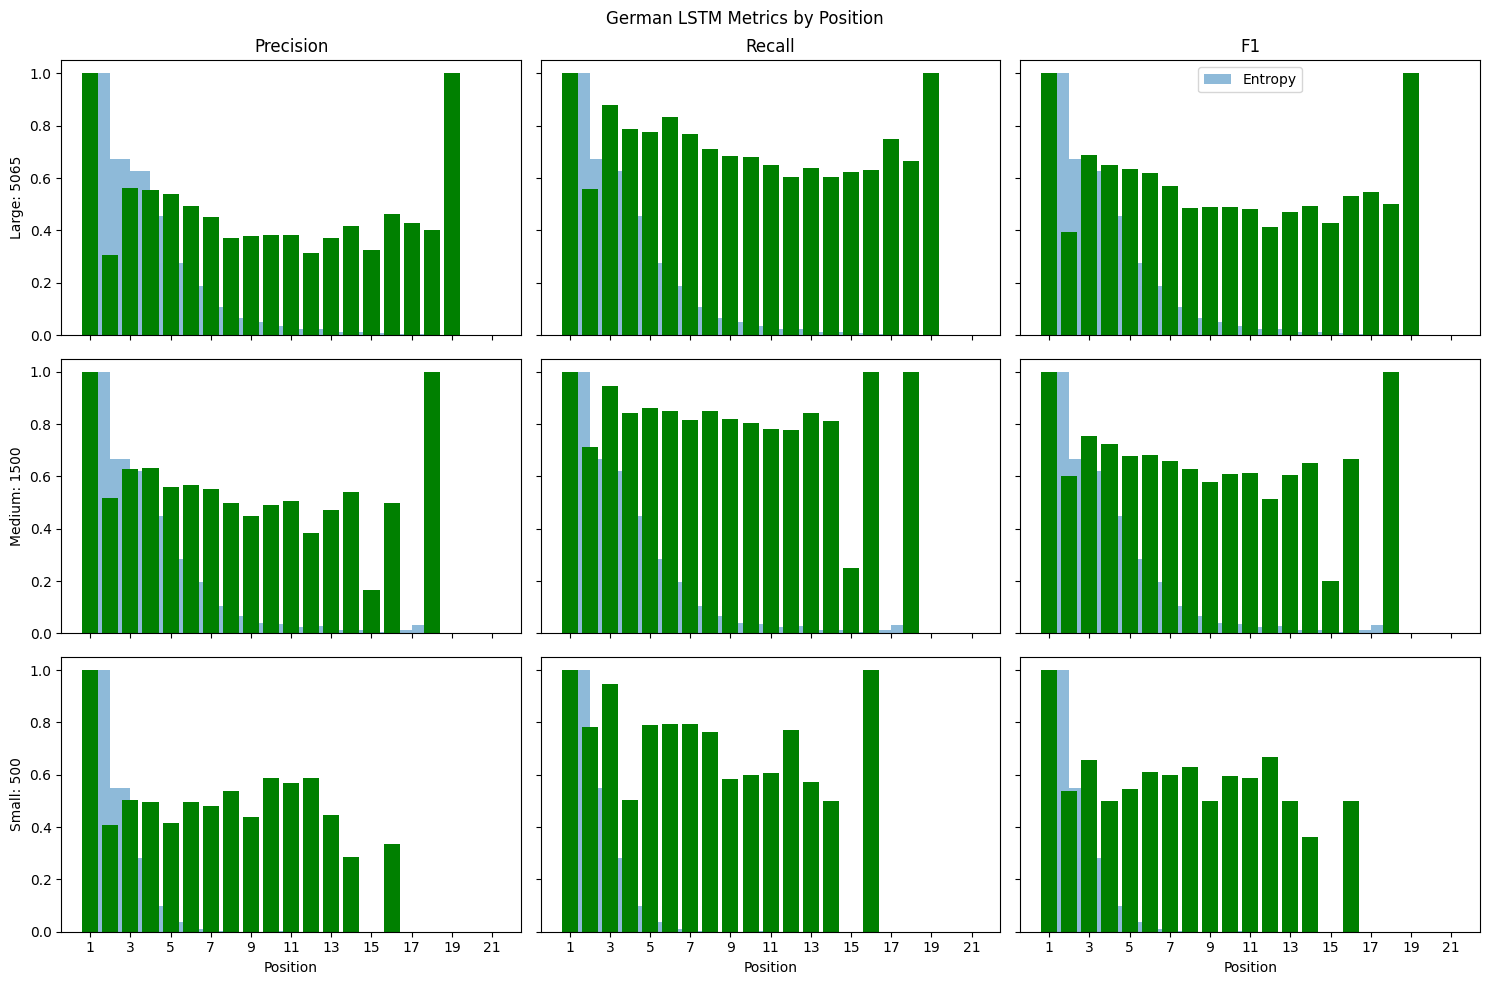

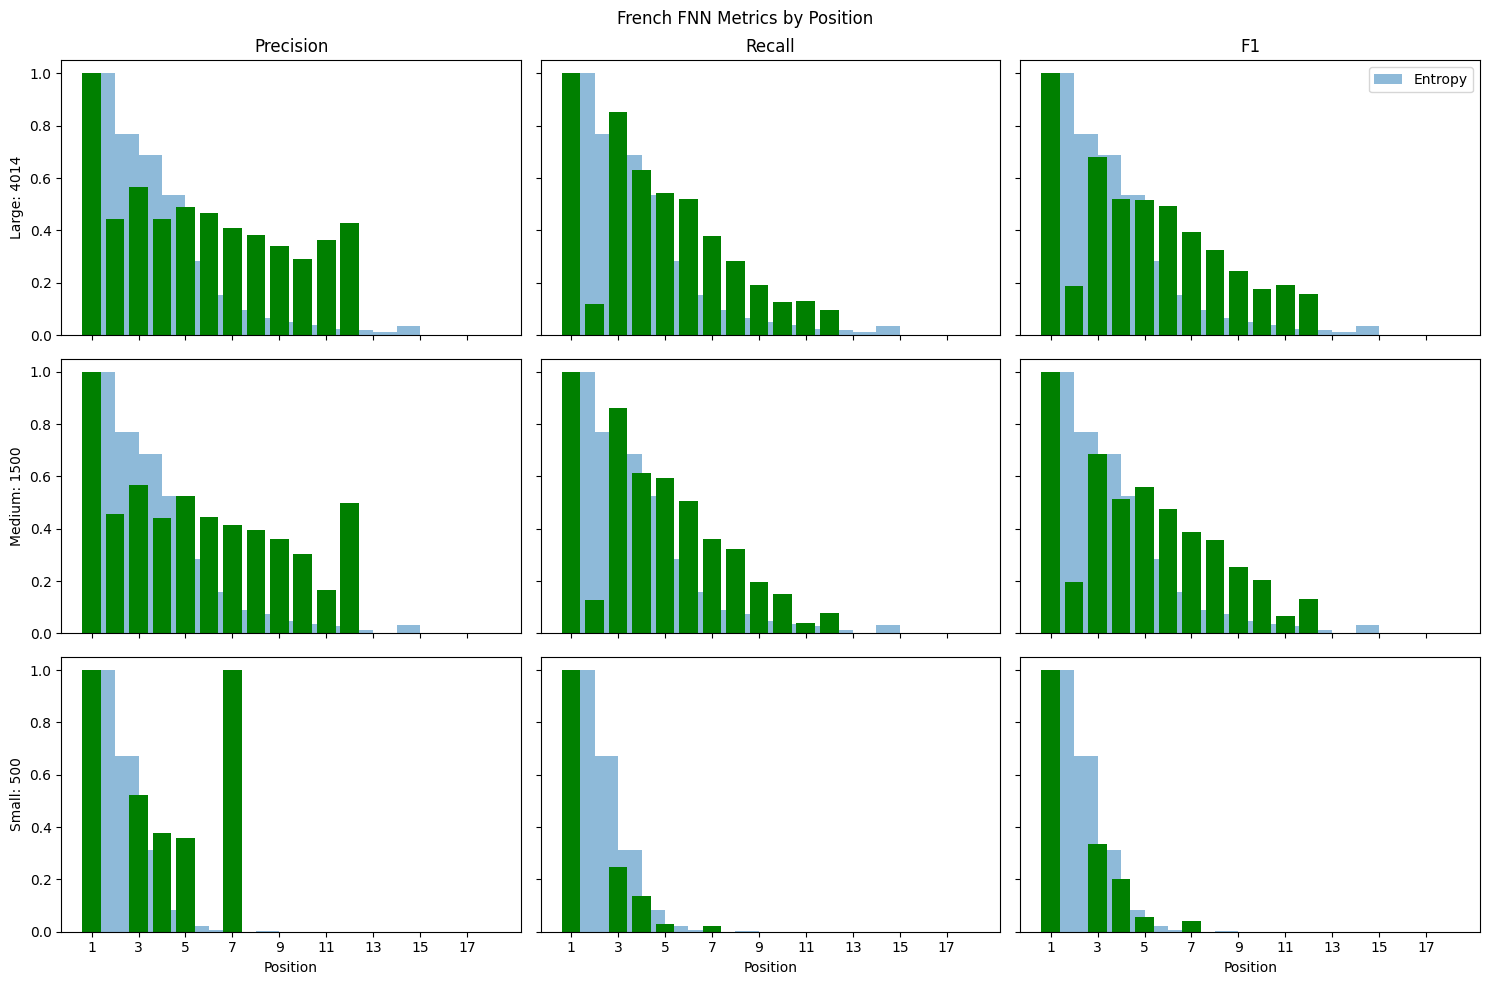

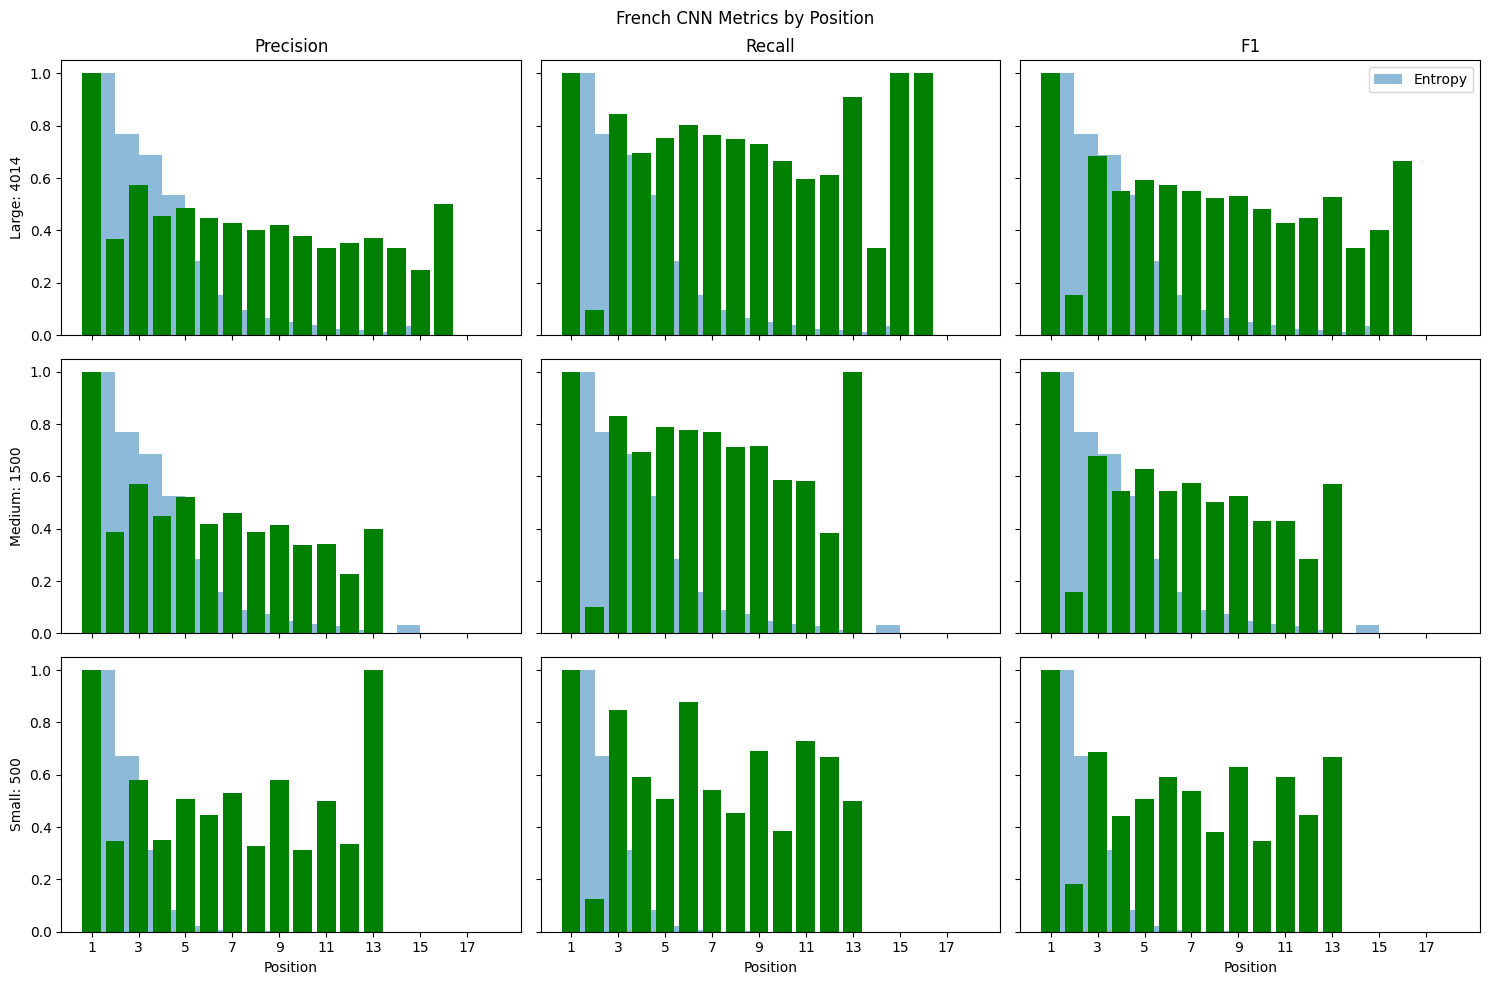

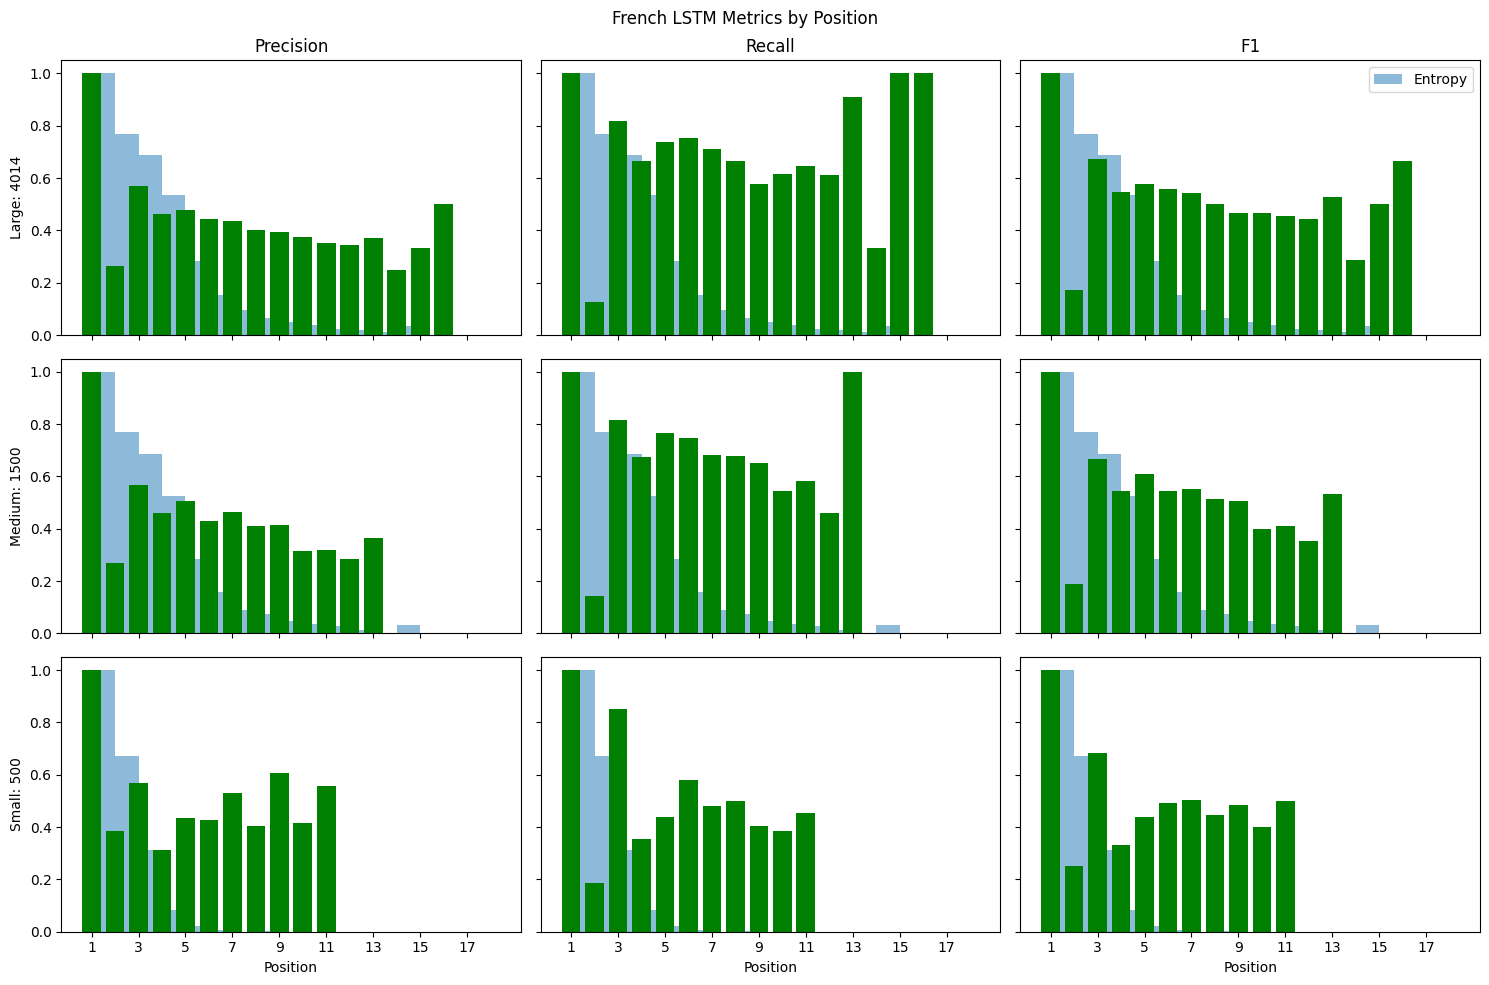

In [ ]:
#@title Plot Metrics by Position
for lang in ['English','German','French']:
  for model in ['FNN','CNN','LSTM']:
    max_pos = large_preds[model][lang]['Positions'].max() + 1
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10), sharex=True, sharey=True)
    for i, size in enumerate(['Large', 'Medium', 'Small']):
      for j, metric in enumerate(['Precision','Recall','F1']):
        if size == 'Large':
          results = large_results
          preds = large_preds
        elif size == 'Medium':
          results = medium_results
          preds = medium_preds
        else:
          results = small_results
          preds = small_preds
        positions = results[model][lang].index
        metrics = results[model][lang][metric]
        entropy = [preds[model][lang][preds[model][lang]['Positions']==pos]['Surprisals'].mean() for pos in positions]
        entropy = entropy / max(entropy)
        ax[i,j].fill_between(positions, entropy, step='post', alpha=0.5, label='Entropy')
        ax[i,j].bar(positions, metrics, color='green')
        ax[0,j].set_title(metric)
        ax[2,j].set_xlabel('Position')
        ax[2,j].set_xticks(range(1,max_pos,2))
      ax[i,0].set_ylabel(f"{size}: {len(preds[model][lang].index.unique())}")
    ax[0,2].legend()
    plt.suptitle(f'{lang} {model} Metrics by Position')
    plt.tight_layout()
    plt.savefig(f'{lang} {model} Metrics by Position.png')
    plt.show()
    print()
    print()

# Old

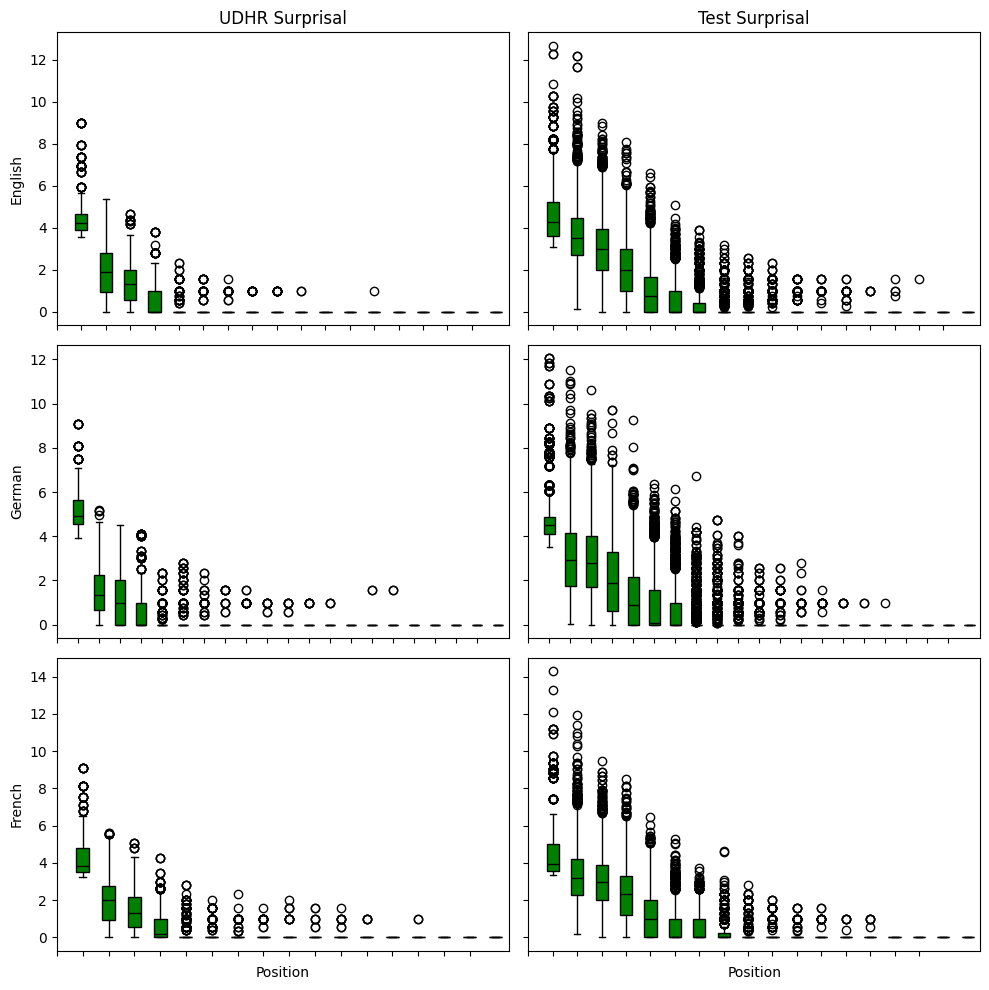

In [ ]:
#@title Plot Cased UDHR Surprisal Across Positions

# Compare to Test Set surprisals
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'
with open(os.path.join(data_folder, 'Original', 'All_Langs_Test_Original.pickle'), 'rb') as f:
  test_ds = pickle.load(f)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharey='row')
for i, (lang,code,df) in enumerate([('English','en',english_surprisal),('German','de',german_surprisal),('French','fr',french_surprisal)]):
  udhr_surprisals = [df[df['position']==pos]['surprisal'] for pos in df['position'].unique()]
  test_surprisals = [[(pos, surprisal) for pos, surprisal in enumerate(entry[0])] for entry in test_ds if entry[2]==code]
  test_positions = [pos for entry in test_surprisals for pos, surprisal in entry]
  test_surprisals = [surprisal for entry in test_surprisals for pos, surprisal in entry]
  test_df = pd.DataFrame({'position':test_positions, 'surprisal':test_surprisals})
  test_surprisals = [test_df[test_df['position']==pos]['surprisal'] for pos in test_df['position'].unique()]

  ax[i,0].boxplot(udhr_surprisals, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,1].boxplot(test_surprisals, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_xticks(range(len(udhr_surprisals)),[])
  ax[i,1].set_xticks(range(len(udhr_surprisals)),[])
ax[0,0].set_title('UDHR Surprisal')
ax[0,1].set_title('Test Surprisal')
ax[0,0].set_ylabel('English')
ax[1,0].set_ylabel('German')
ax[2,0].set_ylabel('French')
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
plt.tight_layout()
plt.savefig('UDHR Surprisal (cased).png')
plt.show()

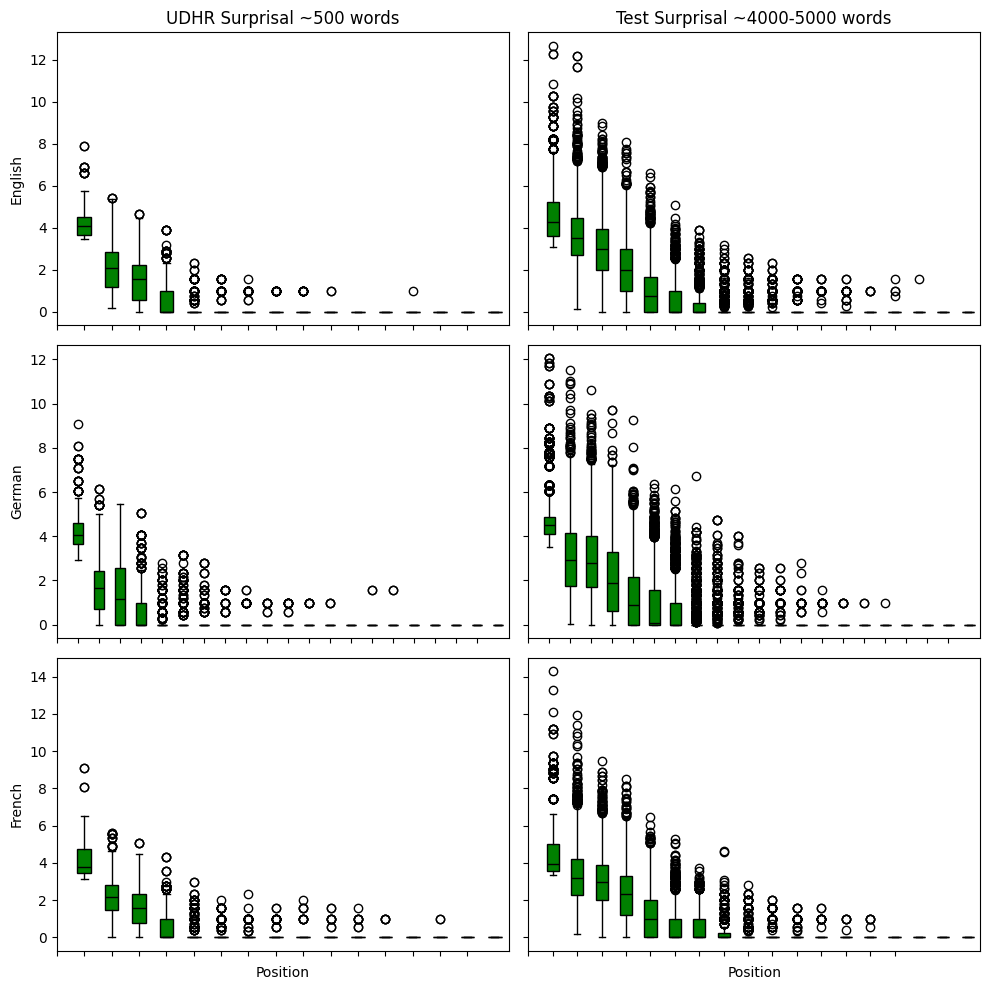

In [ ]:
#@title Plot Uncased UDHR Surprisal Across Positions

# Compare to original Test Set surprisals
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets'
with open(os.path.join(data_folder, 'Original', 'All_Langs_Test_Original.pickle'), 'rb') as f:
  test_ds = pickle.load(f)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharey='row')
for i, (lang, code) in enumerate([('English','en'),('German','de'),('French','fr')]):
  udhr_df = udhr_surprisals[lang]
  udhr_surp = [udhr_df[udhr_df['position']==pos]['surprisal'] for pos in udhr_df['position'].unique()]
  test_surp = [[(pos, surprisal) for pos, surprisal in enumerate(entry[0])] for entry in test_ds if entry[2]==code]
  test_positions = [pos for entry in test_surp for pos, surprisal in entry]
  test_surp = [surprisal for entry in test_surp for pos, surprisal in entry]
  test_df = pd.DataFrame({'position':test_positions, 'surprisal':test_surp})
  test_surp = [test_df[test_df['position']==pos]['surprisal'] for pos in test_df['position'].unique()]

  ax[i,0].boxplot(udhr_surp, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,1].boxplot(test_surp, notch=False, patch_artist=True, boxprops={'facecolor':'green'}, medianprops={'color':'black'})
  ax[i,0].set_xticks(range(len(udhr_surp)),[])
  ax[i,1].set_xticks(range(len(udhr_surp)),[])
ax[0,0].set_title('UDHR Surprisal ~500 words')
ax[0,1].set_title('Test Surprisal ~4000-5000 words')
ax[0,0].set_ylabel('English')
ax[1,0].set_ylabel('German')
ax[2,0].set_ylabel('French')
ax[2,0].set_xlabel('Position')
ax[2,1].set_xlabel('Position')
plt.tight_layout()
plt.savefig('UDHR (uncased) and Test (original) Surprisals.png')
plt.show()

In [ ]:
#@title Install Pyphen
'''
%%capture
!pip install pyphen
'''
print()

In [ ]:
#@title Syllabify UDHR with Pyphen
'''
import pyphen

# Get language syllabifiers
english_syllabifier = pyphen.Pyphen(lang='en_GB')
german_syllabifier = pyphen.Pyphen(lang='de_DE')
french_syllabifier = pyphen.Pyphen(lang='fr')

# Syllabify all words in lexicons using "_"
english_sylls = [english_syllabifier.inserted(word,hyphen='_') for word in english_lexicon]
german_sylls = [german_syllabifier.inserted(word,hyphen='_') for word in german_lexicon]
french_sylls = [french_syllabifier.inserted(word,hyphen='_') for word in french_lexicon]

# Mark initial syllable with starting "_"

# Write syllabified words to text files
with open('UDHR_English_Syllables.txt','w') as f:
  f.write('\n'.join(english_sylls))
with open('UDHR_German_Syllables.txt','w') as f:
  f.write('\n'.join(german_sylls))
with open('UDHR_French_Syllables.txt','w') as f:
  f.write('\n'.join(french_sylls))
'''
print()